#  Experimentos colaborativos | Feature Engineering en SQL
Data mining en economía y finanzas

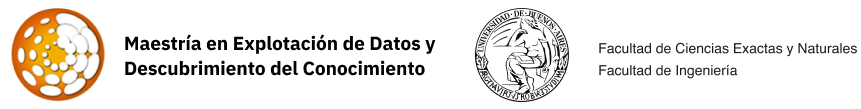

[Víctor A. Bettachini](mailto:bettachini@gmail.com)

## Importación de bibliotecas  

In [1]:
try:
    import duckdb
except:
    ! pip install duckdb
    ! pip install jupysql
    ! pip install duckdb-engine
    import duckdb
# Restart kernel after install

In [2]:
# Load jupySQL extension
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Quiero crear una archivo de base de datos en archivo, no en memoria.

In [3]:
! pwd

/home/vbettachini/documents/universitet/FCEyN/maestríaDatos/economíaFinanzas/dmeyf2023/experimentos


In [4]:
! ls ../../buckets/b1/datasets

colaborativos.db	     competencia_02_eng_bajas.pkl    p_bajas_02.npy
colaborativos.db.wal	     competencia_02_eng.csv.gz	     shap_bajas_02.pkl
competencia_02_3.csv.gz      competencia_03_baseline.csv.gz  shap_values_02
competencia_02_crudo.csv.gz  competencia_03_crudo.csv.gz     test
competencia_02.csv.gz	     lgbm_importancia_02.pkl


In [5]:
# Instead of in memory, this will create a file in the dataset directory  

# # Start a DuckDB in-memory database
# %sql duckdb:///:default:
 
%sql duckdb:///../../buckets/b1/datasets/colaborativos.db 

## Carga de los datos en crudo

In [6]:
%%time
%%sql
create or replace table engineered as
select
    *
from read_csv_auto('../../buckets/b1/datasets/competencia_03_crudo.csv.gz')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 3min 22s, sys: 11.2 s, total: 3min 33s
Wall time: 1min 21s


,Success


## Análisis exploratorio de datos

¿Levantó todos los registros?

In [7]:
%%sql
SELECT COUNT(*) FROM engineered

,count_star()
0,4893028


¿Que atributos hay?

In [8]:
%%sql
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'engineered'

,column_name,data_type
0,numero_de_cliente,BIGINT
1,foto_mes,BIGINT
2,active_quarter,BIGINT
3,cliente_vip,BIGINT
4,internet,BIGINT
...,...,...
149,Visa_fechaalta,BIGINT
150,Visa_mconsumototal,DOUBLE
151,Visa_cconsumos,BIGINT
152,Visa_cadelantosefectivo,BIGINT


¿Que rango de foto_mes tiene el dataset?

In [9]:
%%sql
SELECT MIN(foto_mes) AS min_foto_mes, MAX(foto_mes) AS max_foto_mes
FROM engineered;

,min_foto_mes,max_foto_mes
0,201901,202109


## Creación de clase ternaria
Copia de [solución de Tomás Elesser publicada en Zulip](https://dmeyf2023.zulip.rebelare.com/#narrow/stream/401-Code/topic/clase_ternaria.20sql)

In [10]:
%%sql
create or replace table engineered AS
WITH aux AS  (
    SELECT numero_de_cliente, foto_mes,
    (foto_mes//100-2019)*12+foto_mes%100 as mes,
    IF(foto_mes = (select max(foto_mes) from engineered) , -1, lead(mes,1,0) OVER (PARTITION BY "numero_de_cliente" ORDER BY numero_de_cliente, mes)) AS 'mes+1',
    IF(foto_mes = (select max(foto_mes) from engineered) OR foto_mes = ((select max(foto_mes) from engineered)-1), -1,lead(mes,2,0) OVER (PARTITION BY "numero_de_cliente" ORDER BY numero_de_cliente, mes)) AS 'mes+2',
    FROM
       engineered
    ORDER BY numero_de_cliente, foto_mes)
SELECT *,
CASE
    -- Condiciones de borde:
    WHEN ("mes+1"==-1) THEN 'CONTINUA'
    WHEN ("mes+2"==-1) THEN 'CONTINUA'
    -- Si mes siguiente no es consecutivo o no existe:
    WHEN ("mes"+1 != "mes+1") THEN 'BAJA+1'
    WHEN ("mes"+2 != "mes+2") THEN 'BAJA+2'
    -- si proximos 2 meses consecutivos activos:
    ELSE 'CONTINUA' END AS "clase_ternaria"
FROM aux
LEFT JOIN engineered c USING (numero_de_cliente, foto_mes);

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Success


In [11]:
%%sql
ALTER table engineered DROP COLUMN "mes";
ALTER table engineered DROP COLUMN "mes+1";
ALTER table engineered DROP COLUMN "mes+2";

,Success


Estadística de casos en columna `clase_ternaria` 

In [12]:
%%sql
SELECT clase_ternaria, COUNT(*) AS cantidad
FROM engineered
GROUP BY clase_ternaria;

,clase_ternaria,cantidad
0,BAJA+2,21329
1,CONTINUA,4850868
2,BAJA+1,20831


## Feature engineering

Todo cuanto publicó Bolaños en Zulip fue
> Agregar las variables Lags 1, 3 y 6

Interpreto que es un lag de todas las 152 variables. ¿Qué sentido tendrá para las no numéricas?

### Experimento all6

Acá
- todas la variables
- quito redundantes
- genero un par de auxiliares
- coalescencia tarjetas
- min, max y avg en semestre, lag de 1 a 6 meses
- (actual - (lag 0 a 6 meses))/ avg(lag 0 a 6 meses)

In [13]:
%%sql
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'engineered'
  AND column_name NOT IN ('numero_de_cliente', 'foto_mes');

,column_name
0,active_quarter
1,cliente_vip
2,internet
3,cliente_edad
4,cliente_antiguedad
...,...
148,Visa_mconsumototal
149,Visa_cconsumos
150,Visa_cadelantosefectivo
151,Visa_mpagominimo


### Columnas no numéricas

In [14]:
%%sql
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'engineered'
AND data_type = 'VARCHAR';

,column_name
0,tmobile_app
1,cmobile_app_trx
2,clase_ternaria


In [15]:
%%sql
SELECT tmobile_app
FROM engineered
WHERE tmobile_app IS NOT NULL
LIMIT 10;

,tmobile_app
0,1
1,1
2,1
3,0
4,1
5,1
6,1
7,0
8,0
9,0


In [16]:
%%sql
-- replace NULLs with 0
UPDATE engineered
SET tmobile_app = 0
WHERE tmobile_app IS NULL;

,Success


In [17]:
%%sql
-- replace NULLs with 0
UPDATE engineered
SET cmobile_app_trx = 0
WHERE cmobile_app_trx IS NULL;

,Success


In [18]:
%%sql
-- cast column to integer
ALTER TABLE engineered
ALTER COLUMN tmobile_app
SET DATA TYPE INTEGER;

,Success


In [19]:
%%sql
-- cast column to integer
ALTER TABLE engineered
ALTER COLUMN cmobile_app_trx
SET DATA TYPE INTEGER;

,Success


In [20]:
%%sql
SELECT column_name
FROM information_schema.columns
WHERE table_name = 'engineered'
AND data_type = 'VARCHAR';

,column_name
0,clase_ternaria


### Atributos redundantes

#### Tarjetas de crédito

Tanto `Visa_mconsumospesos` y `Visa_mconsumototal` como `Master_mconsumospesos` y `Master_mconsumototal` son equivalentes.

In [21]:
%%sql
alter table engineered
drop Master_mconsumototal

,Success


In [22]:
%%sql
alter table engineered
drop Visa_mconsumototal

,Success


#### Autoservicio y ATM

Son iguales la suma de `catm_trx` y `catm_trx_other` que `cextraccion_autoservicio`.

In [23]:
%%sql
alter table engineered
drop cextraccion_autoservicio

,Success


### Nuevos features

#### Saldos negativos

In [24]:
%%sql
alter table engineered
add column mcuentas_saldo_neg tinyint

,Success


In [25]:
%%sql
update engineered
set mcuentas_saldo_neg = case when mcuentas_saldo < 0 then 1 else 0 end

,Success


In [26]:
%%sql
alter table engineered
add column mcuentas_otras_neg int1

,Success


In [27]:
%%sql
update engineered
set mcuentas_otras_neg = case when
  (mcuenta_corriente + mcuenta_corriente_adicional + mcaja_ahorro + mcaja_ahorro_adicional + mcaja_ahorro_dolares) < 0 then 1 else 0 end

,Success


#### Autoservicio y ATM

Indica mayor uso ATM de otro banco.

In [28]:
%%sql
alter table engineered
add column catm_mayor_oth tinyint

,Success


In [29]:
%%sql
update engineered
set catm_mayor_oth = case when
  (catm_trx_other - catm_trx) < 0 then 1 else 0 end

,Success


#### Coalesce tarjetas de credito

In [30]:
%%sql
alter table engineered
add column mtarjeta_consumo int8

,Success


In [31]:
%%sql
update engineered
set mtarjeta_consumo = mtarjeta_master_consumo + mtarjeta_visa_consumo

,Success


In [32]:
%%sql
alter table engineered
drop mtarjeta_master_consumo 

,Success


In [33]:
%%sql
alter table engineered
drop mtarjeta_visa_consumo 

,Success


### Proxy actividad sumando el valor absoluto de todos los monetarios (no tarjetas)

In [34]:
%%sql
alter table engineered
add column actividad long

,Success


In [35]:
%%sql
update engineered
set actividad = abs(matm_other) + abs(matm) +
    abs(mcheques_emitidos_rechazados) + abs(mcheques_depositados_rechazados) +
    abs(mcheques_emitidos) + abs(mcheques_depositados) +
    abs(mextraccion_autoservicio) + abs(mautoservicio) +
    abs(mtransferencias_emitidas) + abs(mtransferencias_recibidas) +
    abs(mforex_sell) + abs(mforex_buy) +
    abs(mpagomiscuentas) + abs(mpagodeservicios) +
    abs(mttarjeta_master_debitos_automaticos) + abs(mttarjeta_visa_debitos_automaticos) +
    abs(mcuenta_debitos_automaticos) + abs(mpayroll2) + abs(mpayroll) +
    abs(minversion2) + abs(minversion1_pesos) + abs(minversion1_dolares) +
    abs(mplazo_fijo_pesos) + abs(mplazo_fijo_dolares) +
    abs(mprestamos_hipotecarios) + abs(mprestamos_prendarios) + abs(mprestamos_personales) +
    abs(mtarjeta_consumo) + 
    abs(mcaja_ahorro_dolares) + abs(mcaja_ahorro_adicional) + abs(mcaja_ahorro) +
    abs(mcuenta_corriente) + abs(mcuenta_corriente_adicional)

,Success


## Lista de columnas

Get to a python list all column names in the table

In [36]:
# Execute a query to get the column names
result = %sql SELECT * FROM engineered LIMIT 0

In [37]:
'numero_de_cliente' in list(result.columns), 'foto_mes' in list(result.columns), 'clase_ternaria' in list(result.columns), 'mes' in list(result.columns), 'mes+1' in list(result.columns), 'mes+2' in list(result.columns)

(True, True, True, False, False, False)

In [38]:
atributos = list( set(result.columns) - set(['numero_de_cliente', 'foto_mes', 'clase_ternaria']) )
atributos

['mtarjeta_visa_descuentos',
 'mplazo_fijo_dolares',
 'Visa_cconsumos',
 'ctarjeta_visa_debitos_automaticos',
 'mcuentas_otras_neg',
 'cforex_buy',
 'Master_mpagosdolares',
 'Visa_Finiciomora',
 'mcomisiones',
 'active_quarter',
 'Master_Finiciomora',
 'mcheques_depositados_rechazados',
 'Visa_mpagado',
 'mautoservicio',
 'actividad',
 'cinversion2',
 'mtransferencias_emitidas',
 'mforex_buy',
 'cforex_sell',
 'Master_msaldototal',
 'cpayroll2_trx',
 'ccajeros_propios_descuentos',
 'mcuenta_corriente',
 'cpagodeservicios',
 'cseguro_vida',
 'mcheques_emitidos',
 'cmobile_app_trx',
 'mrentabilidad_annual',
 'mcheques_depositados',
 'cseguro_vivienda',
 'mextraccion_autoservicio',
 'Master_mpagominimo',
 'mpagodeservicios',
 'minversion1_pesos',
 'Master_mpagospesos',
 'ccheques_emitidos',
 'Visa_fultimo_cierre',
 'cprestamos_hipotecarios',
 'cseguro_auto',
 'ccajas_depositos',
 'ccomisiones_mantenimiento',
 'cforex',
 'minversion2',
 'Visa_mlimitecompra',
 'Master_Fvencimiento',
 'Maste

## Genera comando SQL

### Primer corrida: min, max, avg, lag

In [41]:
## Min, max, avg, lag
columnas = atributos
linea = ""
for col in columnas:
  linea += "  "
  # min semestre
  linea += f", MIN({col}) OVER semestre AS {col}_min"
  # max semestre
  linea += f", MAX({col}) OVER semestre AS {col}_max"
  # promedio semestre
  # linea += f", AVG( {col} ) OVER semestre AS {col}_avg"
  linea += f", AVG( CAST({col} AS DECIMAL ) ) OVER semestre AS {col}_avg"
  # lags todo el semestre
  linea += f", LAG({col}, 1) OVER semestre AS {col}_l1"
  linea += f", LAG({col}, 2) OVER semestre AS {col}_l2"
  linea += f", LAG({col}, 3) OVER semestre AS {col}_l3"
  linea += f", LAG({col}, 4) OVER semestre AS {col}_l4"
  linea += f", LAG({col}, 5) OVER semestre AS {col}_l5"
  linea += f", LAG({col}, 6) OVER semestre AS {col}_l6"
  # fin de linea
  linea += "\n"
# print(linea)

# write linea to file
with open('comando1.txt', 'w') as f:
  f.write( linea )

%%sql
CREATE OR REPLACE TABLE test AS
SELECT
  foto_mes
  , AVG (CAST(mcuentas_saldo AS DECIMAL) ) OVER semestre AS mcuentas_saldo_avg
FROM engineered
window semestre as (partition by numero_de_cliente order by foto_mes rows between 5 preceding and current row);

%%sql
SELECT * FROM test ORDER BY foto_mes DESC LIMIT 10

In [59]:
%%sql
CREATE OR REPLACE TABLE engineered AS
SELECT
  *
  , MIN(ccheques_depositados) OVER semestre AS ccheques_depositados_min, MAX(ccheques_depositados) OVER semestre AS ccheques_depositados_max, AVG( CAST(ccheques_depositados AS DECIMAL ) ) OVER semestre AS ccheques_depositados_avg, LAG(ccheques_depositados, 1) OVER semestre AS ccheques_depositados_l1, LAG(ccheques_depositados, 2) OVER semestre AS ccheques_depositados_l2, LAG(ccheques_depositados, 3) OVER semestre AS ccheques_depositados_l3, LAG(ccheques_depositados, 4) OVER semestre AS ccheques_depositados_l4, LAG(ccheques_depositados, 5) OVER semestre AS ccheques_depositados_l5, LAG(ccheques_depositados, 6) OVER semestre AS ccheques_depositados_l6
  , MIN(cforex) OVER semestre AS cforex_min, MAX(cforex) OVER semestre AS cforex_max, AVG( CAST(cforex AS DECIMAL ) ) OVER semestre AS cforex_avg, LAG(cforex, 1) OVER semestre AS cforex_l1, LAG(cforex, 2) OVER semestre AS cforex_l2, LAG(cforex, 3) OVER semestre AS cforex_l3, LAG(cforex, 4) OVER semestre AS cforex_l4, LAG(cforex, 5) OVER semestre AS cforex_l5, LAG(cforex, 6) OVER semestre AS cforex_l6
  , MIN(cplazo_fijo) OVER semestre AS cplazo_fijo_min, MAX(cplazo_fijo) OVER semestre AS cplazo_fijo_max, AVG( CAST(cplazo_fijo AS DECIMAL ) ) OVER semestre AS cplazo_fijo_avg, LAG(cplazo_fijo, 1) OVER semestre AS cplazo_fijo_l1, LAG(cplazo_fijo, 2) OVER semestre AS cplazo_fijo_l2, LAG(cplazo_fijo, 3) OVER semestre AS cplazo_fijo_l3, LAG(cplazo_fijo, 4) OVER semestre AS cplazo_fijo_l4, LAG(cplazo_fijo, 5) OVER semestre AS cplazo_fijo_l5, LAG(cplazo_fijo, 6) OVER semestre AS cplazo_fijo_l6
  , MIN(actividad) OVER semestre AS actividad_min, MAX(actividad) OVER semestre AS actividad_max, AVG( CAST(actividad AS DECIMAL ) ) OVER semestre AS actividad_avg, LAG(actividad, 1) OVER semestre AS actividad_l1, LAG(actividad, 2) OVER semestre AS actividad_l2, LAG(actividad, 3) OVER semestre AS actividad_l3, LAG(actividad, 4) OVER semestre AS actividad_l4, LAG(actividad, 5) OVER semestre AS actividad_l5, LAG(actividad, 6) OVER semestre AS actividad_l6
  , MIN(catm_trx) OVER semestre AS catm_trx_min, MAX(catm_trx) OVER semestre AS catm_trx_max, AVG( CAST(catm_trx AS DECIMAL ) ) OVER semestre AS catm_trx_avg, LAG(catm_trx, 1) OVER semestre AS catm_trx_l1, LAG(catm_trx, 2) OVER semestre AS catm_trx_l2, LAG(catm_trx, 3) OVER semestre AS catm_trx_l3, LAG(catm_trx, 4) OVER semestre AS catm_trx_l4, LAG(catm_trx, 5) OVER semestre AS catm_trx_l5, LAG(catm_trx, 6) OVER semestre AS catm_trx_l6
  , MIN(mcheques_emitidos) OVER semestre AS mcheques_emitidos_min, MAX(mcheques_emitidos) OVER semestre AS mcheques_emitidos_max, AVG( CAST(mcheques_emitidos AS DECIMAL ) ) OVER semestre AS mcheques_emitidos_avg, LAG(mcheques_emitidos, 1) OVER semestre AS mcheques_emitidos_l1, LAG(mcheques_emitidos, 2) OVER semestre AS mcheques_emitidos_l2, LAG(mcheques_emitidos, 3) OVER semestre AS mcheques_emitidos_l3, LAG(mcheques_emitidos, 4) OVER semestre AS mcheques_emitidos_l4, LAG(mcheques_emitidos, 5) OVER semestre AS mcheques_emitidos_l5, LAG(mcheques_emitidos, 6) OVER semestre AS mcheques_emitidos_l6
  , MIN(mpagomiscuentas) OVER semestre AS mpagomiscuentas_min, MAX(mpagomiscuentas) OVER semestre AS mpagomiscuentas_max, AVG( CAST(mpagomiscuentas AS DECIMAL ) ) OVER semestre AS mpagomiscuentas_avg, LAG(mpagomiscuentas, 1) OVER semestre AS mpagomiscuentas_l1, LAG(mpagomiscuentas, 2) OVER semestre AS mpagomiscuentas_l2, LAG(mpagomiscuentas, 3) OVER semestre AS mpagomiscuentas_l3, LAG(mpagomiscuentas, 4) OVER semestre AS mpagomiscuentas_l4, LAG(mpagomiscuentas, 5) OVER semestre AS mpagomiscuentas_l5, LAG(mpagomiscuentas, 6) OVER semestre AS mpagomiscuentas_l6
  , MIN(mprestamos_prendarios) OVER semestre AS mprestamos_prendarios_min, MAX(mprestamos_prendarios) OVER semestre AS mprestamos_prendarios_max, AVG( CAST(mprestamos_prendarios AS DECIMAL ) ) OVER semestre AS mprestamos_prendarios_avg, LAG(mprestamos_prendarios, 1) OVER semestre AS mprestamos_prendarios_l1, LAG(mprestamos_prendarios, 2) OVER semestre AS mprestamos_prendarios_l2, LAG(mprestamos_prendarios, 3) OVER semestre AS mprestamos_prendarios_l3, LAG(mprestamos_prendarios, 4) OVER semestre AS mprestamos_prendarios_l4, LAG(mprestamos_prendarios, 5) OVER semestre AS mprestamos_prendarios_l5, LAG(mprestamos_prendarios, 6) OVER semestre AS mprestamos_prendarios_l6
  , MIN(cforex_sell) OVER semestre AS cforex_sell_min, MAX(cforex_sell) OVER semestre AS cforex_sell_max, AVG( CAST(cforex_sell AS DECIMAL ) ) OVER semestre AS cforex_sell_avg, LAG(cforex_sell, 1) OVER semestre AS cforex_sell_l1, LAG(cforex_sell, 2) OVER semestre AS cforex_sell_l2, LAG(cforex_sell, 3) OVER semestre AS cforex_sell_l3, LAG(cforex_sell, 4) OVER semestre AS cforex_sell_l4, LAG(cforex_sell, 5) OVER semestre AS cforex_sell_l5, LAG(cforex_sell, 6) OVER semestre AS cforex_sell_l6
  , MIN(ctrx_quarter) OVER semestre AS ctrx_quarter_min, MAX(ctrx_quarter) OVER semestre AS ctrx_quarter_max, AVG( CAST(ctrx_quarter AS DECIMAL ) ) OVER semestre AS ctrx_quarter_avg, LAG(ctrx_quarter, 1) OVER semestre AS ctrx_quarter_l1, LAG(ctrx_quarter, 2) OVER semestre AS ctrx_quarter_l2, LAG(ctrx_quarter, 3) OVER semestre AS ctrx_quarter_l3, LAG(ctrx_quarter, 4) OVER semestre AS ctrx_quarter_l4, LAG(ctrx_quarter, 5) OVER semestre AS ctrx_quarter_l5, LAG(ctrx_quarter, 6) OVER semestre AS ctrx_quarter_l6
  , MIN(Master_mfinanciacion_limite) OVER semestre AS Master_mfinanciacion_limite_min, MAX(Master_mfinanciacion_limite) OVER semestre AS Master_mfinanciacion_limite_max, AVG( CAST(Master_mfinanciacion_limite AS DECIMAL ) ) OVER semestre AS Master_mfinanciacion_limite_avg, LAG(Master_mfinanciacion_limite, 1) OVER semestre AS Master_mfinanciacion_limite_l1, LAG(Master_mfinanciacion_limite, 2) OVER semestre AS Master_mfinanciacion_limite_l2, LAG(Master_mfinanciacion_limite, 3) OVER semestre AS Master_mfinanciacion_limite_l3, LAG(Master_mfinanciacion_limite, 4) OVER semestre AS Master_mfinanciacion_limite_l4, LAG(Master_mfinanciacion_limite, 5) OVER semestre AS Master_mfinanciacion_limite_l5, LAG(Master_mfinanciacion_limite, 6) OVER semestre AS Master_mfinanciacion_limite_l6
  , MIN(Visa_Fvencimiento) OVER semestre AS Visa_Fvencimiento_min, MAX(Visa_Fvencimiento) OVER semestre AS Visa_Fvencimiento_max, AVG( CAST(Visa_Fvencimiento AS DECIMAL ) ) OVER semestre AS Visa_Fvencimiento_avg, LAG(Visa_Fvencimiento, 1) OVER semestre AS Visa_Fvencimiento_l1, LAG(Visa_Fvencimiento, 2) OVER semestre AS Visa_Fvencimiento_l2, LAG(Visa_Fvencimiento, 3) OVER semestre AS Visa_Fvencimiento_l3, LAG(Visa_Fvencimiento, 4) OVER semestre AS Visa_Fvencimiento_l4, LAG(Visa_Fvencimiento, 5) OVER semestre AS Visa_Fvencimiento_l5, LAG(Visa_Fvencimiento, 6) OVER semestre AS Visa_Fvencimiento_l6
  , MIN(Visa_cadelantosefectivo) OVER semestre AS Visa_cadelantosefectivo_min, MAX(Visa_cadelantosefectivo) OVER semestre AS Visa_cadelantosefectivo_max, AVG( CAST(Visa_cadelantosefectivo AS DECIMAL ) ) OVER semestre AS Visa_cadelantosefectivo_avg, LAG(Visa_cadelantosefectivo, 1) OVER semestre AS Visa_cadelantosefectivo_l1, LAG(Visa_cadelantosefectivo, 2) OVER semestre AS Visa_cadelantosefectivo_l2, LAG(Visa_cadelantosefectivo, 3) OVER semestre AS Visa_cadelantosefectivo_l3, LAG(Visa_cadelantosefectivo, 4) OVER semestre AS Visa_cadelantosefectivo_l4, LAG(Visa_cadelantosefectivo, 5) OVER semestre AS Visa_cadelantosefectivo_l5, LAG(Visa_cadelantosefectivo, 6) OVER semestre AS Visa_cadelantosefectivo_l6
  , MIN(tcallcenter) OVER semestre AS tcallcenter_min, MAX(tcallcenter) OVER semestre AS tcallcenter_max, AVG( CAST(tcallcenter AS DECIMAL ) ) OVER semestre AS tcallcenter_avg, LAG(tcallcenter, 1) OVER semestre AS tcallcenter_l1, LAG(tcallcenter, 2) OVER semestre AS tcallcenter_l2, LAG(tcallcenter, 3) OVER semestre AS tcallcenter_l3, LAG(tcallcenter, 4) OVER semestre AS tcallcenter_l4, LAG(tcallcenter, 5) OVER semestre AS tcallcenter_l5, LAG(tcallcenter, 6) OVER semestre AS tcallcenter_l6
  , MIN(minversion1_pesos) OVER semestre AS minversion1_pesos_min, MAX(minversion1_pesos) OVER semestre AS minversion1_pesos_max, AVG( CAST(minversion1_pesos AS DECIMAL ) ) OVER semestre AS minversion1_pesos_avg, LAG(minversion1_pesos, 1) OVER semestre AS minversion1_pesos_l1, LAG(minversion1_pesos, 2) OVER semestre AS minversion1_pesos_l2, LAG(minversion1_pesos, 3) OVER semestre AS minversion1_pesos_l3, LAG(minversion1_pesos, 4) OVER semestre AS minversion1_pesos_l4, LAG(minversion1_pesos, 5) OVER semestre AS minversion1_pesos_l5, LAG(minversion1_pesos, 6) OVER semestre AS minversion1_pesos_l6
  , MIN(cliente_antiguedad) OVER semestre AS cliente_antiguedad_min, MAX(cliente_antiguedad) OVER semestre AS cliente_antiguedad_max, AVG( CAST(cliente_antiguedad AS DECIMAL ) ) OVER semestre AS cliente_antiguedad_avg, LAG(cliente_antiguedad, 1) OVER semestre AS cliente_antiguedad_l1, LAG(cliente_antiguedad, 2) OVER semestre AS cliente_antiguedad_l2, LAG(cliente_antiguedad, 3) OVER semestre AS cliente_antiguedad_l3, LAG(cliente_antiguedad, 4) OVER semestre AS cliente_antiguedad_l4, LAG(cliente_antiguedad, 5) OVER semestre AS cliente_antiguedad_l5, LAG(cliente_antiguedad, 6) OVER semestre AS cliente_antiguedad_l6
  , MIN(mcuenta_debitos_automaticos) OVER semestre AS mcuenta_debitos_automaticos_min, MAX(mcuenta_debitos_automaticos) OVER semestre AS mcuenta_debitos_automaticos_max, AVG( CAST(mcuenta_debitos_automaticos AS DECIMAL ) ) OVER semestre AS mcuenta_debitos_automaticos_avg, LAG(mcuenta_debitos_automaticos, 1) OVER semestre AS mcuenta_debitos_automaticos_l1, LAG(mcuenta_debitos_automaticos, 2) OVER semestre AS mcuenta_debitos_automaticos_l2, LAG(mcuenta_debitos_automaticos, 3) OVER semestre AS mcuenta_debitos_automaticos_l3, LAG(mcuenta_debitos_automaticos, 4) OVER semestre AS mcuenta_debitos_automaticos_l4, LAG(mcuenta_debitos_automaticos, 5) OVER semestre AS mcuenta_debitos_automaticos_l5, LAG(mcuenta_debitos_automaticos, 6) OVER semestre AS mcuenta_debitos_automaticos_l6
  , MIN(mautoservicio) OVER semestre AS mautoservicio_min, MAX(mautoservicio) OVER semestre AS mautoservicio_max, AVG( CAST(mautoservicio AS DECIMAL ) ) OVER semestre AS mautoservicio_avg, LAG(mautoservicio, 1) OVER semestre AS mautoservicio_l1, LAG(mautoservicio, 2) OVER semestre AS mautoservicio_l2, LAG(mautoservicio, 3) OVER semestre AS mautoservicio_l3, LAG(mautoservicio, 4) OVER semestre AS mautoservicio_l4, LAG(mautoservicio, 5) OVER semestre AS mautoservicio_l5, LAG(mautoservicio, 6) OVER semestre AS mautoservicio_l6
  , MIN(minversion2) OVER semestre AS minversion2_min, MAX(minversion2) OVER semestre AS minversion2_max, AVG( CAST(minversion2 AS DECIMAL ) ) OVER semestre AS minversion2_avg, LAG(minversion2, 1) OVER semestre AS minversion2_l1, LAG(minversion2, 2) OVER semestre AS minversion2_l2, LAG(minversion2, 3) OVER semestre AS minversion2_l3, LAG(minversion2, 4) OVER semestre AS minversion2_l4, LAG(minversion2, 5) OVER semestre AS minversion2_l5, LAG(minversion2, 6) OVER semestre AS minversion2_l6
  , MIN(Master_fultimo_cierre) OVER semestre AS Master_fultimo_cierre_min, MAX(Master_fultimo_cierre) OVER semestre AS Master_fultimo_cierre_max, AVG( CAST(Master_fultimo_cierre AS DECIMAL ) ) OVER semestre AS Master_fultimo_cierre_avg, LAG(Master_fultimo_cierre, 1) OVER semestre AS Master_fultimo_cierre_l1, LAG(Master_fultimo_cierre, 2) OVER semestre AS Master_fultimo_cierre_l2, LAG(Master_fultimo_cierre, 3) OVER semestre AS Master_fultimo_cierre_l3, LAG(Master_fultimo_cierre, 4) OVER semestre AS Master_fultimo_cierre_l4, LAG(Master_fultimo_cierre, 5) OVER semestre AS Master_fultimo_cierre_l5, LAG(Master_fultimo_cierre, 6) OVER semestre AS Master_fultimo_cierre_l6
  , MIN(mpayroll) OVER semestre AS mpayroll_min, MAX(mpayroll) OVER semestre AS mpayroll_max, AVG( CAST(mpayroll AS DECIMAL ) ) OVER semestre AS mpayroll_avg, LAG(mpayroll, 1) OVER semestre AS mpayroll_l1, LAG(mpayroll, 2) OVER semestre AS mpayroll_l2, LAG(mpayroll, 3) OVER semestre AS mpayroll_l3, LAG(mpayroll, 4) OVER semestre AS mpayroll_l4, LAG(mpayroll, 5) OVER semestre AS mpayroll_l5, LAG(mpayroll, 6) OVER semestre AS mpayroll_l6
  , MIN(cliente_edad) OVER semestre AS cliente_edad_min, MAX(cliente_edad) OVER semestre AS cliente_edad_max, AVG( CAST(cliente_edad AS DECIMAL ) ) OVER semestre AS cliente_edad_avg, LAG(cliente_edad, 1) OVER semestre AS cliente_edad_l1, LAG(cliente_edad, 2) OVER semestre AS cliente_edad_l2, LAG(cliente_edad, 3) OVER semestre AS cliente_edad_l3, LAG(cliente_edad, 4) OVER semestre AS cliente_edad_l4, LAG(cliente_edad, 5) OVER semestre AS cliente_edad_l5, LAG(cliente_edad, 6) OVER semestre AS cliente_edad_l6
  , MIN(ccaja_seguridad) OVER semestre AS ccaja_seguridad_min, MAX(ccaja_seguridad) OVER semestre AS ccaja_seguridad_max, AVG( CAST(ccaja_seguridad AS DECIMAL ) ) OVER semestre AS ccaja_seguridad_avg, LAG(ccaja_seguridad, 1) OVER semestre AS ccaja_seguridad_l1, LAG(ccaja_seguridad, 2) OVER semestre AS ccaja_seguridad_l2, LAG(ccaja_seguridad, 3) OVER semestre AS ccaja_seguridad_l3, LAG(ccaja_seguridad, 4) OVER semestre AS ccaja_seguridad_l4, LAG(ccaja_seguridad, 5) OVER semestre AS ccaja_seguridad_l5, LAG(ccaja_seguridad, 6) OVER semestre AS ccaja_seguridad_l6
  , MIN(ccajas_depositos) OVER semestre AS ccajas_depositos_min, MAX(ccajas_depositos) OVER semestre AS ccajas_depositos_max, AVG( CAST(ccajas_depositos AS DECIMAL ) ) OVER semestre AS ccajas_depositos_avg, LAG(ccajas_depositos, 1) OVER semestre AS ccajas_depositos_l1, LAG(ccajas_depositos, 2) OVER semestre AS ccajas_depositos_l2, LAG(ccajas_depositos, 3) OVER semestre AS ccajas_depositos_l3, LAG(ccajas_depositos, 4) OVER semestre AS ccajas_depositos_l4, LAG(ccajas_depositos, 5) OVER semestre AS ccajas_depositos_l5, LAG(ccajas_depositos, 6) OVER semestre AS ccajas_depositos_l6
  , MIN(cdescubierto_preacordado) OVER semestre AS cdescubierto_preacordado_min, MAX(cdescubierto_preacordado) OVER semestre AS cdescubierto_preacordado_max, AVG( CAST(cdescubierto_preacordado AS DECIMAL ) ) OVER semestre AS cdescubierto_preacordado_avg, LAG(cdescubierto_preacordado, 1) OVER semestre AS cdescubierto_preacordado_l1, LAG(cdescubierto_preacordado, 2) OVER semestre AS cdescubierto_preacordado_l2, LAG(cdescubierto_preacordado, 3) OVER semestre AS cdescubierto_preacordado_l3, LAG(cdescubierto_preacordado, 4) OVER semestre AS cdescubierto_preacordado_l4, LAG(cdescubierto_preacordado, 5) OVER semestre AS cdescubierto_preacordado_l5, LAG(cdescubierto_preacordado, 6) OVER semestre AS cdescubierto_preacordado_l6
  , MIN(mtarjeta_master_descuentos) OVER semestre AS mtarjeta_master_descuentos_min, MAX(mtarjeta_master_descuentos) OVER semestre AS mtarjeta_master_descuentos_max, AVG( CAST(mtarjeta_master_descuentos AS DECIMAL ) ) OVER semestre AS mtarjeta_master_descuentos_avg, LAG(mtarjeta_master_descuentos, 1) OVER semestre AS mtarjeta_master_descuentos_l1, LAG(mtarjeta_master_descuentos, 2) OVER semestre AS mtarjeta_master_descuentos_l2, LAG(mtarjeta_master_descuentos, 3) OVER semestre AS mtarjeta_master_descuentos_l3, LAG(mtarjeta_master_descuentos, 4) OVER semestre AS mtarjeta_master_descuentos_l4, LAG(mtarjeta_master_descuentos, 5) OVER semestre AS mtarjeta_master_descuentos_l5, LAG(mtarjeta_master_descuentos, 6) OVER semestre AS mtarjeta_master_descuentos_l6
  , MIN(ctarjeta_visa) OVER semestre AS ctarjeta_visa_min, MAX(ctarjeta_visa) OVER semestre AS ctarjeta_visa_max, AVG( CAST(ctarjeta_visa AS DECIMAL ) ) OVER semestre AS ctarjeta_visa_avg, LAG(ctarjeta_visa, 1) OVER semestre AS ctarjeta_visa_l1, LAG(ctarjeta_visa, 2) OVER semestre AS ctarjeta_visa_l2, LAG(ctarjeta_visa, 3) OVER semestre AS ctarjeta_visa_l3, LAG(ctarjeta_visa, 4) OVER semestre AS ctarjeta_visa_l4, LAG(ctarjeta_visa, 5) OVER semestre AS ctarjeta_visa_l5, LAG(ctarjeta_visa, 6) OVER semestre AS ctarjeta_visa_l6
  , MIN(cinversion1) OVER semestre AS cinversion1_min, MAX(cinversion1) OVER semestre AS cinversion1_max, AVG( CAST(cinversion1 AS DECIMAL ) ) OVER semestre AS cinversion1_avg, LAG(cinversion1, 1) OVER semestre AS cinversion1_l1, LAG(cinversion1, 2) OVER semestre AS cinversion1_l2, LAG(cinversion1, 3) OVER semestre AS cinversion1_l3, LAG(cinversion1, 4) OVER semestre AS cinversion1_l4, LAG(cinversion1, 5) OVER semestre AS cinversion1_l5, LAG(cinversion1, 6) OVER semestre AS cinversion1_l6
  , MIN(mttarjeta_visa_debitos_automaticos) OVER semestre AS mttarjeta_visa_debitos_automaticos_min, MAX(mttarjeta_visa_debitos_automaticos) OVER semestre AS mttarjeta_visa_debitos_automaticos_max, AVG( CAST(mttarjeta_visa_debitos_automaticos AS DECIMAL ) ) OVER semestre AS mttarjeta_visa_debitos_automaticos_avg, LAG(mttarjeta_visa_debitos_automaticos, 1) OVER semestre AS mttarjeta_visa_debitos_automaticos_l1, LAG(mttarjeta_visa_debitos_automaticos, 2) OVER semestre AS mttarjeta_visa_debitos_automaticos_l2, LAG(mttarjeta_visa_debitos_automaticos, 3) OVER semestre AS mttarjeta_visa_debitos_automaticos_l3, LAG(mttarjeta_visa_debitos_automaticos, 4) OVER semestre AS mttarjeta_visa_debitos_automaticos_l4, LAG(mttarjeta_visa_debitos_automaticos, 5) OVER semestre AS mttarjeta_visa_debitos_automaticos_l5, LAG(mttarjeta_visa_debitos_automaticos, 6) OVER semestre AS mttarjeta_visa_debitos_automaticos_l6
  , MIN(Visa_mpagominimo) OVER semestre AS Visa_mpagominimo_min, MAX(Visa_mpagominimo) OVER semestre AS Visa_mpagominimo_max, AVG( CAST(Visa_mpagominimo AS DECIMAL ) ) OVER semestre AS Visa_mpagominimo_avg, LAG(Visa_mpagominimo, 1) OVER semestre AS Visa_mpagominimo_l1, LAG(Visa_mpagominimo, 2) OVER semestre AS Visa_mpagominimo_l2, LAG(Visa_mpagominimo, 3) OVER semestre AS Visa_mpagominimo_l3, LAG(Visa_mpagominimo, 4) OVER semestre AS Visa_mpagominimo_l4, LAG(Visa_mpagominimo, 5) OVER semestre AS Visa_mpagominimo_l5, LAG(Visa_mpagominimo, 6) OVER semestre AS Visa_mpagominimo_l6
  , MIN(ccajas_otras) OVER semestre AS ccajas_otras_min, MAX(ccajas_otras) OVER semestre AS ccajas_otras_max, AVG( CAST(ccajas_otras AS DECIMAL ) ) OVER semestre AS ccajas_otras_avg, LAG(ccajas_otras, 1) OVER semestre AS ccajas_otras_l1, LAG(ccajas_otras, 2) OVER semestre AS ccajas_otras_l2, LAG(ccajas_otras, 3) OVER semestre AS ccajas_otras_l3, LAG(ccajas_otras, 4) OVER semestre AS ccajas_otras_l4, LAG(ccajas_otras, 5) OVER semestre AS ccajas_otras_l5, LAG(ccajas_otras, 6) OVER semestre AS ccajas_otras_l6
  , MIN(Visa_madelantopesos) OVER semestre AS Visa_madelantopesos_min, MAX(Visa_madelantopesos) OVER semestre AS Visa_madelantopesos_max, AVG( CAST(Visa_madelantopesos AS DECIMAL ) ) OVER semestre AS Visa_madelantopesos_avg, LAG(Visa_madelantopesos, 1) OVER semestre AS Visa_madelantopesos_l1, LAG(Visa_madelantopesos, 2) OVER semestre AS Visa_madelantopesos_l2, LAG(Visa_madelantopesos, 3) OVER semestre AS Visa_madelantopesos_l3, LAG(Visa_madelantopesos, 4) OVER semestre AS Visa_madelantopesos_l4, LAG(Visa_madelantopesos, 5) OVER semestre AS Visa_madelantopesos_l5, LAG(Visa_madelantopesos, 6) OVER semestre AS Visa_madelantopesos_l6
  , MIN(mcaja_ahorro_adicional) OVER semestre AS mcaja_ahorro_adicional_min, MAX(mcaja_ahorro_adicional) OVER semestre AS mcaja_ahorro_adicional_max, AVG( CAST(mcaja_ahorro_adicional AS DECIMAL ) ) OVER semestre AS mcaja_ahorro_adicional_avg, LAG(mcaja_ahorro_adicional, 1) OVER semestre AS mcaja_ahorro_adicional_l1, LAG(mcaja_ahorro_adicional, 2) OVER semestre AS mcaja_ahorro_adicional_l2, LAG(mcaja_ahorro_adicional, 3) OVER semestre AS mcaja_ahorro_adicional_l3, LAG(mcaja_ahorro_adicional, 4) OVER semestre AS mcaja_ahorro_adicional_l4, LAG(mcaja_ahorro_adicional, 5) OVER semestre AS mcaja_ahorro_adicional_l5, LAG(mcaja_ahorro_adicional, 6) OVER semestre AS mcaja_ahorro_adicional_l6
  , MIN(cseguro_vida) OVER semestre AS cseguro_vida_min, MAX(cseguro_vida) OVER semestre AS cseguro_vida_max, AVG( CAST(cseguro_vida AS DECIMAL ) ) OVER semestre AS cseguro_vida_avg, LAG(cseguro_vida, 1) OVER semestre AS cseguro_vida_l1, LAG(cseguro_vida, 2) OVER semestre AS cseguro_vida_l2, LAG(cseguro_vida, 3) OVER semestre AS cseguro_vida_l3, LAG(cseguro_vida, 4) OVER semestre AS cseguro_vida_l4, LAG(cseguro_vida, 5) OVER semestre AS cseguro_vida_l5, LAG(cseguro_vida, 6) OVER semestre AS cseguro_vida_l6
  , MIN(matm) OVER semestre AS matm_min, MAX(matm) OVER semestre AS matm_max, AVG( CAST(matm AS DECIMAL ) ) OVER semestre AS matm_avg, LAG(matm, 1) OVER semestre AS matm_l1, LAG(matm, 2) OVER semestre AS matm_l2, LAG(matm, 3) OVER semestre AS matm_l3, LAG(matm, 4) OVER semestre AS matm_l4, LAG(matm, 5) OVER semestre AS matm_l5, LAG(matm, 6) OVER semestre AS matm_l6
  , MIN(mtarjeta_visa_descuentos) OVER semestre AS mtarjeta_visa_descuentos_min, MAX(mtarjeta_visa_descuentos) OVER semestre AS mtarjeta_visa_descuentos_max, AVG( CAST(mtarjeta_visa_descuentos AS DECIMAL ) ) OVER semestre AS mtarjeta_visa_descuentos_avg, LAG(mtarjeta_visa_descuentos, 1) OVER semestre AS mtarjeta_visa_descuentos_l1, LAG(mtarjeta_visa_descuentos, 2) OVER semestre AS mtarjeta_visa_descuentos_l2, LAG(mtarjeta_visa_descuentos, 3) OVER semestre AS mtarjeta_visa_descuentos_l3, LAG(mtarjeta_visa_descuentos, 4) OVER semestre AS mtarjeta_visa_descuentos_l4, LAG(mtarjeta_visa_descuentos, 5) OVER semestre AS mtarjeta_visa_descuentos_l5, LAG(mtarjeta_visa_descuentos, 6) OVER semestre AS mtarjeta_visa_descuentos_l6
  , MIN(Visa_mfinanciacion_limite) OVER semestre AS Visa_mfinanciacion_limite_min, MAX(Visa_mfinanciacion_limite) OVER semestre AS Visa_mfinanciacion_limite_max, AVG( CAST(Visa_mfinanciacion_limite AS DECIMAL ) ) OVER semestre AS Visa_mfinanciacion_limite_avg, LAG(Visa_mfinanciacion_limite, 1) OVER semestre AS Visa_mfinanciacion_limite_l1, LAG(Visa_mfinanciacion_limite, 2) OVER semestre AS Visa_mfinanciacion_limite_l2, LAG(Visa_mfinanciacion_limite, 3) OVER semestre AS Visa_mfinanciacion_limite_l3, LAG(Visa_mfinanciacion_limite, 4) OVER semestre AS Visa_mfinanciacion_limite_l4, LAG(Visa_mfinanciacion_limite, 5) OVER semestre AS Visa_mfinanciacion_limite_l5, LAG(Visa_mfinanciacion_limite, 6) OVER semestre AS Visa_mfinanciacion_limite_l6
  , MIN(Master_mconsumospesos) OVER semestre AS Master_mconsumospesos_min, MAX(Master_mconsumospesos) OVER semestre AS Master_mconsumospesos_max, AVG( CAST(Master_mconsumospesos AS DECIMAL ) ) OVER semestre AS Master_mconsumospesos_avg, LAG(Master_mconsumospesos, 1) OVER semestre AS Master_mconsumospesos_l1, LAG(Master_mconsumospesos, 2) OVER semestre AS Master_mconsumospesos_l2, LAG(Master_mconsumospesos, 3) OVER semestre AS Master_mconsumospesos_l3, LAG(Master_mconsumospesos, 4) OVER semestre AS Master_mconsumospesos_l4, LAG(Master_mconsumospesos, 5) OVER semestre AS Master_mconsumospesos_l5, LAG(Master_mconsumospesos, 6) OVER semestre AS Master_mconsumospesos_l6
  , MIN(mcaja_ahorro_dolares) OVER semestre AS mcaja_ahorro_dolares_min, MAX(mcaja_ahorro_dolares) OVER semestre AS mcaja_ahorro_dolares_max, AVG( CAST(mcaja_ahorro_dolares AS DECIMAL ) ) OVER semestre AS mcaja_ahorro_dolares_avg, LAG(mcaja_ahorro_dolares, 1) OVER semestre AS mcaja_ahorro_dolares_l1, LAG(mcaja_ahorro_dolares, 2) OVER semestre AS mcaja_ahorro_dolares_l2, LAG(mcaja_ahorro_dolares, 3) OVER semestre AS mcaja_ahorro_dolares_l3, LAG(mcaja_ahorro_dolares, 4) OVER semestre AS mcaja_ahorro_dolares_l4, LAG(mcaja_ahorro_dolares, 5) OVER semestre AS mcaja_ahorro_dolares_l5, LAG(mcaja_ahorro_dolares, 6) OVER semestre AS mcaja_ahorro_dolares_l6
  , MIN(ccallcenter_transacciones) OVER semestre AS ccallcenter_transacciones_min, MAX(ccallcenter_transacciones) OVER semestre AS ccallcenter_transacciones_max, AVG( CAST(ccallcenter_transacciones AS DECIMAL ) ) OVER semestre AS ccallcenter_transacciones_avg, LAG(ccallcenter_transacciones, 1) OVER semestre AS ccallcenter_transacciones_l1, LAG(ccallcenter_transacciones, 2) OVER semestre AS ccallcenter_transacciones_l2, LAG(ccallcenter_transacciones, 3) OVER semestre AS ccallcenter_transacciones_l3, LAG(ccallcenter_transacciones, 4) OVER semestre AS ccallcenter_transacciones_l4, LAG(ccallcenter_transacciones, 5) OVER semestre AS ccallcenter_transacciones_l5, LAG(ccallcenter_transacciones, 6) OVER semestre AS ccallcenter_transacciones_l6
  , MIN(Master_mpagospesos) OVER semestre AS Master_mpagospesos_min, MAX(Master_mpagospesos) OVER semestre AS Master_mpagospesos_max, AVG( CAST(Master_mpagospesos AS DECIMAL ) ) OVER semestre AS Master_mpagospesos_avg, LAG(Master_mpagospesos, 1) OVER semestre AS Master_mpagospesos_l1, LAG(Master_mpagospesos, 2) OVER semestre AS Master_mpagospesos_l2, LAG(Master_mpagospesos, 3) OVER semestre AS Master_mpagospesos_l3, LAG(Master_mpagospesos, 4) OVER semestre AS Master_mpagospesos_l4, LAG(Master_mpagospesos, 5) OVER semestre AS Master_mpagospesos_l5, LAG(Master_mpagospesos, 6) OVER semestre AS Master_mpagospesos_l6
  , MIN(ctarjeta_visa_descuentos) OVER semestre AS ctarjeta_visa_descuentos_min, MAX(ctarjeta_visa_descuentos) OVER semestre AS ctarjeta_visa_descuentos_max, AVG( CAST(ctarjeta_visa_descuentos AS DECIMAL ) ) OVER semestre AS ctarjeta_visa_descuentos_avg, LAG(ctarjeta_visa_descuentos, 1) OVER semestre AS ctarjeta_visa_descuentos_l1, LAG(ctarjeta_visa_descuentos, 2) OVER semestre AS ctarjeta_visa_descuentos_l2, LAG(ctarjeta_visa_descuentos, 3) OVER semestre AS ctarjeta_visa_descuentos_l3, LAG(ctarjeta_visa_descuentos, 4) OVER semestre AS ctarjeta_visa_descuentos_l4, LAG(ctarjeta_visa_descuentos, 5) OVER semestre AS ctarjeta_visa_descuentos_l5, LAG(ctarjeta_visa_descuentos, 6) OVER semestre AS ctarjeta_visa_descuentos_l6
  , MIN(mcomisiones_mantenimiento) OVER semestre AS mcomisiones_mantenimiento_min, MAX(mcomisiones_mantenimiento) OVER semestre AS mcomisiones_mantenimiento_max, AVG( CAST(mcomisiones_mantenimiento AS DECIMAL ) ) OVER semestre AS mcomisiones_mantenimiento_avg, LAG(mcomisiones_mantenimiento, 1) OVER semestre AS mcomisiones_mantenimiento_l1, LAG(mcomisiones_mantenimiento, 2) OVER semestre AS mcomisiones_mantenimiento_l2, LAG(mcomisiones_mantenimiento, 3) OVER semestre AS mcomisiones_mantenimiento_l3, LAG(mcomisiones_mantenimiento, 4) OVER semestre AS mcomisiones_mantenimiento_l4, LAG(mcomisiones_mantenimiento, 5) OVER semestre AS mcomisiones_mantenimiento_l5, LAG(mcomisiones_mantenimiento, 6) OVER semestre AS mcomisiones_mantenimiento_l6
  , MIN(ccajas_extracciones) OVER semestre AS ccajas_extracciones_min, MAX(ccajas_extracciones) OVER semestre AS ccajas_extracciones_max, AVG( CAST(ccajas_extracciones AS DECIMAL ) ) OVER semestre AS ccajas_extracciones_avg, LAG(ccajas_extracciones, 1) OVER semestre AS ccajas_extracciones_l1, LAG(ccajas_extracciones, 2) OVER semestre AS ccajas_extracciones_l2, LAG(ccajas_extracciones, 3) OVER semestre AS ccajas_extracciones_l3, LAG(ccajas_extracciones, 4) OVER semestre AS ccajas_extracciones_l4, LAG(ccajas_extracciones, 5) OVER semestre AS ccajas_extracciones_l5, LAG(ccajas_extracciones, 6) OVER semestre AS ccajas_extracciones_l6
  , MIN(Visa_mpagado) OVER semestre AS Visa_mpagado_min, MAX(Visa_mpagado) OVER semestre AS Visa_mpagado_max, AVG( CAST(Visa_mpagado AS DECIMAL ) ) OVER semestre AS Visa_mpagado_avg, LAG(Visa_mpagado, 1) OVER semestre AS Visa_mpagado_l1, LAG(Visa_mpagado, 2) OVER semestre AS Visa_mpagado_l2, LAG(Visa_mpagado, 3) OVER semestre AS Visa_mpagado_l3, LAG(Visa_mpagado, 4) OVER semestre AS Visa_mpagado_l4, LAG(Visa_mpagado, 5) OVER semestre AS Visa_mpagado_l5, LAG(Visa_mpagado, 6) OVER semestre AS Visa_mpagado_l6
  , MIN(mcuentas_saldo) OVER semestre AS mcuentas_saldo_min, MAX(mcuentas_saldo) OVER semestre AS mcuentas_saldo_max, AVG( CAST(mcuentas_saldo AS DECIMAL ) ) OVER semestre AS mcuentas_saldo_avg, LAG(mcuentas_saldo, 1) OVER semestre AS mcuentas_saldo_l1, LAG(mcuentas_saldo, 2) OVER semestre AS mcuentas_saldo_l2, LAG(mcuentas_saldo, 3) OVER semestre AS mcuentas_saldo_l3, LAG(mcuentas_saldo, 4) OVER semestre AS mcuentas_saldo_l4, LAG(mcuentas_saldo, 5) OVER semestre AS mcuentas_saldo_l5, LAG(mcuentas_saldo, 6) OVER semestre AS mcuentas_saldo_l6
  , MIN(Visa_mlimitecompra) OVER semestre AS Visa_mlimitecompra_min, MAX(Visa_mlimitecompra) OVER semestre AS Visa_mlimitecompra_max, AVG( CAST(Visa_mlimitecompra AS DECIMAL ) ) OVER semestre AS Visa_mlimitecompra_avg, LAG(Visa_mlimitecompra, 1) OVER semestre AS Visa_mlimitecompra_l1, LAG(Visa_mlimitecompra, 2) OVER semestre AS Visa_mlimitecompra_l2, LAG(Visa_mlimitecompra, 3) OVER semestre AS Visa_mlimitecompra_l3, LAG(Visa_mlimitecompra, 4) OVER semestre AS Visa_mlimitecompra_l4, LAG(Visa_mlimitecompra, 5) OVER semestre AS Visa_mlimitecompra_l5, LAG(Visa_mlimitecompra, 6) OVER semestre AS Visa_mlimitecompra_l6
  , MIN(mrentabilidad_annual) OVER semestre AS mrentabilidad_annual_min, MAX(mrentabilidad_annual) OVER semestre AS mrentabilidad_annual_max, AVG( CAST(mrentabilidad_annual AS DECIMAL ) ) OVER semestre AS mrentabilidad_annual_avg, LAG(mrentabilidad_annual, 1) OVER semestre AS mrentabilidad_annual_l1, LAG(mrentabilidad_annual, 2) OVER semestre AS mrentabilidad_annual_l2, LAG(mrentabilidad_annual, 3) OVER semestre AS mrentabilidad_annual_l3, LAG(mrentabilidad_annual, 4) OVER semestre AS mrentabilidad_annual_l4, LAG(mrentabilidad_annual, 5) OVER semestre AS mrentabilidad_annual_l5, LAG(mrentabilidad_annual, 6) OVER semestre AS mrentabilidad_annual_l6
  , MIN(ccomisiones_mantenimiento) OVER semestre AS ccomisiones_mantenimiento_min, MAX(ccomisiones_mantenimiento) OVER semestre AS ccomisiones_mantenimiento_max, AVG( CAST(ccomisiones_mantenimiento AS DECIMAL ) ) OVER semestre AS ccomisiones_mantenimiento_avg, LAG(ccomisiones_mantenimiento, 1) OVER semestre AS ccomisiones_mantenimiento_l1, LAG(ccomisiones_mantenimiento, 2) OVER semestre AS ccomisiones_mantenimiento_l2, LAG(ccomisiones_mantenimiento, 3) OVER semestre AS ccomisiones_mantenimiento_l3, LAG(ccomisiones_mantenimiento, 4) OVER semestre AS ccomisiones_mantenimiento_l4, LAG(ccomisiones_mantenimiento, 5) OVER semestre AS ccomisiones_mantenimiento_l5, LAG(ccomisiones_mantenimiento, 6) OVER semestre AS ccomisiones_mantenimiento_l6
  , MIN(mcheques_depositados_rechazados) OVER semestre AS mcheques_depositados_rechazados_min, MAX(mcheques_depositados_rechazados) OVER semestre AS mcheques_depositados_rechazados_max, AVG( CAST(mcheques_depositados_rechazados AS DECIMAL ) ) OVER semestre AS mcheques_depositados_rechazados_avg, LAG(mcheques_depositados_rechazados, 1) OVER semestre AS mcheques_depositados_rechazados_l1, LAG(mcheques_depositados_rechazados, 2) OVER semestre AS mcheques_depositados_rechazados_l2, LAG(mcheques_depositados_rechazados, 3) OVER semestre AS mcheques_depositados_rechazados_l3, LAG(mcheques_depositados_rechazados, 4) OVER semestre AS mcheques_depositados_rechazados_l4, LAG(mcheques_depositados_rechazados, 5) OVER semestre AS mcheques_depositados_rechazados_l5, LAG(mcheques_depositados_rechazados, 6) OVER semestre AS mcheques_depositados_rechazados_l6
  , MIN(Master_mlimitecompra) OVER semestre AS Master_mlimitecompra_min, MAX(Master_mlimitecompra) OVER semestre AS Master_mlimitecompra_max, AVG( CAST(Master_mlimitecompra AS DECIMAL ) ) OVER semestre AS Master_mlimitecompra_avg, LAG(Master_mlimitecompra, 1) OVER semestre AS Master_mlimitecompra_l1, LAG(Master_mlimitecompra, 2) OVER semestre AS Master_mlimitecompra_l2, LAG(Master_mlimitecompra, 3) OVER semestre AS Master_mlimitecompra_l3, LAG(Master_mlimitecompra, 4) OVER semestre AS Master_mlimitecompra_l4, LAG(Master_mlimitecompra, 5) OVER semestre AS Master_mlimitecompra_l5, LAG(Master_mlimitecompra, 6) OVER semestre AS Master_mlimitecompra_l6
  , MIN(Master_mpagado) OVER semestre AS Master_mpagado_min, MAX(Master_mpagado) OVER semestre AS Master_mpagado_max, AVG( CAST(Master_mpagado AS DECIMAL ) ) OVER semestre AS Master_mpagado_avg, LAG(Master_mpagado, 1) OVER semestre AS Master_mpagado_l1, LAG(Master_mpagado, 2) OVER semestre AS Master_mpagado_l2, LAG(Master_mpagado, 3) OVER semestre AS Master_mpagado_l3, LAG(Master_mpagado, 4) OVER semestre AS Master_mpagado_l4, LAG(Master_mpagado, 5) OVER semestre AS Master_mpagado_l5, LAG(Master_mpagado, 6) OVER semestre AS Master_mpagado_l6
  , MIN(mcomisiones) OVER semestre AS mcomisiones_min, MAX(mcomisiones) OVER semestre AS mcomisiones_max, AVG( CAST(mcomisiones AS DECIMAL ) ) OVER semestre AS mcomisiones_avg, LAG(mcomisiones, 1) OVER semestre AS mcomisiones_l1, LAG(mcomisiones, 2) OVER semestre AS mcomisiones_l2, LAG(mcomisiones, 3) OVER semestre AS mcomisiones_l3, LAG(mcomisiones, 4) OVER semestre AS mcomisiones_l4, LAG(mcomisiones, 5) OVER semestre AS mcomisiones_l5, LAG(mcomisiones, 6) OVER semestre AS mcomisiones_l6
  , MIN(catm_mayor_oth) OVER semestre AS catm_mayor_oth_min, MAX(catm_mayor_oth) OVER semestre AS catm_mayor_oth_max, AVG( CAST(catm_mayor_oth AS DECIMAL ) ) OVER semestre AS catm_mayor_oth_avg, LAG(catm_mayor_oth, 1) OVER semestre AS catm_mayor_oth_l1, LAG(catm_mayor_oth, 2) OVER semestre AS catm_mayor_oth_l2, LAG(catm_mayor_oth, 3) OVER semestre AS catm_mayor_oth_l3, LAG(catm_mayor_oth, 4) OVER semestre AS catm_mayor_oth_l4, LAG(catm_mayor_oth, 5) OVER semestre AS catm_mayor_oth_l5, LAG(catm_mayor_oth, 6) OVER semestre AS catm_mayor_oth_l6
  , MIN(ccajas_transacciones) OVER semestre AS ccajas_transacciones_min, MAX(ccajas_transacciones) OVER semestre AS ccajas_transacciones_max, AVG( CAST(ccajas_transacciones AS DECIMAL ) ) OVER semestre AS ccajas_transacciones_avg, LAG(ccajas_transacciones, 1) OVER semestre AS ccajas_transacciones_l1, LAG(ccajas_transacciones, 2) OVER semestre AS ccajas_transacciones_l2, LAG(ccajas_transacciones, 3) OVER semestre AS ccajas_transacciones_l3, LAG(ccajas_transacciones, 4) OVER semestre AS ccajas_transacciones_l4, LAG(ccajas_transacciones, 5) OVER semestre AS ccajas_transacciones_l5, LAG(ccajas_transacciones, 6) OVER semestre AS ccajas_transacciones_l6
  , MIN(Master_Fvencimiento) OVER semestre AS Master_Fvencimiento_min, MAX(Master_Fvencimiento) OVER semestre AS Master_Fvencimiento_max, AVG( CAST(Master_Fvencimiento AS DECIMAL ) ) OVER semestre AS Master_Fvencimiento_avg, LAG(Master_Fvencimiento, 1) OVER semestre AS Master_Fvencimiento_l1, LAG(Master_Fvencimiento, 2) OVER semestre AS Master_Fvencimiento_l2, LAG(Master_Fvencimiento, 3) OVER semestre AS Master_Fvencimiento_l3, LAG(Master_Fvencimiento, 4) OVER semestre AS Master_Fvencimiento_l4, LAG(Master_Fvencimiento, 5) OVER semestre AS Master_Fvencimiento_l5, LAG(Master_Fvencimiento, 6) OVER semestre AS Master_Fvencimiento_l6
  , MIN(ccajeros_propios_descuentos) OVER semestre AS ccajeros_propios_descuentos_min, MAX(ccajeros_propios_descuentos) OVER semestre AS ccajeros_propios_descuentos_max, AVG( CAST(ccajeros_propios_descuentos AS DECIMAL ) ) OVER semestre AS ccajeros_propios_descuentos_avg, LAG(ccajeros_propios_descuentos, 1) OVER semestre AS ccajeros_propios_descuentos_l1, LAG(ccajeros_propios_descuentos, 2) OVER semestre AS ccajeros_propios_descuentos_l2, LAG(ccajeros_propios_descuentos, 3) OVER semestre AS ccajeros_propios_descuentos_l3, LAG(ccajeros_propios_descuentos, 4) OVER semestre AS ccajeros_propios_descuentos_l4, LAG(ccajeros_propios_descuentos, 5) OVER semestre AS ccajeros_propios_descuentos_l5, LAG(ccajeros_propios_descuentos, 6) OVER semestre AS ccajeros_propios_descuentos_l6
  , MIN(Visa_madelantodolares) OVER semestre AS Visa_madelantodolares_min, MAX(Visa_madelantodolares) OVER semestre AS Visa_madelantodolares_max, AVG( CAST(Visa_madelantodolares AS DECIMAL ) ) OVER semestre AS Visa_madelantodolares_avg, LAG(Visa_madelantodolares, 1) OVER semestre AS Visa_madelantodolares_l1, LAG(Visa_madelantodolares, 2) OVER semestre AS Visa_madelantodolares_l2, LAG(Visa_madelantodolares, 3) OVER semestre AS Visa_madelantodolares_l3, LAG(Visa_madelantodolares, 4) OVER semestre AS Visa_madelantodolares_l4, LAG(Visa_madelantodolares, 5) OVER semestre AS Visa_madelantodolares_l5, LAG(Visa_madelantodolares, 6) OVER semestre AS Visa_madelantodolares_l6
  , MIN(cprestamos_personales) OVER semestre AS cprestamos_personales_min, MAX(cprestamos_personales) OVER semestre AS cprestamos_personales_max, AVG( CAST(cprestamos_personales AS DECIMAL ) ) OVER semestre AS cprestamos_personales_avg, LAG(cprestamos_personales, 1) OVER semestre AS cprestamos_personales_l1, LAG(cprestamos_personales, 2) OVER semestre AS cprestamos_personales_l2, LAG(cprestamos_personales, 3) OVER semestre AS cprestamos_personales_l3, LAG(cprestamos_personales, 4) OVER semestre AS cprestamos_personales_l4, LAG(cprestamos_personales, 5) OVER semestre AS cprestamos_personales_l5, LAG(cprestamos_personales, 6) OVER semestre AS cprestamos_personales_l6
  , MIN(cpagomiscuentas) OVER semestre AS cpagomiscuentas_min, MAX(cpagomiscuentas) OVER semestre AS cpagomiscuentas_max, AVG( CAST(cpagomiscuentas AS DECIMAL ) ) OVER semestre AS cpagomiscuentas_avg, LAG(cpagomiscuentas, 1) OVER semestre AS cpagomiscuentas_l1, LAG(cpagomiscuentas, 2) OVER semestre AS cpagomiscuentas_l2, LAG(cpagomiscuentas, 3) OVER semestre AS cpagomiscuentas_l3, LAG(cpagomiscuentas, 4) OVER semestre AS cpagomiscuentas_l4, LAG(cpagomiscuentas, 5) OVER semestre AS cpagomiscuentas_l5, LAG(cpagomiscuentas, 6) OVER semestre AS cpagomiscuentas_l6
  , MIN(cforex_buy) OVER semestre AS cforex_buy_min, MAX(cforex_buy) OVER semestre AS cforex_buy_max, AVG( CAST(cforex_buy AS DECIMAL ) ) OVER semestre AS cforex_buy_avg, LAG(cforex_buy, 1) OVER semestre AS cforex_buy_l1, LAG(cforex_buy, 2) OVER semestre AS cforex_buy_l2, LAG(cforex_buy, 3) OVER semestre AS cforex_buy_l3, LAG(cforex_buy, 4) OVER semestre AS cforex_buy_l4, LAG(cforex_buy, 5) OVER semestre AS cforex_buy_l5, LAG(cforex_buy, 6) OVER semestre AS cforex_buy_l6
  , MIN(Visa_delinquency) OVER semestre AS Visa_delinquency_min, MAX(Visa_delinquency) OVER semestre AS Visa_delinquency_max, AVG( CAST(Visa_delinquency AS DECIMAL ) ) OVER semestre AS Visa_delinquency_avg, LAG(Visa_delinquency, 1) OVER semestre AS Visa_delinquency_l1, LAG(Visa_delinquency, 2) OVER semestre AS Visa_delinquency_l2, LAG(Visa_delinquency, 3) OVER semestre AS Visa_delinquency_l3, LAG(Visa_delinquency, 4) OVER semestre AS Visa_delinquency_l4, LAG(Visa_delinquency, 5) OVER semestre AS Visa_delinquency_l5, LAG(Visa_delinquency, 6) OVER semestre AS Visa_delinquency_l6
  , MIN(tmobile_app) OVER semestre AS tmobile_app_min, MAX(tmobile_app) OVER semestre AS tmobile_app_max, AVG( CAST(tmobile_app AS DECIMAL ) ) OVER semestre AS tmobile_app_avg, LAG(tmobile_app, 1) OVER semestre AS tmobile_app_l1, LAG(tmobile_app, 2) OVER semestre AS tmobile_app_l2, LAG(tmobile_app, 3) OVER semestre AS tmobile_app_l3, LAG(tmobile_app, 4) OVER semestre AS tmobile_app_l4, LAG(tmobile_app, 5) OVER semestre AS tmobile_app_l5, LAG(tmobile_app, 6) OVER semestre AS tmobile_app_l6
  , MIN(Visa_status) OVER semestre AS Visa_status_min, MAX(Visa_status) OVER semestre AS Visa_status_max, AVG( CAST(Visa_status AS DECIMAL ) ) OVER semestre AS Visa_status_avg, LAG(Visa_status, 1) OVER semestre AS Visa_status_l1, LAG(Visa_status, 2) OVER semestre AS Visa_status_l2, LAG(Visa_status, 3) OVER semestre AS Visa_status_l3, LAG(Visa_status, 4) OVER semestre AS Visa_status_l4, LAG(Visa_status, 5) OVER semestre AS Visa_status_l5, LAG(Visa_status, 6) OVER semestre AS Visa_status_l6
  , MIN(Visa_msaldopesos) OVER semestre AS Visa_msaldopesos_min, MAX(Visa_msaldopesos) OVER semestre AS Visa_msaldopesos_max, AVG( CAST(Visa_msaldopesos AS DECIMAL ) ) OVER semestre AS Visa_msaldopesos_avg, LAG(Visa_msaldopesos, 1) OVER semestre AS Visa_msaldopesos_l1, LAG(Visa_msaldopesos, 2) OVER semestre AS Visa_msaldopesos_l2, LAG(Visa_msaldopesos, 3) OVER semestre AS Visa_msaldopesos_l3, LAG(Visa_msaldopesos, 4) OVER semestre AS Visa_msaldopesos_l4, LAG(Visa_msaldopesos, 5) OVER semestre AS Visa_msaldopesos_l5, LAG(Visa_msaldopesos, 6) OVER semestre AS Visa_msaldopesos_l6
  , MIN(Master_mconsumosdolares) OVER semestre AS Master_mconsumosdolares_min, MAX(Master_mconsumosdolares) OVER semestre AS Master_mconsumosdolares_max, AVG( CAST(Master_mconsumosdolares AS DECIMAL ) ) OVER semestre AS Master_mconsumosdolares_avg, LAG(Master_mconsumosdolares, 1) OVER semestre AS Master_mconsumosdolares_l1, LAG(Master_mconsumosdolares, 2) OVER semestre AS Master_mconsumosdolares_l2, LAG(Master_mconsumosdolares, 3) OVER semestre AS Master_mconsumosdolares_l3, LAG(Master_mconsumosdolares, 4) OVER semestre AS Master_mconsumosdolares_l4, LAG(Master_mconsumosdolares, 5) OVER semestre AS Master_mconsumosdolares_l5, LAG(Master_mconsumosdolares, 6) OVER semestre AS Master_mconsumosdolares_l6
  , MIN(Master_madelantopesos) OVER semestre AS Master_madelantopesos_min, MAX(Master_madelantopesos) OVER semestre AS Master_madelantopesos_max, AVG( CAST(Master_madelantopesos AS DECIMAL ) ) OVER semestre AS Master_madelantopesos_avg, LAG(Master_madelantopesos, 1) OVER semestre AS Master_madelantopesos_l1, LAG(Master_madelantopesos, 2) OVER semestre AS Master_madelantopesos_l2, LAG(Master_madelantopesos, 3) OVER semestre AS Master_madelantopesos_l3, LAG(Master_madelantopesos, 4) OVER semestre AS Master_madelantopesos_l4, LAG(Master_madelantopesos, 5) OVER semestre AS Master_madelantopesos_l5, LAG(Master_madelantopesos, 6) OVER semestre AS Master_madelantopesos_l6
  , MIN(ccheques_depositados_rechazados) OVER semestre AS ccheques_depositados_rechazados_min, MAX(ccheques_depositados_rechazados) OVER semestre AS ccheques_depositados_rechazados_max, AVG( CAST(ccheques_depositados_rechazados AS DECIMAL ) ) OVER semestre AS ccheques_depositados_rechazados_avg, LAG(ccheques_depositados_rechazados, 1) OVER semestre AS ccheques_depositados_rechazados_l1, LAG(ccheques_depositados_rechazados, 2) OVER semestre AS ccheques_depositados_rechazados_l2, LAG(ccheques_depositados_rechazados, 3) OVER semestre AS ccheques_depositados_rechazados_l3, LAG(ccheques_depositados_rechazados, 4) OVER semestre AS ccheques_depositados_rechazados_l4, LAG(ccheques_depositados_rechazados, 5) OVER semestre AS ccheques_depositados_rechazados_l5, LAG(ccheques_depositados_rechazados, 6) OVER semestre AS ccheques_depositados_rechazados_l6
  , MIN(ccajas_consultas) OVER semestre AS ccajas_consultas_min, MAX(ccajas_consultas) OVER semestre AS ccajas_consultas_max, AVG( CAST(ccajas_consultas AS DECIMAL ) ) OVER semestre AS ccajas_consultas_avg, LAG(ccajas_consultas, 1) OVER semestre AS ccajas_consultas_l1, LAG(ccajas_consultas, 2) OVER semestre AS ccajas_consultas_l2, LAG(ccajas_consultas, 3) OVER semestre AS ccajas_consultas_l3, LAG(ccajas_consultas, 4) OVER semestre AS ccajas_consultas_l4, LAG(ccajas_consultas, 5) OVER semestre AS ccajas_consultas_l5, LAG(ccajas_consultas, 6) OVER semestre AS ccajas_consultas_l6
  , MIN(mactivos_margen) OVER semestre AS mactivos_margen_min, MAX(mactivos_margen) OVER semestre AS mactivos_margen_max, AVG( CAST(mactivos_margen AS DECIMAL ) ) OVER semestre AS mactivos_margen_avg, LAG(mactivos_margen, 1) OVER semestre AS mactivos_margen_l1, LAG(mactivos_margen, 2) OVER semestre AS mactivos_margen_l2, LAG(mactivos_margen, 3) OVER semestre AS mactivos_margen_l3, LAG(mactivos_margen, 4) OVER semestre AS mactivos_margen_l4, LAG(mactivos_margen, 5) OVER semestre AS mactivos_margen_l5, LAG(mactivos_margen, 6) OVER semestre AS mactivos_margen_l6
  , MIN(ctarjeta_master) OVER semestre AS ctarjeta_master_min, MAX(ctarjeta_master) OVER semestre AS ctarjeta_master_max, AVG( CAST(ctarjeta_master AS DECIMAL ) ) OVER semestre AS ctarjeta_master_avg, LAG(ctarjeta_master, 1) OVER semestre AS ctarjeta_master_l1, LAG(ctarjeta_master, 2) OVER semestre AS ctarjeta_master_l2, LAG(ctarjeta_master, 3) OVER semestre AS ctarjeta_master_l3, LAG(ctarjeta_master, 4) OVER semestre AS ctarjeta_master_l4, LAG(ctarjeta_master, 5) OVER semestre AS ctarjeta_master_l5, LAG(ctarjeta_master, 6) OVER semestre AS ctarjeta_master_l6
  , MIN(mpagodeservicios) OVER semestre AS mpagodeservicios_min, MAX(mpagodeservicios) OVER semestre AS mpagodeservicios_max, AVG( CAST(mpagodeservicios AS DECIMAL ) ) OVER semestre AS mpagodeservicios_avg, LAG(mpagodeservicios, 1) OVER semestre AS mpagodeservicios_l1, LAG(mpagodeservicios, 2) OVER semestre AS mpagodeservicios_l2, LAG(mpagodeservicios, 3) OVER semestre AS mpagodeservicios_l3, LAG(mpagodeservicios, 4) OVER semestre AS mpagodeservicios_l4, LAG(mpagodeservicios, 5) OVER semestre AS mpagodeservicios_l5, LAG(mpagodeservicios, 6) OVER semestre AS mpagodeservicios_l6
  , MIN(ccheques_emitidos_rechazados) OVER semestre AS ccheques_emitidos_rechazados_min, MAX(ccheques_emitidos_rechazados) OVER semestre AS ccheques_emitidos_rechazados_max, AVG( CAST(ccheques_emitidos_rechazados AS DECIMAL ) ) OVER semestre AS ccheques_emitidos_rechazados_avg, LAG(ccheques_emitidos_rechazados, 1) OVER semestre AS ccheques_emitidos_rechazados_l1, LAG(ccheques_emitidos_rechazados, 2) OVER semestre AS ccheques_emitidos_rechazados_l2, LAG(ccheques_emitidos_rechazados, 3) OVER semestre AS ccheques_emitidos_rechazados_l3, LAG(ccheques_emitidos_rechazados, 4) OVER semestre AS ccheques_emitidos_rechazados_l4, LAG(ccheques_emitidos_rechazados, 5) OVER semestre AS ccheques_emitidos_rechazados_l5, LAG(ccheques_emitidos_rechazados, 6) OVER semestre AS ccheques_emitidos_rechazados_l6
  , MIN(matm_other) OVER semestre AS matm_other_min, MAX(matm_other) OVER semestre AS matm_other_max, AVG( CAST(matm_other AS DECIMAL ) ) OVER semestre AS matm_other_avg, LAG(matm_other, 1) OVER semestre AS matm_other_l1, LAG(matm_other, 2) OVER semestre AS matm_other_l2, LAG(matm_other, 3) OVER semestre AS matm_other_l3, LAG(matm_other, 4) OVER semestre AS matm_other_l4, LAG(matm_other, 5) OVER semestre AS matm_other_l5, LAG(matm_other, 6) OVER semestre AS matm_other_l6
  , MIN(mrentabilidad) OVER semestre AS mrentabilidad_min, MAX(mrentabilidad) OVER semestre AS mrentabilidad_max, AVG( CAST(mrentabilidad AS DECIMAL ) ) OVER semestre AS mrentabilidad_avg, LAG(mrentabilidad, 1) OVER semestre AS mrentabilidad_l1, LAG(mrentabilidad, 2) OVER semestre AS mrentabilidad_l2, LAG(mrentabilidad, 3) OVER semestre AS mrentabilidad_l3, LAG(mrentabilidad, 4) OVER semestre AS mrentabilidad_l4, LAG(mrentabilidad, 5) OVER semestre AS mrentabilidad_l5, LAG(mrentabilidad, 6) OVER semestre AS mrentabilidad_l6
  , MIN(mcomisiones_otras) OVER semestre AS mcomisiones_otras_min, MAX(mcomisiones_otras) OVER semestre AS mcomisiones_otras_max, AVG( CAST(mcomisiones_otras AS DECIMAL ) ) OVER semestre AS mcomisiones_otras_avg, LAG(mcomisiones_otras, 1) OVER semestre AS mcomisiones_otras_l1, LAG(mcomisiones_otras, 2) OVER semestre AS mcomisiones_otras_l2, LAG(mcomisiones_otras, 3) OVER semestre AS mcomisiones_otras_l3, LAG(mcomisiones_otras, 4) OVER semestre AS mcomisiones_otras_l4, LAG(mcomisiones_otras, 5) OVER semestre AS mcomisiones_otras_l5, LAG(mcomisiones_otras, 6) OVER semestre AS mcomisiones_otras_l6
  , MIN(mcajeros_propios_descuentos) OVER semestre AS mcajeros_propios_descuentos_min, MAX(mcajeros_propios_descuentos) OVER semestre AS mcajeros_propios_descuentos_max, AVG( CAST(mcajeros_propios_descuentos AS DECIMAL ) ) OVER semestre AS mcajeros_propios_descuentos_avg, LAG(mcajeros_propios_descuentos, 1) OVER semestre AS mcajeros_propios_descuentos_l1, LAG(mcajeros_propios_descuentos, 2) OVER semestre AS mcajeros_propios_descuentos_l2, LAG(mcajeros_propios_descuentos, 3) OVER semestre AS mcajeros_propios_descuentos_l3, LAG(mcajeros_propios_descuentos, 4) OVER semestre AS mcajeros_propios_descuentos_l4, LAG(mcajeros_propios_descuentos, 5) OVER semestre AS mcajeros_propios_descuentos_l5, LAG(mcajeros_propios_descuentos, 6) OVER semestre AS mcajeros_propios_descuentos_l6
  , MIN(Master_msaldodolares) OVER semestre AS Master_msaldodolares_min, MAX(Master_msaldodolares) OVER semestre AS Master_msaldodolares_max, AVG( CAST(Master_msaldodolares AS DECIMAL ) ) OVER semestre AS Master_msaldodolares_avg, LAG(Master_msaldodolares, 1) OVER semestre AS Master_msaldodolares_l1, LAG(Master_msaldodolares, 2) OVER semestre AS Master_msaldodolares_l2, LAG(Master_msaldodolares, 3) OVER semestre AS Master_msaldodolares_l3, LAG(Master_msaldodolares, 4) OVER semestre AS Master_msaldodolares_l4, LAG(Master_msaldodolares, 5) OVER semestre AS Master_msaldodolares_l5, LAG(Master_msaldodolares, 6) OVER semestre AS Master_msaldodolares_l6
  , MIN(Visa_fechaalta) OVER semestre AS Visa_fechaalta_min, MAX(Visa_fechaalta) OVER semestre AS Visa_fechaalta_max, AVG( CAST(Visa_fechaalta AS DECIMAL ) ) OVER semestre AS Visa_fechaalta_avg, LAG(Visa_fechaalta, 1) OVER semestre AS Visa_fechaalta_l1, LAG(Visa_fechaalta, 2) OVER semestre AS Visa_fechaalta_l2, LAG(Visa_fechaalta, 3) OVER semestre AS Visa_fechaalta_l3, LAG(Visa_fechaalta, 4) OVER semestre AS Visa_fechaalta_l4, LAG(Visa_fechaalta, 5) OVER semestre AS Visa_fechaalta_l5, LAG(Visa_fechaalta, 6) OVER semestre AS Visa_fechaalta_l6
  , MIN(mtarjeta_consumo) OVER semestre AS mtarjeta_consumo_min, MAX(mtarjeta_consumo) OVER semestre AS mtarjeta_consumo_max, AVG( CAST(mtarjeta_consumo AS DECIMAL ) ) OVER semestre AS mtarjeta_consumo_avg, LAG(mtarjeta_consumo, 1) OVER semestre AS mtarjeta_consumo_l1, LAG(mtarjeta_consumo, 2) OVER semestre AS mtarjeta_consumo_l2, LAG(mtarjeta_consumo, 3) OVER semestre AS mtarjeta_consumo_l3, LAG(mtarjeta_consumo, 4) OVER semestre AS mtarjeta_consumo_l4, LAG(mtarjeta_consumo, 5) OVER semestre AS mtarjeta_consumo_l5, LAG(mtarjeta_consumo, 6) OVER semestre AS mtarjeta_consumo_l6
  , MIN(chomebanking_transacciones) OVER semestre AS chomebanking_transacciones_min, MAX(chomebanking_transacciones) OVER semestre AS chomebanking_transacciones_max, AVG( CAST(chomebanking_transacciones AS DECIMAL ) ) OVER semestre AS chomebanking_transacciones_avg, LAG(chomebanking_transacciones, 1) OVER semestre AS chomebanking_transacciones_l1, LAG(chomebanking_transacciones, 2) OVER semestre AS chomebanking_transacciones_l2, LAG(chomebanking_transacciones, 3) OVER semestre AS chomebanking_transacciones_l3, LAG(chomebanking_transacciones, 4) OVER semestre AS chomebanking_transacciones_l4, LAG(chomebanking_transacciones, 5) OVER semestre AS chomebanking_transacciones_l5, LAG(chomebanking_transacciones, 6) OVER semestre AS chomebanking_transacciones_l6
  , MIN(mprestamos_personales) OVER semestre AS mprestamos_personales_min, MAX(mprestamos_personales) OVER semestre AS mprestamos_personales_max, AVG( CAST(mprestamos_personales AS DECIMAL ) ) OVER semestre AS mprestamos_personales_avg, LAG(mprestamos_personales, 1) OVER semestre AS mprestamos_personales_l1, LAG(mprestamos_personales, 2) OVER semestre AS mprestamos_personales_l2, LAG(mprestamos_personales, 3) OVER semestre AS mprestamos_personales_l3, LAG(mprestamos_personales, 4) OVER semestre AS mprestamos_personales_l4, LAG(mprestamos_personales, 5) OVER semestre AS mprestamos_personales_l5, LAG(mprestamos_personales, 6) OVER semestre AS mprestamos_personales_l6
  , MIN(ctarjeta_master_transacciones) OVER semestre AS ctarjeta_master_transacciones_min, MAX(ctarjeta_master_transacciones) OVER semestre AS ctarjeta_master_transacciones_max, AVG( CAST(ctarjeta_master_transacciones AS DECIMAL ) ) OVER semestre AS ctarjeta_master_transacciones_avg, LAG(ctarjeta_master_transacciones, 1) OVER semestre AS ctarjeta_master_transacciones_l1, LAG(ctarjeta_master_transacciones, 2) OVER semestre AS ctarjeta_master_transacciones_l2, LAG(ctarjeta_master_transacciones, 3) OVER semestre AS ctarjeta_master_transacciones_l3, LAG(ctarjeta_master_transacciones, 4) OVER semestre AS ctarjeta_master_transacciones_l4, LAG(ctarjeta_master_transacciones, 5) OVER semestre AS ctarjeta_master_transacciones_l5, LAG(ctarjeta_master_transacciones, 6) OVER semestre AS ctarjeta_master_transacciones_l6
  , MIN(mprestamos_hipotecarios) OVER semestre AS mprestamos_hipotecarios_min, MAX(mprestamos_hipotecarios) OVER semestre AS mprestamos_hipotecarios_max, AVG( CAST(mprestamos_hipotecarios AS DECIMAL ) ) OVER semestre AS mprestamos_hipotecarios_avg, LAG(mprestamos_hipotecarios, 1) OVER semestre AS mprestamos_hipotecarios_l1, LAG(mprestamos_hipotecarios, 2) OVER semestre AS mprestamos_hipotecarios_l2, LAG(mprestamos_hipotecarios, 3) OVER semestre AS mprestamos_hipotecarios_l3, LAG(mprestamos_hipotecarios, 4) OVER semestre AS mprestamos_hipotecarios_l4, LAG(mprestamos_hipotecarios, 5) OVER semestre AS mprestamos_hipotecarios_l5, LAG(mprestamos_hipotecarios, 6) OVER semestre AS mprestamos_hipotecarios_l6
  , MIN(Visa_msaldototal) OVER semestre AS Visa_msaldototal_min, MAX(Visa_msaldototal) OVER semestre AS Visa_msaldototal_max, AVG( CAST(Visa_msaldototal AS DECIMAL ) ) OVER semestre AS Visa_msaldototal_avg, LAG(Visa_msaldototal, 1) OVER semestre AS Visa_msaldototal_l1, LAG(Visa_msaldototal, 2) OVER semestre AS Visa_msaldototal_l2, LAG(Visa_msaldototal, 3) OVER semestre AS Visa_msaldototal_l3, LAG(Visa_msaldototal, 4) OVER semestre AS Visa_msaldototal_l4, LAG(Visa_msaldototal, 5) OVER semestre AS Visa_msaldototal_l5, LAG(Visa_msaldototal, 6) OVER semestre AS Visa_msaldototal_l6
  , MIN(Master_mpagominimo) OVER semestre AS Master_mpagominimo_min, MAX(Master_mpagominimo) OVER semestre AS Master_mpagominimo_max, AVG( CAST(Master_mpagominimo AS DECIMAL ) ) OVER semestre AS Master_mpagominimo_avg, LAG(Master_mpagominimo, 1) OVER semestre AS Master_mpagominimo_l1, LAG(Master_mpagominimo, 2) OVER semestre AS Master_mpagominimo_l2, LAG(Master_mpagominimo, 3) OVER semestre AS Master_mpagominimo_l3, LAG(Master_mpagominimo, 4) OVER semestre AS Master_mpagominimo_l4, LAG(Master_mpagominimo, 5) OVER semestre AS Master_mpagominimo_l5, LAG(Master_mpagominimo, 6) OVER semestre AS Master_mpagominimo_l6
  , MIN(thomebanking) OVER semestre AS thomebanking_min, MAX(thomebanking) OVER semestre AS thomebanking_max, AVG( CAST(thomebanking AS DECIMAL ) ) OVER semestre AS thomebanking_avg, LAG(thomebanking, 1) OVER semestre AS thomebanking_l1, LAG(thomebanking, 2) OVER semestre AS thomebanking_l2, LAG(thomebanking, 3) OVER semestre AS thomebanking_l3, LAG(thomebanking, 4) OVER semestre AS thomebanking_l4, LAG(thomebanking, 5) OVER semestre AS thomebanking_l5, LAG(thomebanking, 6) OVER semestre AS thomebanking_l6
  , MIN(cseguro_vivienda) OVER semestre AS cseguro_vivienda_min, MAX(cseguro_vivienda) OVER semestre AS cseguro_vivienda_max, AVG( CAST(cseguro_vivienda AS DECIMAL ) ) OVER semestre AS cseguro_vivienda_avg, LAG(cseguro_vivienda, 1) OVER semestre AS cseguro_vivienda_l1, LAG(cseguro_vivienda, 2) OVER semestre AS cseguro_vivienda_l2, LAG(cseguro_vivienda, 3) OVER semestre AS cseguro_vivienda_l3, LAG(cseguro_vivienda, 4) OVER semestre AS cseguro_vivienda_l4, LAG(cseguro_vivienda, 5) OVER semestre AS cseguro_vivienda_l5, LAG(cseguro_vivienda, 6) OVER semestre AS cseguro_vivienda_l6
  , MIN(mcheques_emitidos_rechazados) OVER semestre AS mcheques_emitidos_rechazados_min, MAX(mcheques_emitidos_rechazados) OVER semestre AS mcheques_emitidos_rechazados_max, AVG( CAST(mcheques_emitidos_rechazados AS DECIMAL ) ) OVER semestre AS mcheques_emitidos_rechazados_avg, LAG(mcheques_emitidos_rechazados, 1) OVER semestre AS mcheques_emitidos_rechazados_l1, LAG(mcheques_emitidos_rechazados, 2) OVER semestre AS mcheques_emitidos_rechazados_l2, LAG(mcheques_emitidos_rechazados, 3) OVER semestre AS mcheques_emitidos_rechazados_l3, LAG(mcheques_emitidos_rechazados, 4) OVER semestre AS mcheques_emitidos_rechazados_l4, LAG(mcheques_emitidos_rechazados, 5) OVER semestre AS mcheques_emitidos_rechazados_l5, LAG(mcheques_emitidos_rechazados, 6) OVER semestre AS mcheques_emitidos_rechazados_l6
  , MIN(ctarjeta_visa_transacciones) OVER semestre AS ctarjeta_visa_transacciones_min, MAX(ctarjeta_visa_transacciones) OVER semestre AS ctarjeta_visa_transacciones_max, AVG( CAST(ctarjeta_visa_transacciones AS DECIMAL ) ) OVER semestre AS ctarjeta_visa_transacciones_avg, LAG(ctarjeta_visa_transacciones, 1) OVER semestre AS ctarjeta_visa_transacciones_l1, LAG(ctarjeta_visa_transacciones, 2) OVER semestre AS ctarjeta_visa_transacciones_l2, LAG(ctarjeta_visa_transacciones, 3) OVER semestre AS ctarjeta_visa_transacciones_l3, LAG(ctarjeta_visa_transacciones, 4) OVER semestre AS ctarjeta_visa_transacciones_l4, LAG(ctarjeta_visa_transacciones, 5) OVER semestre AS ctarjeta_visa_transacciones_l5, LAG(ctarjeta_visa_transacciones, 6) OVER semestre AS ctarjeta_visa_transacciones_l6
  , MIN(mplazo_fijo_pesos) OVER semestre AS mplazo_fijo_pesos_min, MAX(mplazo_fijo_pesos) OVER semestre AS mplazo_fijo_pesos_max, AVG( CAST(mplazo_fijo_pesos AS DECIMAL ) ) OVER semestre AS mplazo_fijo_pesos_avg, LAG(mplazo_fijo_pesos, 1) OVER semestre AS mplazo_fijo_pesos_l1, LAG(mplazo_fijo_pesos, 2) OVER semestre AS mplazo_fijo_pesos_l2, LAG(mplazo_fijo_pesos, 3) OVER semestre AS mplazo_fijo_pesos_l3, LAG(mplazo_fijo_pesos, 4) OVER semestre AS mplazo_fijo_pesos_l4, LAG(mplazo_fijo_pesos, 5) OVER semestre AS mplazo_fijo_pesos_l5, LAG(mplazo_fijo_pesos, 6) OVER semestre AS mplazo_fijo_pesos_l6
  , MIN(ctarjeta_visa_debitos_automaticos) OVER semestre AS ctarjeta_visa_debitos_automaticos_min, MAX(ctarjeta_visa_debitos_automaticos) OVER semestre AS ctarjeta_visa_debitos_automaticos_max, AVG( CAST(ctarjeta_visa_debitos_automaticos AS DECIMAL ) ) OVER semestre AS ctarjeta_visa_debitos_automaticos_avg, LAG(ctarjeta_visa_debitos_automaticos, 1) OVER semestre AS ctarjeta_visa_debitos_automaticos_l1, LAG(ctarjeta_visa_debitos_automaticos, 2) OVER semestre AS ctarjeta_visa_debitos_automaticos_l2, LAG(ctarjeta_visa_debitos_automaticos, 3) OVER semestre AS ctarjeta_visa_debitos_automaticos_l3, LAG(ctarjeta_visa_debitos_automaticos, 4) OVER semestre AS ctarjeta_visa_debitos_automaticos_l4, LAG(ctarjeta_visa_debitos_automaticos, 5) OVER semestre AS ctarjeta_visa_debitos_automaticos_l5, LAG(ctarjeta_visa_debitos_automaticos, 6) OVER semestre AS ctarjeta_visa_debitos_automaticos_l6
  , MIN(Visa_mconsumosdolares) OVER semestre AS Visa_mconsumosdolares_min, MAX(Visa_mconsumosdolares) OVER semestre AS Visa_mconsumosdolares_max, AVG( CAST(Visa_mconsumosdolares AS DECIMAL ) ) OVER semestre AS Visa_mconsumosdolares_avg, LAG(Visa_mconsumosdolares, 1) OVER semestre AS Visa_mconsumosdolares_l1, LAG(Visa_mconsumosdolares, 2) OVER semestre AS Visa_mconsumosdolares_l2, LAG(Visa_mconsumosdolares, 3) OVER semestre AS Visa_mconsumosdolares_l3, LAG(Visa_mconsumosdolares, 4) OVER semestre AS Visa_mconsumosdolares_l4, LAG(Visa_mconsumosdolares, 5) OVER semestre AS Visa_mconsumosdolares_l5, LAG(Visa_mconsumosdolares, 6) OVER semestre AS Visa_mconsumosdolares_l6
  , MIN(ctarjeta_debito_transacciones) OVER semestre AS ctarjeta_debito_transacciones_min, MAX(ctarjeta_debito_transacciones) OVER semestre AS ctarjeta_debito_transacciones_max, AVG( CAST(ctarjeta_debito_transacciones AS DECIMAL ) ) OVER semestre AS ctarjeta_debito_transacciones_avg, LAG(ctarjeta_debito_transacciones, 1) OVER semestre AS ctarjeta_debito_transacciones_l1, LAG(ctarjeta_debito_transacciones, 2) OVER semestre AS ctarjeta_debito_transacciones_l2, LAG(ctarjeta_debito_transacciones, 3) OVER semestre AS ctarjeta_debito_transacciones_l3, LAG(ctarjeta_debito_transacciones, 4) OVER semestre AS ctarjeta_debito_transacciones_l4, LAG(ctarjeta_debito_transacciones, 5) OVER semestre AS ctarjeta_debito_transacciones_l5, LAG(ctarjeta_debito_transacciones, 6) OVER semestre AS ctarjeta_debito_transacciones_l6
  , MIN(mcuentas_saldo_neg) OVER semestre AS mcuentas_saldo_neg_min, MAX(mcuentas_saldo_neg) OVER semestre AS mcuentas_saldo_neg_max, AVG( CAST(mcuentas_saldo_neg AS DECIMAL ) ) OVER semestre AS mcuentas_saldo_neg_avg, LAG(mcuentas_saldo_neg, 1) OVER semestre AS mcuentas_saldo_neg_l1, LAG(mcuentas_saldo_neg, 2) OVER semestre AS mcuentas_saldo_neg_l2, LAG(mcuentas_saldo_neg, 3) OVER semestre AS mcuentas_saldo_neg_l3, LAG(mcuentas_saldo_neg, 4) OVER semestre AS mcuentas_saldo_neg_l4, LAG(mcuentas_saldo_neg, 5) OVER semestre AS mcuentas_saldo_neg_l5, LAG(mcuentas_saldo_neg, 6) OVER semestre AS mcuentas_saldo_neg_l6
  , MIN(cseguro_auto) OVER semestre AS cseguro_auto_min, MAX(cseguro_auto) OVER semestre AS cseguro_auto_max, AVG( CAST(cseguro_auto AS DECIMAL ) ) OVER semestre AS cseguro_auto_avg, LAG(cseguro_auto, 1) OVER semestre AS cseguro_auto_l1, LAG(cseguro_auto, 2) OVER semestre AS cseguro_auto_l2, LAG(cseguro_auto, 3) OVER semestre AS cseguro_auto_l3, LAG(cseguro_auto, 4) OVER semestre AS cseguro_auto_l4, LAG(cseguro_auto, 5) OVER semestre AS cseguro_auto_l5, LAG(cseguro_auto, 6) OVER semestre AS cseguro_auto_l6
  , MIN(catm_trx_other) OVER semestre AS catm_trx_other_min, MAX(catm_trx_other) OVER semestre AS catm_trx_other_max, AVG( CAST(catm_trx_other AS DECIMAL ) ) OVER semestre AS catm_trx_other_avg, LAG(catm_trx_other, 1) OVER semestre AS catm_trx_other_l1, LAG(catm_trx_other, 2) OVER semestre AS catm_trx_other_l2, LAG(catm_trx_other, 3) OVER semestre AS catm_trx_other_l3, LAG(catm_trx_other, 4) OVER semestre AS catm_trx_other_l4, LAG(catm_trx_other, 5) OVER semestre AS catm_trx_other_l5, LAG(catm_trx_other, 6) OVER semestre AS catm_trx_other_l6
  , MIN(mcheques_depositados) OVER semestre AS mcheques_depositados_min, MAX(mcheques_depositados) OVER semestre AS mcheques_depositados_max, AVG( CAST(mcheques_depositados AS DECIMAL ) ) OVER semestre AS mcheques_depositados_avg, LAG(mcheques_depositados, 1) OVER semestre AS mcheques_depositados_l1, LAG(mcheques_depositados, 2) OVER semestre AS mcheques_depositados_l2, LAG(mcheques_depositados, 3) OVER semestre AS mcheques_depositados_l3, LAG(mcheques_depositados, 4) OVER semestre AS mcheques_depositados_l4, LAG(mcheques_depositados, 5) OVER semestre AS mcheques_depositados_l5, LAG(mcheques_depositados, 6) OVER semestre AS mcheques_depositados_l6
  , MIN(ctransferencias_recibidas) OVER semestre AS ctransferencias_recibidas_min, MAX(ctransferencias_recibidas) OVER semestre AS ctransferencias_recibidas_max, AVG( CAST(ctransferencias_recibidas AS DECIMAL ) ) OVER semestre AS ctransferencias_recibidas_avg, LAG(ctransferencias_recibidas, 1) OVER semestre AS ctransferencias_recibidas_l1, LAG(ctransferencias_recibidas, 2) OVER semestre AS ctransferencias_recibidas_l2, LAG(ctransferencias_recibidas, 3) OVER semestre AS ctransferencias_recibidas_l3, LAG(ctransferencias_recibidas, 4) OVER semestre AS ctransferencias_recibidas_l4, LAG(ctransferencias_recibidas, 5) OVER semestre AS ctransferencias_recibidas_l5, LAG(ctransferencias_recibidas, 6) OVER semestre AS ctransferencias_recibidas_l6
  , MIN(ccheques_emitidos) OVER semestre AS ccheques_emitidos_min, MAX(ccheques_emitidos) OVER semestre AS ccheques_emitidos_max, AVG( CAST(ccheques_emitidos AS DECIMAL ) ) OVER semestre AS ccheques_emitidos_avg, LAG(ccheques_emitidos, 1) OVER semestre AS ccheques_emitidos_l1, LAG(ccheques_emitidos, 2) OVER semestre AS ccheques_emitidos_l2, LAG(ccheques_emitidos, 3) OVER semestre AS ccheques_emitidos_l3, LAG(ccheques_emitidos, 4) OVER semestre AS ccheques_emitidos_l4, LAG(ccheques_emitidos, 5) OVER semestre AS ccheques_emitidos_l5, LAG(ccheques_emitidos, 6) OVER semestre AS ccheques_emitidos_l6
  , MIN(ctarjeta_debito) OVER semestre AS ctarjeta_debito_min, MAX(ctarjeta_debito) OVER semestre AS ctarjeta_debito_max, AVG( CAST(ctarjeta_debito AS DECIMAL ) ) OVER semestre AS ctarjeta_debito_avg, LAG(ctarjeta_debito, 1) OVER semestre AS ctarjeta_debito_l1, LAG(ctarjeta_debito, 2) OVER semestre AS ctarjeta_debito_l2, LAG(ctarjeta_debito, 3) OVER semestre AS ctarjeta_debito_l3, LAG(ctarjeta_debito, 4) OVER semestre AS ctarjeta_debito_l4, LAG(ctarjeta_debito, 5) OVER semestre AS ctarjeta_debito_l5, LAG(ctarjeta_debito, 6) OVER semestre AS ctarjeta_debito_l6
  , MIN(ccaja_ahorro) OVER semestre AS ccaja_ahorro_min, MAX(ccaja_ahorro) OVER semestre AS ccaja_ahorro_max, AVG( CAST(ccaja_ahorro AS DECIMAL ) ) OVER semestre AS ccaja_ahorro_avg, LAG(ccaja_ahorro, 1) OVER semestre AS ccaja_ahorro_l1, LAG(ccaja_ahorro, 2) OVER semestre AS ccaja_ahorro_l2, LAG(ccaja_ahorro, 3) OVER semestre AS ccaja_ahorro_l3, LAG(ccaja_ahorro, 4) OVER semestre AS ccaja_ahorro_l4, LAG(ccaja_ahorro, 5) OVER semestre AS ccaja_ahorro_l5, LAG(ccaja_ahorro, 6) OVER semestre AS ccaja_ahorro_l6
  , MIN(mforex_sell) OVER semestre AS mforex_sell_min, MAX(mforex_sell) OVER semestre AS mforex_sell_max, AVG( CAST(mforex_sell AS DECIMAL ) ) OVER semestre AS mforex_sell_avg, LAG(mforex_sell, 1) OVER semestre AS mforex_sell_l1, LAG(mforex_sell, 2) OVER semestre AS mforex_sell_l2, LAG(mforex_sell, 3) OVER semestre AS mforex_sell_l3, LAG(mforex_sell, 4) OVER semestre AS mforex_sell_l4, LAG(mforex_sell, 5) OVER semestre AS mforex_sell_l5, LAG(mforex_sell, 6) OVER semestre AS mforex_sell_l6
  , MIN(cprestamos_hipotecarios) OVER semestre AS cprestamos_hipotecarios_min, MAX(cprestamos_hipotecarios) OVER semestre AS cprestamos_hipotecarios_max, AVG( CAST(cprestamos_hipotecarios AS DECIMAL ) ) OVER semestre AS cprestamos_hipotecarios_avg, LAG(cprestamos_hipotecarios, 1) OVER semestre AS cprestamos_hipotecarios_l1, LAG(cprestamos_hipotecarios, 2) OVER semestre AS cprestamos_hipotecarios_l2, LAG(cprestamos_hipotecarios, 3) OVER semestre AS cprestamos_hipotecarios_l3, LAG(cprestamos_hipotecarios, 4) OVER semestre AS cprestamos_hipotecarios_l4, LAG(cprestamos_hipotecarios, 5) OVER semestre AS cprestamos_hipotecarios_l5, LAG(cprestamos_hipotecarios, 6) OVER semestre AS cprestamos_hipotecarios_l6
  , MIN(cpayroll2_trx) OVER semestre AS cpayroll2_trx_min, MAX(cpayroll2_trx) OVER semestre AS cpayroll2_trx_max, AVG( CAST(cpayroll2_trx AS DECIMAL ) ) OVER semestre AS cpayroll2_trx_avg, LAG(cpayroll2_trx, 1) OVER semestre AS cpayroll2_trx_l1, LAG(cpayroll2_trx, 2) OVER semestre AS cpayroll2_trx_l2, LAG(cpayroll2_trx, 3) OVER semestre AS cpayroll2_trx_l3, LAG(cpayroll2_trx, 4) OVER semestre AS cpayroll2_trx_l4, LAG(cpayroll2_trx, 5) OVER semestre AS cpayroll2_trx_l5, LAG(cpayroll2_trx, 6) OVER semestre AS cpayroll2_trx_l6
  , MIN(minversion1_dolares) OVER semestre AS minversion1_dolares_min, MAX(minversion1_dolares) OVER semestre AS minversion1_dolares_max, AVG( CAST(minversion1_dolares AS DECIMAL ) ) OVER semestre AS minversion1_dolares_avg, LAG(minversion1_dolares, 1) OVER semestre AS minversion1_dolares_l1, LAG(minversion1_dolares, 2) OVER semestre AS minversion1_dolares_l2, LAG(minversion1_dolares, 3) OVER semestre AS minversion1_dolares_l3, LAG(minversion1_dolares, 4) OVER semestre AS minversion1_dolares_l4, LAG(minversion1_dolares, 5) OVER semestre AS minversion1_dolares_l5, LAG(minversion1_dolares, 6) OVER semestre AS minversion1_dolares_l6
  , MIN(cproductos) OVER semestre AS cproductos_min, MAX(cproductos) OVER semestre AS cproductos_max, AVG( CAST(cproductos AS DECIMAL ) ) OVER semestre AS cproductos_avg, LAG(cproductos, 1) OVER semestre AS cproductos_l1, LAG(cproductos, 2) OVER semestre AS cproductos_l2, LAG(cproductos, 3) OVER semestre AS cproductos_l3, LAG(cproductos, 4) OVER semestre AS cproductos_l4, LAG(cproductos, 5) OVER semestre AS cproductos_l5, LAG(cproductos, 6) OVER semestre AS cproductos_l6
  , MIN(cpagodeservicios) OVER semestre AS cpagodeservicios_min, MAX(cpagodeservicios) OVER semestre AS cpagodeservicios_max, AVG( CAST(cpagodeservicios AS DECIMAL ) ) OVER semestre AS cpagodeservicios_avg, LAG(cpagodeservicios, 1) OVER semestre AS cpagodeservicios_l1, LAG(cpagodeservicios, 2) OVER semestre AS cpagodeservicios_l2, LAG(cpagodeservicios, 3) OVER semestre AS cpagodeservicios_l3, LAG(cpagodeservicios, 4) OVER semestre AS cpagodeservicios_l4, LAG(cpagodeservicios, 5) OVER semestre AS cpagodeservicios_l5, LAG(cpagodeservicios, 6) OVER semestre AS cpagodeservicios_l6
  , MIN(ctarjeta_master_descuentos) OVER semestre AS ctarjeta_master_descuentos_min, MAX(ctarjeta_master_descuentos) OVER semestre AS ctarjeta_master_descuentos_max, AVG( CAST(ctarjeta_master_descuentos AS DECIMAL ) ) OVER semestre AS ctarjeta_master_descuentos_avg, LAG(ctarjeta_master_descuentos, 1) OVER semestre AS ctarjeta_master_descuentos_l1, LAG(ctarjeta_master_descuentos, 2) OVER semestre AS ctarjeta_master_descuentos_l2, LAG(ctarjeta_master_descuentos, 3) OVER semestre AS ctarjeta_master_descuentos_l3, LAG(ctarjeta_master_descuentos, 4) OVER semestre AS ctarjeta_master_descuentos_l4, LAG(ctarjeta_master_descuentos, 5) OVER semestre AS ctarjeta_master_descuentos_l5, LAG(ctarjeta_master_descuentos, 6) OVER semestre AS ctarjeta_master_descuentos_l6
  , MIN(Visa_fultimo_cierre) OVER semestre AS Visa_fultimo_cierre_min, MAX(Visa_fultimo_cierre) OVER semestre AS Visa_fultimo_cierre_max, AVG( CAST(Visa_fultimo_cierre AS DECIMAL ) ) OVER semestre AS Visa_fultimo_cierre_avg, LAG(Visa_fultimo_cierre, 1) OVER semestre AS Visa_fultimo_cierre_l1, LAG(Visa_fultimo_cierre, 2) OVER semestre AS Visa_fultimo_cierre_l2, LAG(Visa_fultimo_cierre, 3) OVER semestre AS Visa_fultimo_cierre_l3, LAG(Visa_fultimo_cierre, 4) OVER semestre AS Visa_fultimo_cierre_l4, LAG(Visa_fultimo_cierre, 5) OVER semestre AS Visa_fultimo_cierre_l5, LAG(Visa_fultimo_cierre, 6) OVER semestre AS Visa_fultimo_cierre_l6
  , MIN(Master_status) OVER semestre AS Master_status_min, MAX(Master_status) OVER semestre AS Master_status_max, AVG( CAST(Master_status AS DECIMAL ) ) OVER semestre AS Master_status_avg, LAG(Master_status, 1) OVER semestre AS Master_status_l1, LAG(Master_status, 2) OVER semestre AS Master_status_l2, LAG(Master_status, 3) OVER semestre AS Master_status_l3, LAG(Master_status, 4) OVER semestre AS Master_status_l4, LAG(Master_status, 5) OVER semestre AS Master_status_l5, LAG(Master_status, 6) OVER semestre AS Master_status_l6
  , MIN(cprestamos_prendarios) OVER semestre AS cprestamos_prendarios_min, MAX(cprestamos_prendarios) OVER semestre AS cprestamos_prendarios_max, AVG( CAST(cprestamos_prendarios AS DECIMAL ) ) OVER semestre AS cprestamos_prendarios_avg, LAG(cprestamos_prendarios, 1) OVER semestre AS cprestamos_prendarios_l1, LAG(cprestamos_prendarios, 2) OVER semestre AS cprestamos_prendarios_l2, LAG(cprestamos_prendarios, 3) OVER semestre AS cprestamos_prendarios_l3, LAG(cprestamos_prendarios, 4) OVER semestre AS cprestamos_prendarios_l4, LAG(cprestamos_prendarios, 5) OVER semestre AS cprestamos_prendarios_l5, LAG(cprestamos_prendarios, 6) OVER semestre AS cprestamos_prendarios_l6
  , MIN(ccuenta_corriente) OVER semestre AS ccuenta_corriente_min, MAX(ccuenta_corriente) OVER semestre AS ccuenta_corriente_max, AVG( CAST(ccuenta_corriente AS DECIMAL ) ) OVER semestre AS ccuenta_corriente_avg, LAG(ccuenta_corriente, 1) OVER semestre AS ccuenta_corriente_l1, LAG(ccuenta_corriente, 2) OVER semestre AS ccuenta_corriente_l2, LAG(ccuenta_corriente, 3) OVER semestre AS ccuenta_corriente_l3, LAG(ccuenta_corriente, 4) OVER semestre AS ccuenta_corriente_l4, LAG(ccuenta_corriente, 5) OVER semestre AS ccuenta_corriente_l5, LAG(ccuenta_corriente, 6) OVER semestre AS ccuenta_corriente_l6
  , MIN(Visa_Finiciomora) OVER semestre AS Visa_Finiciomora_min, MAX(Visa_Finiciomora) OVER semestre AS Visa_Finiciomora_max, AVG( CAST(Visa_Finiciomora AS DECIMAL ) ) OVER semestre AS Visa_Finiciomora_avg, LAG(Visa_Finiciomora, 1) OVER semestre AS Visa_Finiciomora_l1, LAG(Visa_Finiciomora, 2) OVER semestre AS Visa_Finiciomora_l2, LAG(Visa_Finiciomora, 3) OVER semestre AS Visa_Finiciomora_l3, LAG(Visa_Finiciomora, 4) OVER semestre AS Visa_Finiciomora_l4, LAG(Visa_Finiciomora, 5) OVER semestre AS Visa_Finiciomora_l5, LAG(Visa_Finiciomora, 6) OVER semestre AS Visa_Finiciomora_l6
  , MIN(mtransferencias_emitidas) OVER semestre AS mtransferencias_emitidas_min, MAX(mtransferencias_emitidas) OVER semestre AS mtransferencias_emitidas_max, AVG( CAST(mtransferencias_emitidas AS DECIMAL ) ) OVER semestre AS mtransferencias_emitidas_avg, LAG(mtransferencias_emitidas, 1) OVER semestre AS mtransferencias_emitidas_l1, LAG(mtransferencias_emitidas, 2) OVER semestre AS mtransferencias_emitidas_l2, LAG(mtransferencias_emitidas, 3) OVER semestre AS mtransferencias_emitidas_l3, LAG(mtransferencias_emitidas, 4) OVER semestre AS mtransferencias_emitidas_l4, LAG(mtransferencias_emitidas, 5) OVER semestre AS mtransferencias_emitidas_l5, LAG(mtransferencias_emitidas, 6) OVER semestre AS mtransferencias_emitidas_l6
  , MIN(Master_cadelantosefectivo) OVER semestre AS Master_cadelantosefectivo_min, MAX(Master_cadelantosefectivo) OVER semestre AS Master_cadelantosefectivo_max, AVG( CAST(Master_cadelantosefectivo AS DECIMAL ) ) OVER semestre AS Master_cadelantosefectivo_avg, LAG(Master_cadelantosefectivo, 1) OVER semestre AS Master_cadelantosefectivo_l1, LAG(Master_cadelantosefectivo, 2) OVER semestre AS Master_cadelantosefectivo_l2, LAG(Master_cadelantosefectivo, 3) OVER semestre AS Master_cadelantosefectivo_l3, LAG(Master_cadelantosefectivo, 4) OVER semestre AS Master_cadelantosefectivo_l4, LAG(Master_cadelantosefectivo, 5) OVER semestre AS Master_cadelantosefectivo_l5, LAG(Master_cadelantosefectivo, 6) OVER semestre AS Master_cadelantosefectivo_l6
  , MIN(ccomisiones_otras) OVER semestre AS ccomisiones_otras_min, MAX(ccomisiones_otras) OVER semestre AS ccomisiones_otras_max, AVG( CAST(ccomisiones_otras AS DECIMAL ) ) OVER semestre AS ccomisiones_otras_avg, LAG(ccomisiones_otras, 1) OVER semestre AS ccomisiones_otras_l1, LAG(ccomisiones_otras, 2) OVER semestre AS ccomisiones_otras_l2, LAG(ccomisiones_otras, 3) OVER semestre AS ccomisiones_otras_l3, LAG(ccomisiones_otras, 4) OVER semestre AS ccomisiones_otras_l4, LAG(ccomisiones_otras, 5) OVER semestre AS ccomisiones_otras_l5, LAG(ccomisiones_otras, 6) OVER semestre AS ccomisiones_otras_l6
  , MIN(cpayroll_trx) OVER semestre AS cpayroll_trx_min, MAX(cpayroll_trx) OVER semestre AS cpayroll_trx_max, AVG( CAST(cpayroll_trx AS DECIMAL ) ) OVER semestre AS cpayroll_trx_avg, LAG(cpayroll_trx, 1) OVER semestre AS cpayroll_trx_l1, LAG(cpayroll_trx, 2) OVER semestre AS cpayroll_trx_l2, LAG(cpayroll_trx, 3) OVER semestre AS cpayroll_trx_l3, LAG(cpayroll_trx, 4) OVER semestre AS cpayroll_trx_l4, LAG(cpayroll_trx, 5) OVER semestre AS cpayroll_trx_l5, LAG(cpayroll_trx, 6) OVER semestre AS cpayroll_trx_l6
  , MIN(active_quarter) OVER semestre AS active_quarter_min, MAX(active_quarter) OVER semestre AS active_quarter_max, AVG( CAST(active_quarter AS DECIMAL ) ) OVER semestre AS active_quarter_avg, LAG(active_quarter, 1) OVER semestre AS active_quarter_l1, LAG(active_quarter, 2) OVER semestre AS active_quarter_l2, LAG(active_quarter, 3) OVER semestre AS active_quarter_l3, LAG(active_quarter, 4) OVER semestre AS active_quarter_l4, LAG(active_quarter, 5) OVER semestre AS active_quarter_l5, LAG(active_quarter, 6) OVER semestre AS active_quarter_l6
  , MIN(tcuentas) OVER semestre AS tcuentas_min, MAX(tcuentas) OVER semestre AS tcuentas_max, AVG( CAST(tcuentas AS DECIMAL ) ) OVER semestre AS tcuentas_avg, LAG(tcuentas, 1) OVER semestre AS tcuentas_l1, LAG(tcuentas, 2) OVER semestre AS tcuentas_l2, LAG(tcuentas, 3) OVER semestre AS tcuentas_l3, LAG(tcuentas, 4) OVER semestre AS tcuentas_l4, LAG(tcuentas, 5) OVER semestre AS tcuentas_l5, LAG(tcuentas, 6) OVER semestre AS tcuentas_l6
  , MIN(ctarjeta_master_debitos_automaticos) OVER semestre AS ctarjeta_master_debitos_automaticos_min, MAX(ctarjeta_master_debitos_automaticos) OVER semestre AS ctarjeta_master_debitos_automaticos_max, AVG( CAST(ctarjeta_master_debitos_automaticos AS DECIMAL ) ) OVER semestre AS ctarjeta_master_debitos_automaticos_avg, LAG(ctarjeta_master_debitos_automaticos, 1) OVER semestre AS ctarjeta_master_debitos_automaticos_l1, LAG(ctarjeta_master_debitos_automaticos, 2) OVER semestre AS ctarjeta_master_debitos_automaticos_l2, LAG(ctarjeta_master_debitos_automaticos, 3) OVER semestre AS ctarjeta_master_debitos_automaticos_l3, LAG(ctarjeta_master_debitos_automaticos, 4) OVER semestre AS ctarjeta_master_debitos_automaticos_l4, LAG(ctarjeta_master_debitos_automaticos, 5) OVER semestre AS ctarjeta_master_debitos_automaticos_l5, LAG(ctarjeta_master_debitos_automaticos, 6) OVER semestre AS ctarjeta_master_debitos_automaticos_l6
  , MIN(mpasivos_margen) OVER semestre AS mpasivos_margen_min, MAX(mpasivos_margen) OVER semestre AS mpasivos_margen_max, AVG( CAST(mpasivos_margen AS DECIMAL ) ) OVER semestre AS mpasivos_margen_avg, LAG(mpasivos_margen, 1) OVER semestre AS mpasivos_margen_l1, LAG(mpasivos_margen, 2) OVER semestre AS mpasivos_margen_l2, LAG(mpasivos_margen, 3) OVER semestre AS mpasivos_margen_l3, LAG(mpasivos_margen, 4) OVER semestre AS mpasivos_margen_l4, LAG(mpasivos_margen, 5) OVER semestre AS mpasivos_margen_l5, LAG(mpasivos_margen, 6) OVER semestre AS mpasivos_margen_l6
  , MIN(mforex_buy) OVER semestre AS mforex_buy_min, MAX(mforex_buy) OVER semestre AS mforex_buy_max, AVG( CAST(mforex_buy AS DECIMAL ) ) OVER semestre AS mforex_buy_avg, LAG(mforex_buy, 1) OVER semestre AS mforex_buy_l1, LAG(mforex_buy, 2) OVER semestre AS mforex_buy_l2, LAG(mforex_buy, 3) OVER semestre AS mforex_buy_l3, LAG(mforex_buy, 4) OVER semestre AS mforex_buy_l4, LAG(mforex_buy, 5) OVER semestre AS mforex_buy_l5, LAG(mforex_buy, 6) OVER semestre AS mforex_buy_l6
  , MIN(mextraccion_autoservicio) OVER semestre AS mextraccion_autoservicio_min, MAX(mextraccion_autoservicio) OVER semestre AS mextraccion_autoservicio_max, AVG( CAST(mextraccion_autoservicio AS DECIMAL ) ) OVER semestre AS mextraccion_autoservicio_avg, LAG(mextraccion_autoservicio, 1) OVER semestre AS mextraccion_autoservicio_l1, LAG(mextraccion_autoservicio, 2) OVER semestre AS mextraccion_autoservicio_l2, LAG(mextraccion_autoservicio, 3) OVER semestre AS mextraccion_autoservicio_l3, LAG(mextraccion_autoservicio, 4) OVER semestre AS mextraccion_autoservicio_l4, LAG(mextraccion_autoservicio, 5) OVER semestre AS mextraccion_autoservicio_l5, LAG(mextraccion_autoservicio, 6) OVER semestre AS mextraccion_autoservicio_l6
  , MIN(Master_delinquency) OVER semestre AS Master_delinquency_min, MAX(Master_delinquency) OVER semestre AS Master_delinquency_max, AVG( CAST(Master_delinquency AS DECIMAL ) ) OVER semestre AS Master_delinquency_avg, LAG(Master_delinquency, 1) OVER semestre AS Master_delinquency_l1, LAG(Master_delinquency, 2) OVER semestre AS Master_delinquency_l2, LAG(Master_delinquency, 3) OVER semestre AS Master_delinquency_l3, LAG(Master_delinquency, 4) OVER semestre AS Master_delinquency_l4, LAG(Master_delinquency, 5) OVER semestre AS Master_delinquency_l5, LAG(Master_delinquency, 6) OVER semestre AS Master_delinquency_l6
  , MIN(mcaja_ahorro) OVER semestre AS mcaja_ahorro_min, MAX(mcaja_ahorro) OVER semestre AS mcaja_ahorro_max, AVG( CAST(mcaja_ahorro AS DECIMAL ) ) OVER semestre AS mcaja_ahorro_avg, LAG(mcaja_ahorro, 1) OVER semestre AS mcaja_ahorro_l1, LAG(mcaja_ahorro, 2) OVER semestre AS mcaja_ahorro_l2, LAG(mcaja_ahorro, 3) OVER semestre AS mcaja_ahorro_l3, LAG(mcaja_ahorro, 4) OVER semestre AS mcaja_ahorro_l4, LAG(mcaja_ahorro, 5) OVER semestre AS mcaja_ahorro_l5, LAG(mcaja_ahorro, 6) OVER semestre AS mcaja_ahorro_l6
  , MIN(ctransferencias_emitidas) OVER semestre AS ctransferencias_emitidas_min, MAX(ctransferencias_emitidas) OVER semestre AS ctransferencias_emitidas_max, AVG( CAST(ctransferencias_emitidas AS DECIMAL ) ) OVER semestre AS ctransferencias_emitidas_avg, LAG(ctransferencias_emitidas, 1) OVER semestre AS ctransferencias_emitidas_l1, LAG(ctransferencias_emitidas, 2) OVER semestre AS ctransferencias_emitidas_l2, LAG(ctransferencias_emitidas, 3) OVER semestre AS ctransferencias_emitidas_l3, LAG(ctransferencias_emitidas, 4) OVER semestre AS ctransferencias_emitidas_l4, LAG(ctransferencias_emitidas, 5) OVER semestre AS ctransferencias_emitidas_l5, LAG(ctransferencias_emitidas, 6) OVER semestre AS ctransferencias_emitidas_l6
  , MIN(mplazo_fijo_dolares) OVER semestre AS mplazo_fijo_dolares_min, MAX(mplazo_fijo_dolares) OVER semestre AS mplazo_fijo_dolares_max, AVG( CAST(mplazo_fijo_dolares AS DECIMAL ) ) OVER semestre AS mplazo_fijo_dolares_avg, LAG(mplazo_fijo_dolares, 1) OVER semestre AS mplazo_fijo_dolares_l1, LAG(mplazo_fijo_dolares, 2) OVER semestre AS mplazo_fijo_dolares_l2, LAG(mplazo_fijo_dolares, 3) OVER semestre AS mplazo_fijo_dolares_l3, LAG(mplazo_fijo_dolares, 4) OVER semestre AS mplazo_fijo_dolares_l4, LAG(mplazo_fijo_dolares, 5) OVER semestre AS mplazo_fijo_dolares_l5, LAG(mplazo_fijo_dolares, 6) OVER semestre AS mplazo_fijo_dolares_l6
  , MIN(mttarjeta_master_debitos_automaticos) OVER semestre AS mttarjeta_master_debitos_automaticos_min, MAX(mttarjeta_master_debitos_automaticos) OVER semestre AS mttarjeta_master_debitos_automaticos_max, AVG( CAST(mttarjeta_master_debitos_automaticos AS DECIMAL ) ) OVER semestre AS mttarjeta_master_debitos_automaticos_avg, LAG(mttarjeta_master_debitos_automaticos, 1) OVER semestre AS mttarjeta_master_debitos_automaticos_l1, LAG(mttarjeta_master_debitos_automaticos, 2) OVER semestre AS mttarjeta_master_debitos_automaticos_l2, LAG(mttarjeta_master_debitos_automaticos, 3) OVER semestre AS mttarjeta_master_debitos_automaticos_l3, LAG(mttarjeta_master_debitos_automaticos, 4) OVER semestre AS mttarjeta_master_debitos_automaticos_l4, LAG(mttarjeta_master_debitos_automaticos, 5) OVER semestre AS mttarjeta_master_debitos_automaticos_l5, LAG(mttarjeta_master_debitos_automaticos, 6) OVER semestre AS mttarjeta_master_debitos_automaticos_l6
  , MIN(internet) OVER semestre AS internet_min, MAX(internet) OVER semestre AS internet_max, AVG( CAST(internet AS DECIMAL ) ) OVER semestre AS internet_avg, LAG(internet, 1) OVER semestre AS internet_l1, LAG(internet, 2) OVER semestre AS internet_l2, LAG(internet, 3) OVER semestre AS internet_l3, LAG(internet, 4) OVER semestre AS internet_l4, LAG(internet, 5) OVER semestre AS internet_l5, LAG(internet, 6) OVER semestre AS internet_l6
  , MIN(cinversion2) OVER semestre AS cinversion2_min, MAX(cinversion2) OVER semestre AS cinversion2_max, AVG( CAST(cinversion2 AS DECIMAL ) ) OVER semestre AS cinversion2_avg, LAG(cinversion2, 1) OVER semestre AS cinversion2_l1, LAG(cinversion2, 2) OVER semestre AS cinversion2_l2, LAG(cinversion2, 3) OVER semestre AS cinversion2_l3, LAG(cinversion2, 4) OVER semestre AS cinversion2_l4, LAG(cinversion2, 5) OVER semestre AS cinversion2_l5, LAG(cinversion2, 6) OVER semestre AS cinversion2_l6
  , MIN(mcuentas_otras_neg) OVER semestre AS mcuentas_otras_neg_min, MAX(mcuentas_otras_neg) OVER semestre AS mcuentas_otras_neg_max, AVG( CAST(mcuentas_otras_neg AS DECIMAL ) ) OVER semestre AS mcuentas_otras_neg_avg, LAG(mcuentas_otras_neg, 1) OVER semestre AS mcuentas_otras_neg_l1, LAG(mcuentas_otras_neg, 2) OVER semestre AS mcuentas_otras_neg_l2, LAG(mcuentas_otras_neg, 3) OVER semestre AS mcuentas_otras_neg_l3, LAG(mcuentas_otras_neg, 4) OVER semestre AS mcuentas_otras_neg_l4, LAG(mcuentas_otras_neg, 5) OVER semestre AS mcuentas_otras_neg_l5, LAG(mcuentas_otras_neg, 6) OVER semestre AS mcuentas_otras_neg_l6
  , MIN(Master_madelantodolares) OVER semestre AS Master_madelantodolares_min, MAX(Master_madelantodolares) OVER semestre AS Master_madelantodolares_max, AVG( CAST(Master_madelantodolares AS DECIMAL ) ) OVER semestre AS Master_madelantodolares_avg, LAG(Master_madelantodolares, 1) OVER semestre AS Master_madelantodolares_l1, LAG(Master_madelantodolares, 2) OVER semestre AS Master_madelantodolares_l2, LAG(Master_madelantodolares, 3) OVER semestre AS Master_madelantodolares_l3, LAG(Master_madelantodolares, 4) OVER semestre AS Master_madelantodolares_l4, LAG(Master_madelantodolares, 5) OVER semestre AS Master_madelantodolares_l5, LAG(Master_madelantodolares, 6) OVER semestre AS Master_madelantodolares_l6
  , MIN(Visa_msaldodolares) OVER semestre AS Visa_msaldodolares_min, MAX(Visa_msaldodolares) OVER semestre AS Visa_msaldodolares_max, AVG( CAST(Visa_msaldodolares AS DECIMAL ) ) OVER semestre AS Visa_msaldodolares_avg, LAG(Visa_msaldodolares, 1) OVER semestre AS Visa_msaldodolares_l1, LAG(Visa_msaldodolares, 2) OVER semestre AS Visa_msaldodolares_l2, LAG(Visa_msaldodolares, 3) OVER semestre AS Visa_msaldodolares_l3, LAG(Visa_msaldodolares, 4) OVER semestre AS Visa_msaldodolares_l4, LAG(Visa_msaldodolares, 5) OVER semestre AS Visa_msaldodolares_l5, LAG(Visa_msaldodolares, 6) OVER semestre AS Visa_msaldodolares_l6
  , MIN(ccuenta_debitos_automaticos) OVER semestre AS ccuenta_debitos_automaticos_min, MAX(ccuenta_debitos_automaticos) OVER semestre AS ccuenta_debitos_automaticos_max, AVG( CAST(ccuenta_debitos_automaticos AS DECIMAL ) ) OVER semestre AS ccuenta_debitos_automaticos_avg, LAG(ccuenta_debitos_automaticos, 1) OVER semestre AS ccuenta_debitos_automaticos_l1, LAG(ccuenta_debitos_automaticos, 2) OVER semestre AS ccuenta_debitos_automaticos_l2, LAG(ccuenta_debitos_automaticos, 3) OVER semestre AS ccuenta_debitos_automaticos_l3, LAG(ccuenta_debitos_automaticos, 4) OVER semestre AS ccuenta_debitos_automaticos_l4, LAG(ccuenta_debitos_automaticos, 5) OVER semestre AS ccuenta_debitos_automaticos_l5, LAG(ccuenta_debitos_automaticos, 6) OVER semestre AS ccuenta_debitos_automaticos_l6
  , MIN(Visa_cconsumos) OVER semestre AS Visa_cconsumos_min, MAX(Visa_cconsumos) OVER semestre AS Visa_cconsumos_max, AVG( CAST(Visa_cconsumos AS DECIMAL ) ) OVER semestre AS Visa_cconsumos_avg, LAG(Visa_cconsumos, 1) OVER semestre AS Visa_cconsumos_l1, LAG(Visa_cconsumos, 2) OVER semestre AS Visa_cconsumos_l2, LAG(Visa_cconsumos, 3) OVER semestre AS Visa_cconsumos_l3, LAG(Visa_cconsumos, 4) OVER semestre AS Visa_cconsumos_l4, LAG(Visa_cconsumos, 5) OVER semestre AS Visa_cconsumos_l5, LAG(Visa_cconsumos, 6) OVER semestre AS Visa_cconsumos_l6
  , MIN(Visa_mconsumospesos) OVER semestre AS Visa_mconsumospesos_min, MAX(Visa_mconsumospesos) OVER semestre AS Visa_mconsumospesos_max, AVG( CAST(Visa_mconsumospesos AS DECIMAL ) ) OVER semestre AS Visa_mconsumospesos_avg, LAG(Visa_mconsumospesos, 1) OVER semestre AS Visa_mconsumospesos_l1, LAG(Visa_mconsumospesos, 2) OVER semestre AS Visa_mconsumospesos_l2, LAG(Visa_mconsumospesos, 3) OVER semestre AS Visa_mconsumospesos_l3, LAG(Visa_mconsumospesos, 4) OVER semestre AS Visa_mconsumospesos_l4, LAG(Visa_mconsumospesos, 5) OVER semestre AS Visa_mconsumospesos_l5, LAG(Visa_mconsumospesos, 6) OVER semestre AS Visa_mconsumospesos_l6
  , MIN(cliente_vip) OVER semestre AS cliente_vip_min, MAX(cliente_vip) OVER semestre AS cliente_vip_max, AVG( CAST(cliente_vip AS DECIMAL ) ) OVER semestre AS cliente_vip_avg, LAG(cliente_vip, 1) OVER semestre AS cliente_vip_l1, LAG(cliente_vip, 2) OVER semestre AS cliente_vip_l2, LAG(cliente_vip, 3) OVER semestre AS cliente_vip_l3, LAG(cliente_vip, 4) OVER semestre AS cliente_vip_l4, LAG(cliente_vip, 5) OVER semestre AS cliente_vip_l5, LAG(cliente_vip, 6) OVER semestre AS cliente_vip_l6
  , MIN(mcuenta_corriente) OVER semestre AS mcuenta_corriente_min, MAX(mcuenta_corriente) OVER semestre AS mcuenta_corriente_max, AVG( CAST(mcuenta_corriente AS DECIMAL ) ) OVER semestre AS mcuenta_corriente_avg, LAG(mcuenta_corriente, 1) OVER semestre AS mcuenta_corriente_l1, LAG(mcuenta_corriente, 2) OVER semestre AS mcuenta_corriente_l2, LAG(mcuenta_corriente, 3) OVER semestre AS mcuenta_corriente_l3, LAG(mcuenta_corriente, 4) OVER semestre AS mcuenta_corriente_l4, LAG(mcuenta_corriente, 5) OVER semestre AS mcuenta_corriente_l5, LAG(mcuenta_corriente, 6) OVER semestre AS mcuenta_corriente_l6
  , MIN(cmobile_app_trx) OVER semestre AS cmobile_app_trx_min, MAX(cmobile_app_trx) OVER semestre AS cmobile_app_trx_max, AVG( CAST(cmobile_app_trx AS DECIMAL ) ) OVER semestre AS cmobile_app_trx_avg, LAG(cmobile_app_trx, 1) OVER semestre AS cmobile_app_trx_l1, LAG(cmobile_app_trx, 2) OVER semestre AS cmobile_app_trx_l2, LAG(cmobile_app_trx, 3) OVER semestre AS cmobile_app_trx_l3, LAG(cmobile_app_trx, 4) OVER semestre AS cmobile_app_trx_l4, LAG(cmobile_app_trx, 5) OVER semestre AS cmobile_app_trx_l5, LAG(cmobile_app_trx, 6) OVER semestre AS cmobile_app_trx_l6
  , MIN(Master_msaldototal) OVER semestre AS Master_msaldototal_min, MAX(Master_msaldototal) OVER semestre AS Master_msaldototal_max, AVG( CAST(Master_msaldototal AS DECIMAL ) ) OVER semestre AS Master_msaldototal_avg, LAG(Master_msaldototal, 1) OVER semestre AS Master_msaldototal_l1, LAG(Master_msaldototal, 2) OVER semestre AS Master_msaldototal_l2, LAG(Master_msaldototal, 3) OVER semestre AS Master_msaldototal_l3, LAG(Master_msaldototal, 4) OVER semestre AS Master_msaldototal_l4, LAG(Master_msaldototal, 5) OVER semestre AS Master_msaldototal_l5, LAG(Master_msaldototal, 6) OVER semestre AS Master_msaldototal_l6
  , MIN(Visa_mpagosdolares) OVER semestre AS Visa_mpagosdolares_min, MAX(Visa_mpagosdolares) OVER semestre AS Visa_mpagosdolares_max, AVG( CAST(Visa_mpagosdolares AS DECIMAL ) ) OVER semestre AS Visa_mpagosdolares_avg, LAG(Visa_mpagosdolares, 1) OVER semestre AS Visa_mpagosdolares_l1, LAG(Visa_mpagosdolares, 2) OVER semestre AS Visa_mpagosdolares_l2, LAG(Visa_mpagosdolares, 3) OVER semestre AS Visa_mpagosdolares_l3, LAG(Visa_mpagosdolares, 4) OVER semestre AS Visa_mpagosdolares_l4, LAG(Visa_mpagosdolares, 5) OVER semestre AS Visa_mpagosdolares_l5, LAG(Visa_mpagosdolares, 6) OVER semestre AS Visa_mpagosdolares_l6
  , MIN(Master_Finiciomora) OVER semestre AS Master_Finiciomora_min, MAX(Master_Finiciomora) OVER semestre AS Master_Finiciomora_max, AVG( CAST(Master_Finiciomora AS DECIMAL ) ) OVER semestre AS Master_Finiciomora_avg, LAG(Master_Finiciomora, 1) OVER semestre AS Master_Finiciomora_l1, LAG(Master_Finiciomora, 2) OVER semestre AS Master_Finiciomora_l2, LAG(Master_Finiciomora, 3) OVER semestre AS Master_Finiciomora_l3, LAG(Master_Finiciomora, 4) OVER semestre AS Master_Finiciomora_l4, LAG(Master_Finiciomora, 5) OVER semestre AS Master_Finiciomora_l5, LAG(Master_Finiciomora, 6) OVER semestre AS Master_Finiciomora_l6
  , MIN(mtransferencias_recibidas) OVER semestre AS mtransferencias_recibidas_min, MAX(mtransferencias_recibidas) OVER semestre AS mtransferencias_recibidas_max, AVG( CAST(mtransferencias_recibidas AS DECIMAL ) ) OVER semestre AS mtransferencias_recibidas_avg, LAG(mtransferencias_recibidas, 1) OVER semestre AS mtransferencias_recibidas_l1, LAG(mtransferencias_recibidas, 2) OVER semestre AS mtransferencias_recibidas_l2, LAG(mtransferencias_recibidas, 3) OVER semestre AS mtransferencias_recibidas_l3, LAG(mtransferencias_recibidas, 4) OVER semestre AS mtransferencias_recibidas_l4, LAG(mtransferencias_recibidas, 5) OVER semestre AS mtransferencias_recibidas_l5, LAG(mtransferencias_recibidas, 6) OVER semestre AS mtransferencias_recibidas_l6
  , MIN(cseguro_accidentes_personales) OVER semestre AS cseguro_accidentes_personales_min, MAX(cseguro_accidentes_personales) OVER semestre AS cseguro_accidentes_personales_max, AVG( CAST(cseguro_accidentes_personales AS DECIMAL ) ) OVER semestre AS cseguro_accidentes_personales_avg, LAG(cseguro_accidentes_personales, 1) OVER semestre AS cseguro_accidentes_personales_l1, LAG(cseguro_accidentes_personales, 2) OVER semestre AS cseguro_accidentes_personales_l2, LAG(cseguro_accidentes_personales, 3) OVER semestre AS cseguro_accidentes_personales_l3, LAG(cseguro_accidentes_personales, 4) OVER semestre AS cseguro_accidentes_personales_l4, LAG(cseguro_accidentes_personales, 5) OVER semestre AS cseguro_accidentes_personales_l5, LAG(cseguro_accidentes_personales, 6) OVER semestre AS cseguro_accidentes_personales_l6
  , MIN(Master_mpagosdolares) OVER semestre AS Master_mpagosdolares_min, MAX(Master_mpagosdolares) OVER semestre AS Master_mpagosdolares_max, AVG( CAST(Master_mpagosdolares AS DECIMAL ) ) OVER semestre AS Master_mpagosdolares_avg, LAG(Master_mpagosdolares, 1) OVER semestre AS Master_mpagosdolares_l1, LAG(Master_mpagosdolares, 2) OVER semestre AS Master_mpagosdolares_l2, LAG(Master_mpagosdolares, 3) OVER semestre AS Master_mpagosdolares_l3, LAG(Master_mpagosdolares, 4) OVER semestre AS Master_mpagosdolares_l4, LAG(Master_mpagosdolares, 5) OVER semestre AS Master_mpagosdolares_l5, LAG(Master_mpagosdolares, 6) OVER semestre AS Master_mpagosdolares_l6
  , MIN(Master_cconsumos) OVER semestre AS Master_cconsumos_min, MAX(Master_cconsumos) OVER semestre AS Master_cconsumos_max, AVG( CAST(Master_cconsumos AS DECIMAL ) ) OVER semestre AS Master_cconsumos_avg, LAG(Master_cconsumos, 1) OVER semestre AS Master_cconsumos_l1, LAG(Master_cconsumos, 2) OVER semestre AS Master_cconsumos_l2, LAG(Master_cconsumos, 3) OVER semestre AS Master_cconsumos_l3, LAG(Master_cconsumos, 4) OVER semestre AS Master_cconsumos_l4, LAG(Master_cconsumos, 5) OVER semestre AS Master_cconsumos_l5, LAG(Master_cconsumos, 6) OVER semestre AS Master_cconsumos_l6
  , MIN(mcuenta_corriente_adicional) OVER semestre AS mcuenta_corriente_adicional_min, MAX(mcuenta_corriente_adicional) OVER semestre AS mcuenta_corriente_adicional_max, AVG( CAST(mcuenta_corriente_adicional AS DECIMAL ) ) OVER semestre AS mcuenta_corriente_adicional_avg, LAG(mcuenta_corriente_adicional, 1) OVER semestre AS mcuenta_corriente_adicional_l1, LAG(mcuenta_corriente_adicional, 2) OVER semestre AS mcuenta_corriente_adicional_l2, LAG(mcuenta_corriente_adicional, 3) OVER semestre AS mcuenta_corriente_adicional_l3, LAG(mcuenta_corriente_adicional, 4) OVER semestre AS mcuenta_corriente_adicional_l4, LAG(mcuenta_corriente_adicional, 5) OVER semestre AS mcuenta_corriente_adicional_l5, LAG(mcuenta_corriente_adicional, 6) OVER semestre AS mcuenta_corriente_adicional_l6
  , MIN(Master_msaldopesos) OVER semestre AS Master_msaldopesos_min, MAX(Master_msaldopesos) OVER semestre AS Master_msaldopesos_max, AVG( CAST(Master_msaldopesos AS DECIMAL ) ) OVER semestre AS Master_msaldopesos_avg, LAG(Master_msaldopesos, 1) OVER semestre AS Master_msaldopesos_l1, LAG(Master_msaldopesos, 2) OVER semestre AS Master_msaldopesos_l2, LAG(Master_msaldopesos, 3) OVER semestre AS Master_msaldopesos_l3, LAG(Master_msaldopesos, 4) OVER semestre AS Master_msaldopesos_l4, LAG(Master_msaldopesos, 5) OVER semestre AS Master_msaldopesos_l5, LAG(Master_msaldopesos, 6) OVER semestre AS Master_msaldopesos_l6
  , MIN(Master_fechaalta) OVER semestre AS Master_fechaalta_min, MAX(Master_fechaalta) OVER semestre AS Master_fechaalta_max, AVG( CAST(Master_fechaalta AS DECIMAL ) ) OVER semestre AS Master_fechaalta_avg, LAG(Master_fechaalta, 1) OVER semestre AS Master_fechaalta_l1, LAG(Master_fechaalta, 2) OVER semestre AS Master_fechaalta_l2, LAG(Master_fechaalta, 3) OVER semestre AS Master_fechaalta_l3, LAG(Master_fechaalta, 4) OVER semestre AS Master_fechaalta_l4, LAG(Master_fechaalta, 5) OVER semestre AS Master_fechaalta_l5, LAG(Master_fechaalta, 6) OVER semestre AS Master_fechaalta_l6
  , MIN(mpayroll2) OVER semestre AS mpayroll2_min, MAX(mpayroll2) OVER semestre AS mpayroll2_max, AVG( CAST(mpayroll2 AS DECIMAL ) ) OVER semestre AS mpayroll2_avg, LAG(mpayroll2, 1) OVER semestre AS mpayroll2_l1, LAG(mpayroll2, 2) OVER semestre AS mpayroll2_l2, LAG(mpayroll2, 3) OVER semestre AS mpayroll2_l3, LAG(mpayroll2, 4) OVER semestre AS mpayroll2_l4, LAG(mpayroll2, 5) OVER semestre AS mpayroll2_l5, LAG(mpayroll2, 6) OVER semestre AS mpayroll2_l6
  , MIN(Visa_mpagospesos) OVER semestre AS Visa_mpagospesos_min, MAX(Visa_mpagospesos) OVER semestre AS Visa_mpagospesos_max, AVG( CAST(Visa_mpagospesos AS DECIMAL ) ) OVER semestre AS Visa_mpagospesos_avg, LAG(Visa_mpagospesos, 1) OVER semestre AS Visa_mpagospesos_l1, LAG(Visa_mpagospesos, 2) OVER semestre AS Visa_mpagospesos_l2, LAG(Visa_mpagospesos, 3) OVER semestre AS Visa_mpagospesos_l3, LAG(Visa_mpagospesos, 4) OVER semestre AS Visa_mpagospesos_l4, LAG(Visa_mpagospesos, 5) OVER semestre AS Visa_mpagospesos_l5, LAG(Visa_mpagospesos, 6) OVER semestre AS Visa_mpagospesos_l6
  FROM engineered
window semestre as (partition by numero_de_cliente order by foto_mes rows between 5 preceding and current row)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

: 

: 

In [ ]:
%%sql
COPY engineered TO '../../buckets/b1/datasets/competencia_03_all6_a.csv.gz' (FORMAT 'csv', HEADER, COMPRESSION 'gzip', DELIMITER ',');

,Success


### Segunda corrida: actual-lags, actual/avg

In [44]:
## actual / avg, ( actual - lag(s) ) / avg
linea = ""
for col in atributos:
  linea += "  "
  # actual / promedio
  linea += f", {col} / {col}_avg AS {col}_dn0"
  # actual - lag
  linea += f", ( {col} - {col}_l1 ) / {col}_avg AS {col}_dn1"
  linea += f", ( {col} - {col}_l2 ) / {col}_avg AS {col}_dn2"
  linea += f", ( {col} - {col}_l3 ) / {col}_avg AS {col}_dn3"
  linea += f", ( {col} - {col}_l4 ) / {col}_avg AS {col}_dn4"
  linea += f", ( {col} - {col}_l5 ) / {col}_avg AS {col}_dn5"
  linea += f", ( {col} - {col}_l6 ) / {col}_avg AS {col}_dn6"
  # fin de linea
  linea += "\n"

# write linea to file
with open('comando2.txt', 'w') as f:
  f.write( linea )

In [ ]:
%%sql
CREATE OR REPLACE TABLE engineered AS
SELECT
  *
  , mtarjeta_visa_descuentos / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn0, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l1 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn1, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l2 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn2, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l3 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn3, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l4 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn4, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l5 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn5, ( mtarjeta_visa_descuentos - mtarjeta_visa_descuentos_l6 ) / mtarjeta_visa_descuentos_avg AS mtarjeta_visa_descuentos_dn6
  , mplazo_fijo_dolares / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn0, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l1 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn1, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l2 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn2, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l3 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn3, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l4 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn4, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l5 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn5, ( mplazo_fijo_dolares - mplazo_fijo_dolares_l6 ) / mplazo_fijo_dolares_avg AS mplazo_fijo_dolares_dn6
  , Visa_cconsumos / Visa_cconsumos_avg AS Visa_cconsumos_dn0, ( Visa_cconsumos - Visa_cconsumos_l1 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn1, ( Visa_cconsumos - Visa_cconsumos_l2 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn2, ( Visa_cconsumos - Visa_cconsumos_l3 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn3, ( Visa_cconsumos - Visa_cconsumos_l4 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn4, ( Visa_cconsumos - Visa_cconsumos_l5 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn5, ( Visa_cconsumos - Visa_cconsumos_l6 ) / Visa_cconsumos_avg AS Visa_cconsumos_dn6
  , ctarjeta_visa_debitos_automaticos / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn0, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l1 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn1, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l2 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn2, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l3 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn3, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l4 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn4, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l5 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn5, ( ctarjeta_visa_debitos_automaticos - ctarjeta_visa_debitos_automaticos_l6 ) / ctarjeta_visa_debitos_automaticos_avg AS ctarjeta_visa_debitos_automaticos_dn6
  , mcuentas_otras_neg / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn0, ( mcuentas_otras_neg - mcuentas_otras_neg_l1 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn1, ( mcuentas_otras_neg - mcuentas_otras_neg_l2 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn2, ( mcuentas_otras_neg - mcuentas_otras_neg_l3 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn3, ( mcuentas_otras_neg - mcuentas_otras_neg_l4 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn4, ( mcuentas_otras_neg - mcuentas_otras_neg_l5 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn5, ( mcuentas_otras_neg - mcuentas_otras_neg_l6 ) / mcuentas_otras_neg_avg AS mcuentas_otras_neg_dn6
  , cforex_buy / cforex_buy_avg AS cforex_buy_dn0, ( cforex_buy - cforex_buy_l1 ) / cforex_buy_avg AS cforex_buy_dn1, ( cforex_buy - cforex_buy_l2 ) / cforex_buy_avg AS cforex_buy_dn2, ( cforex_buy - cforex_buy_l3 ) / cforex_buy_avg AS cforex_buy_dn3, ( cforex_buy - cforex_buy_l4 ) / cforex_buy_avg AS cforex_buy_dn4, ( cforex_buy - cforex_buy_l5 ) / cforex_buy_avg AS cforex_buy_dn5, ( cforex_buy - cforex_buy_l6 ) / cforex_buy_avg AS cforex_buy_dn6
  , Master_mpagosdolares / Master_mpagosdolares_avg AS Master_mpagosdolares_dn0, ( Master_mpagosdolares - Master_mpagosdolares_l1 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn1, ( Master_mpagosdolares - Master_mpagosdolares_l2 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn2, ( Master_mpagosdolares - Master_mpagosdolares_l3 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn3, ( Master_mpagosdolares - Master_mpagosdolares_l4 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn4, ( Master_mpagosdolares - Master_mpagosdolares_l5 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn5, ( Master_mpagosdolares - Master_mpagosdolares_l6 ) / Master_mpagosdolares_avg AS Master_mpagosdolares_dn6
  , Visa_Finiciomora / Visa_Finiciomora_avg AS Visa_Finiciomora_dn0, ( Visa_Finiciomora - Visa_Finiciomora_l1 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn1, ( Visa_Finiciomora - Visa_Finiciomora_l2 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn2, ( Visa_Finiciomora - Visa_Finiciomora_l3 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn3, ( Visa_Finiciomora - Visa_Finiciomora_l4 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn4, ( Visa_Finiciomora - Visa_Finiciomora_l5 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn5, ( Visa_Finiciomora - Visa_Finiciomora_l6 ) / Visa_Finiciomora_avg AS Visa_Finiciomora_dn6
  , mcomisiones / mcomisiones_avg AS mcomisiones_dn0, ( mcomisiones - mcomisiones_l1 ) / mcomisiones_avg AS mcomisiones_dn1, ( mcomisiones - mcomisiones_l2 ) / mcomisiones_avg AS mcomisiones_dn2, ( mcomisiones - mcomisiones_l3 ) / mcomisiones_avg AS mcomisiones_dn3, ( mcomisiones - mcomisiones_l4 ) / mcomisiones_avg AS mcomisiones_dn4, ( mcomisiones - mcomisiones_l5 ) / mcomisiones_avg AS mcomisiones_dn5, ( mcomisiones - mcomisiones_l6 ) / mcomisiones_avg AS mcomisiones_dn6
  , active_quarter / active_quarter_avg AS active_quarter_dn0, ( active_quarter - active_quarter_l1 ) / active_quarter_avg AS active_quarter_dn1, ( active_quarter - active_quarter_l2 ) / active_quarter_avg AS active_quarter_dn2, ( active_quarter - active_quarter_l3 ) / active_quarter_avg AS active_quarter_dn3, ( active_quarter - active_quarter_l4 ) / active_quarter_avg AS active_quarter_dn4, ( active_quarter - active_quarter_l5 ) / active_quarter_avg AS active_quarter_dn5, ( active_quarter - active_quarter_l6 ) / active_quarter_avg AS active_quarter_dn6
  , Master_Finiciomora / Master_Finiciomora_avg AS Master_Finiciomora_dn0, ( Master_Finiciomora - Master_Finiciomora_l1 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn1, ( Master_Finiciomora - Master_Finiciomora_l2 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn2, ( Master_Finiciomora - Master_Finiciomora_l3 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn3, ( Master_Finiciomora - Master_Finiciomora_l4 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn4, ( Master_Finiciomora - Master_Finiciomora_l5 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn5, ( Master_Finiciomora - Master_Finiciomora_l6 ) / Master_Finiciomora_avg AS Master_Finiciomora_dn6
  , mcheques_depositados_rechazados / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn0, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l1 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn1, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l2 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn2, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l3 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn3, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l4 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn4, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l5 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn5, ( mcheques_depositados_rechazados - mcheques_depositados_rechazados_l6 ) / mcheques_depositados_rechazados_avg AS mcheques_depositados_rechazados_dn6
  , Visa_mpagado / Visa_mpagado_avg AS Visa_mpagado_dn0, ( Visa_mpagado - Visa_mpagado_l1 ) / Visa_mpagado_avg AS Visa_mpagado_dn1, ( Visa_mpagado - Visa_mpagado_l2 ) / Visa_mpagado_avg AS Visa_mpagado_dn2, ( Visa_mpagado - Visa_mpagado_l3 ) / Visa_mpagado_avg AS Visa_mpagado_dn3, ( Visa_mpagado - Visa_mpagado_l4 ) / Visa_mpagado_avg AS Visa_mpagado_dn4, ( Visa_mpagado - Visa_mpagado_l5 ) / Visa_mpagado_avg AS Visa_mpagado_dn5, ( Visa_mpagado - Visa_mpagado_l6 ) / Visa_mpagado_avg AS Visa_mpagado_dn6
  , mautoservicio / mautoservicio_avg AS mautoservicio_dn0, ( mautoservicio - mautoservicio_l1 ) / mautoservicio_avg AS mautoservicio_dn1, ( mautoservicio - mautoservicio_l2 ) / mautoservicio_avg AS mautoservicio_dn2, ( mautoservicio - mautoservicio_l3 ) / mautoservicio_avg AS mautoservicio_dn3, ( mautoservicio - mautoservicio_l4 ) / mautoservicio_avg AS mautoservicio_dn4, ( mautoservicio - mautoservicio_l5 ) / mautoservicio_avg AS mautoservicio_dn5, ( mautoservicio - mautoservicio_l6 ) / mautoservicio_avg AS mautoservicio_dn6
  , actividad / actividad_avg AS actividad_dn0, ( actividad - actividad_l1 ) / actividad_avg AS actividad_dn1, ( actividad - actividad_l2 ) / actividad_avg AS actividad_dn2, ( actividad - actividad_l3 ) / actividad_avg AS actividad_dn3, ( actividad - actividad_l4 ) / actividad_avg AS actividad_dn4, ( actividad - actividad_l5 ) / actividad_avg AS actividad_dn5, ( actividad - actividad_l6 ) / actividad_avg AS actividad_dn6
  , cinversion2 / cinversion2_avg AS cinversion2_dn0, ( cinversion2 - cinversion2_l1 ) / cinversion2_avg AS cinversion2_dn1, ( cinversion2 - cinversion2_l2 ) / cinversion2_avg AS cinversion2_dn2, ( cinversion2 - cinversion2_l3 ) / cinversion2_avg AS cinversion2_dn3, ( cinversion2 - cinversion2_l4 ) / cinversion2_avg AS cinversion2_dn4, ( cinversion2 - cinversion2_l5 ) / cinversion2_avg AS cinversion2_dn5, ( cinversion2 - cinversion2_l6 ) / cinversion2_avg AS cinversion2_dn6
  , mtransferencias_emitidas / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn0, ( mtransferencias_emitidas - mtransferencias_emitidas_l1 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn1, ( mtransferencias_emitidas - mtransferencias_emitidas_l2 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn2, ( mtransferencias_emitidas - mtransferencias_emitidas_l3 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn3, ( mtransferencias_emitidas - mtransferencias_emitidas_l4 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn4, ( mtransferencias_emitidas - mtransferencias_emitidas_l5 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn5, ( mtransferencias_emitidas - mtransferencias_emitidas_l6 ) / mtransferencias_emitidas_avg AS mtransferencias_emitidas_dn6
  , mforex_buy / mforex_buy_avg AS mforex_buy_dn0, ( mforex_buy - mforex_buy_l1 ) / mforex_buy_avg AS mforex_buy_dn1, ( mforex_buy - mforex_buy_l2 ) / mforex_buy_avg AS mforex_buy_dn2, ( mforex_buy - mforex_buy_l3 ) / mforex_buy_avg AS mforex_buy_dn3, ( mforex_buy - mforex_buy_l4 ) / mforex_buy_avg AS mforex_buy_dn4, ( mforex_buy - mforex_buy_l5 ) / mforex_buy_avg AS mforex_buy_dn5, ( mforex_buy - mforex_buy_l6 ) / mforex_buy_avg AS mforex_buy_dn6
  , cforex_sell / cforex_sell_avg AS cforex_sell_dn0, ( cforex_sell - cforex_sell_l1 ) / cforex_sell_avg AS cforex_sell_dn1, ( cforex_sell - cforex_sell_l2 ) / cforex_sell_avg AS cforex_sell_dn2, ( cforex_sell - cforex_sell_l3 ) / cforex_sell_avg AS cforex_sell_dn3, ( cforex_sell - cforex_sell_l4 ) / cforex_sell_avg AS cforex_sell_dn4, ( cforex_sell - cforex_sell_l5 ) / cforex_sell_avg AS cforex_sell_dn5, ( cforex_sell - cforex_sell_l6 ) / cforex_sell_avg AS cforex_sell_dn6
  , Master_msaldototal / Master_msaldototal_avg AS Master_msaldototal_dn0, ( Master_msaldototal - Master_msaldototal_l1 ) / Master_msaldototal_avg AS Master_msaldototal_dn1, ( Master_msaldototal - Master_msaldototal_l2 ) / Master_msaldototal_avg AS Master_msaldototal_dn2, ( Master_msaldototal - Master_msaldototal_l3 ) / Master_msaldototal_avg AS Master_msaldototal_dn3, ( Master_msaldototal - Master_msaldototal_l4 ) / Master_msaldototal_avg AS Master_msaldototal_dn4, ( Master_msaldototal - Master_msaldototal_l5 ) / Master_msaldototal_avg AS Master_msaldototal_dn5, ( Master_msaldototal - Master_msaldototal_l6 ) / Master_msaldototal_avg AS Master_msaldototal_dn6
  , cpayroll2_trx / cpayroll2_trx_avg AS cpayroll2_trx_dn0, ( cpayroll2_trx - cpayroll2_trx_l1 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn1, ( cpayroll2_trx - cpayroll2_trx_l2 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn2, ( cpayroll2_trx - cpayroll2_trx_l3 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn3, ( cpayroll2_trx - cpayroll2_trx_l4 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn4, ( cpayroll2_trx - cpayroll2_trx_l5 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn5, ( cpayroll2_trx - cpayroll2_trx_l6 ) / cpayroll2_trx_avg AS cpayroll2_trx_dn6
  , ccajeros_propios_descuentos / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn0, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l1 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn1, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l2 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn2, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l3 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn3, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l4 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn4, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l5 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn5, ( ccajeros_propios_descuentos - ccajeros_propios_descuentos_l6 ) / ccajeros_propios_descuentos_avg AS ccajeros_propios_descuentos_dn6
  , mcuenta_corriente / mcuenta_corriente_avg AS mcuenta_corriente_dn0, ( mcuenta_corriente - mcuenta_corriente_l1 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn1, ( mcuenta_corriente - mcuenta_corriente_l2 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn2, ( mcuenta_corriente - mcuenta_corriente_l3 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn3, ( mcuenta_corriente - mcuenta_corriente_l4 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn4, ( mcuenta_corriente - mcuenta_corriente_l5 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn5, ( mcuenta_corriente - mcuenta_corriente_l6 ) / mcuenta_corriente_avg AS mcuenta_corriente_dn6
  , cpagodeservicios / cpagodeservicios_avg AS cpagodeservicios_dn0, ( cpagodeservicios - cpagodeservicios_l1 ) / cpagodeservicios_avg AS cpagodeservicios_dn1, ( cpagodeservicios - cpagodeservicios_l2 ) / cpagodeservicios_avg AS cpagodeservicios_dn2, ( cpagodeservicios - cpagodeservicios_l3 ) / cpagodeservicios_avg AS cpagodeservicios_dn3, ( cpagodeservicios - cpagodeservicios_l4 ) / cpagodeservicios_avg AS cpagodeservicios_dn4, ( cpagodeservicios - cpagodeservicios_l5 ) / cpagodeservicios_avg AS cpagodeservicios_dn5, ( cpagodeservicios - cpagodeservicios_l6 ) / cpagodeservicios_avg AS cpagodeservicios_dn6
  , cseguro_vida / cseguro_vida_avg AS cseguro_vida_dn0, ( cseguro_vida - cseguro_vida_l1 ) / cseguro_vida_avg AS cseguro_vida_dn1, ( cseguro_vida - cseguro_vida_l2 ) / cseguro_vida_avg AS cseguro_vida_dn2, ( cseguro_vida - cseguro_vida_l3 ) / cseguro_vida_avg AS cseguro_vida_dn3, ( cseguro_vida - cseguro_vida_l4 ) / cseguro_vida_avg AS cseguro_vida_dn4, ( cseguro_vida - cseguro_vida_l5 ) / cseguro_vida_avg AS cseguro_vida_dn5, ( cseguro_vida - cseguro_vida_l6 ) / cseguro_vida_avg AS cseguro_vida_dn6
  , mcheques_emitidos / mcheques_emitidos_avg AS mcheques_emitidos_dn0, ( mcheques_emitidos - mcheques_emitidos_l1 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn1, ( mcheques_emitidos - mcheques_emitidos_l2 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn2, ( mcheques_emitidos - mcheques_emitidos_l3 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn3, ( mcheques_emitidos - mcheques_emitidos_l4 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn4, ( mcheques_emitidos - mcheques_emitidos_l5 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn5, ( mcheques_emitidos - mcheques_emitidos_l6 ) / mcheques_emitidos_avg AS mcheques_emitidos_dn6
  , cmobile_app_trx / cmobile_app_trx_avg AS cmobile_app_trx_dn0, ( cmobile_app_trx - cmobile_app_trx_l1 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn1, ( cmobile_app_trx - cmobile_app_trx_l2 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn2, ( cmobile_app_trx - cmobile_app_trx_l3 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn3, ( cmobile_app_trx - cmobile_app_trx_l4 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn4, ( cmobile_app_trx - cmobile_app_trx_l5 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn5, ( cmobile_app_trx - cmobile_app_trx_l6 ) / cmobile_app_trx_avg AS cmobile_app_trx_dn6
  , mrentabilidad_annual / mrentabilidad_annual_avg AS mrentabilidad_annual_dn0, ( mrentabilidad_annual - mrentabilidad_annual_l1 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn1, ( mrentabilidad_annual - mrentabilidad_annual_l2 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn2, ( mrentabilidad_annual - mrentabilidad_annual_l3 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn3, ( mrentabilidad_annual - mrentabilidad_annual_l4 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn4, ( mrentabilidad_annual - mrentabilidad_annual_l5 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn5, ( mrentabilidad_annual - mrentabilidad_annual_l6 ) / mrentabilidad_annual_avg AS mrentabilidad_annual_dn6
  , mcheques_depositados / mcheques_depositados_avg AS mcheques_depositados_dn0, ( mcheques_depositados - mcheques_depositados_l1 ) / mcheques_depositados_avg AS mcheques_depositados_dn1, ( mcheques_depositados - mcheques_depositados_l2 ) / mcheques_depositados_avg AS mcheques_depositados_dn2, ( mcheques_depositados - mcheques_depositados_l3 ) / mcheques_depositados_avg AS mcheques_depositados_dn3, ( mcheques_depositados - mcheques_depositados_l4 ) / mcheques_depositados_avg AS mcheques_depositados_dn4, ( mcheques_depositados - mcheques_depositados_l5 ) / mcheques_depositados_avg AS mcheques_depositados_dn5, ( mcheques_depositados - mcheques_depositados_l6 ) / mcheques_depositados_avg AS mcheques_depositados_dn6
  , cseguro_vivienda / cseguro_vivienda_avg AS cseguro_vivienda_dn0, ( cseguro_vivienda - cseguro_vivienda_l1 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn1, ( cseguro_vivienda - cseguro_vivienda_l2 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn2, ( cseguro_vivienda - cseguro_vivienda_l3 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn3, ( cseguro_vivienda - cseguro_vivienda_l4 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn4, ( cseguro_vivienda - cseguro_vivienda_l5 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn5, ( cseguro_vivienda - cseguro_vivienda_l6 ) / cseguro_vivienda_avg AS cseguro_vivienda_dn6
  , mextraccion_autoservicio / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn0, ( mextraccion_autoservicio - mextraccion_autoservicio_l1 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn1, ( mextraccion_autoservicio - mextraccion_autoservicio_l2 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn2, ( mextraccion_autoservicio - mextraccion_autoservicio_l3 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn3, ( mextraccion_autoservicio - mextraccion_autoservicio_l4 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn4, ( mextraccion_autoservicio - mextraccion_autoservicio_l5 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn5, ( mextraccion_autoservicio - mextraccion_autoservicio_l6 ) / mextraccion_autoservicio_avg AS mextraccion_autoservicio_dn6
  , Master_mpagominimo / Master_mpagominimo_avg AS Master_mpagominimo_dn0, ( Master_mpagominimo - Master_mpagominimo_l1 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn1, ( Master_mpagominimo - Master_mpagominimo_l2 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn2, ( Master_mpagominimo - Master_mpagominimo_l3 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn3, ( Master_mpagominimo - Master_mpagominimo_l4 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn4, ( Master_mpagominimo - Master_mpagominimo_l5 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn5, ( Master_mpagominimo - Master_mpagominimo_l6 ) / Master_mpagominimo_avg AS Master_mpagominimo_dn6
  , mpagodeservicios / mpagodeservicios_avg AS mpagodeservicios_dn0, ( mpagodeservicios - mpagodeservicios_l1 ) / mpagodeservicios_avg AS mpagodeservicios_dn1, ( mpagodeservicios - mpagodeservicios_l2 ) / mpagodeservicios_avg AS mpagodeservicios_dn2, ( mpagodeservicios - mpagodeservicios_l3 ) / mpagodeservicios_avg AS mpagodeservicios_dn3, ( mpagodeservicios - mpagodeservicios_l4 ) / mpagodeservicios_avg AS mpagodeservicios_dn4, ( mpagodeservicios - mpagodeservicios_l5 ) / mpagodeservicios_avg AS mpagodeservicios_dn5, ( mpagodeservicios - mpagodeservicios_l6 ) / mpagodeservicios_avg AS mpagodeservicios_dn6
  , minversion1_pesos / minversion1_pesos_avg AS minversion1_pesos_dn0, ( minversion1_pesos - minversion1_pesos_l1 ) / minversion1_pesos_avg AS minversion1_pesos_dn1, ( minversion1_pesos - minversion1_pesos_l2 ) / minversion1_pesos_avg AS minversion1_pesos_dn2, ( minversion1_pesos - minversion1_pesos_l3 ) / minversion1_pesos_avg AS minversion1_pesos_dn3, ( minversion1_pesos - minversion1_pesos_l4 ) / minversion1_pesos_avg AS minversion1_pesos_dn4, ( minversion1_pesos - minversion1_pesos_l5 ) / minversion1_pesos_avg AS minversion1_pesos_dn5, ( minversion1_pesos - minversion1_pesos_l6 ) / minversion1_pesos_avg AS minversion1_pesos_dn6
  , Master_mpagospesos / Master_mpagospesos_avg AS Master_mpagospesos_dn0, ( Master_mpagospesos - Master_mpagospesos_l1 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn1, ( Master_mpagospesos - Master_mpagospesos_l2 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn2, ( Master_mpagospesos - Master_mpagospesos_l3 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn3, ( Master_mpagospesos - Master_mpagospesos_l4 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn4, ( Master_mpagospesos - Master_mpagospesos_l5 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn5, ( Master_mpagospesos - Master_mpagospesos_l6 ) / Master_mpagospesos_avg AS Master_mpagospesos_dn6
  , ccheques_emitidos / ccheques_emitidos_avg AS ccheques_emitidos_dn0, ( ccheques_emitidos - ccheques_emitidos_l1 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn1, ( ccheques_emitidos - ccheques_emitidos_l2 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn2, ( ccheques_emitidos - ccheques_emitidos_l3 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn3, ( ccheques_emitidos - ccheques_emitidos_l4 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn4, ( ccheques_emitidos - ccheques_emitidos_l5 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn5, ( ccheques_emitidos - ccheques_emitidos_l6 ) / ccheques_emitidos_avg AS ccheques_emitidos_dn6
  , Visa_fultimo_cierre / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn0, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l1 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn1, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l2 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn2, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l3 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn3, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l4 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn4, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l5 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn5, ( Visa_fultimo_cierre - Visa_fultimo_cierre_l6 ) / Visa_fultimo_cierre_avg AS Visa_fultimo_cierre_dn6
  , cprestamos_hipotecarios / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn0, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l1 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn1, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l2 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn2, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l3 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn3, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l4 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn4, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l5 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn5, ( cprestamos_hipotecarios - cprestamos_hipotecarios_l6 ) / cprestamos_hipotecarios_avg AS cprestamos_hipotecarios_dn6
  , cseguro_auto / cseguro_auto_avg AS cseguro_auto_dn0, ( cseguro_auto - cseguro_auto_l1 ) / cseguro_auto_avg AS cseguro_auto_dn1, ( cseguro_auto - cseguro_auto_l2 ) / cseguro_auto_avg AS cseguro_auto_dn2, ( cseguro_auto - cseguro_auto_l3 ) / cseguro_auto_avg AS cseguro_auto_dn3, ( cseguro_auto - cseguro_auto_l4 ) / cseguro_auto_avg AS cseguro_auto_dn4, ( cseguro_auto - cseguro_auto_l5 ) / cseguro_auto_avg AS cseguro_auto_dn5, ( cseguro_auto - cseguro_auto_l6 ) / cseguro_auto_avg AS cseguro_auto_dn6
  , ccajas_depositos / ccajas_depositos_avg AS ccajas_depositos_dn0, ( ccajas_depositos - ccajas_depositos_l1 ) / ccajas_depositos_avg AS ccajas_depositos_dn1, ( ccajas_depositos - ccajas_depositos_l2 ) / ccajas_depositos_avg AS ccajas_depositos_dn2, ( ccajas_depositos - ccajas_depositos_l3 ) / ccajas_depositos_avg AS ccajas_depositos_dn3, ( ccajas_depositos - ccajas_depositos_l4 ) / ccajas_depositos_avg AS ccajas_depositos_dn4, ( ccajas_depositos - ccajas_depositos_l5 ) / ccajas_depositos_avg AS ccajas_depositos_dn5, ( ccajas_depositos - ccajas_depositos_l6 ) / ccajas_depositos_avg AS ccajas_depositos_dn6
  , ccomisiones_mantenimiento / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn0, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l1 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn1, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l2 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn2, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l3 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn3, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l4 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn4, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l5 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn5, ( ccomisiones_mantenimiento - ccomisiones_mantenimiento_l6 ) / ccomisiones_mantenimiento_avg AS ccomisiones_mantenimiento_dn6
  , cforex / cforex_avg AS cforex_dn0, ( cforex - cforex_l1 ) / cforex_avg AS cforex_dn1, ( cforex - cforex_l2 ) / cforex_avg AS cforex_dn2, ( cforex - cforex_l3 ) / cforex_avg AS cforex_dn3, ( cforex - cforex_l4 ) / cforex_avg AS cforex_dn4, ( cforex - cforex_l5 ) / cforex_avg AS cforex_dn5, ( cforex - cforex_l6 ) / cforex_avg AS cforex_dn6
  , minversion2 / minversion2_avg AS minversion2_dn0, ( minversion2 - minversion2_l1 ) / minversion2_avg AS minversion2_dn1, ( minversion2 - minversion2_l2 ) / minversion2_avg AS minversion2_dn2, ( minversion2 - minversion2_l3 ) / minversion2_avg AS minversion2_dn3, ( minversion2 - minversion2_l4 ) / minversion2_avg AS minversion2_dn4, ( minversion2 - minversion2_l5 ) / minversion2_avg AS minversion2_dn5, ( minversion2 - minversion2_l6 ) / minversion2_avg AS minversion2_dn6
  , Visa_mlimitecompra / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn0, ( Visa_mlimitecompra - Visa_mlimitecompra_l1 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn1, ( Visa_mlimitecompra - Visa_mlimitecompra_l2 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn2, ( Visa_mlimitecompra - Visa_mlimitecompra_l3 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn3, ( Visa_mlimitecompra - Visa_mlimitecompra_l4 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn4, ( Visa_mlimitecompra - Visa_mlimitecompra_l5 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn5, ( Visa_mlimitecompra - Visa_mlimitecompra_l6 ) / Visa_mlimitecompra_avg AS Visa_mlimitecompra_dn6
  , Master_Fvencimiento / Master_Fvencimiento_avg AS Master_Fvencimiento_dn0, ( Master_Fvencimiento - Master_Fvencimiento_l1 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn1, ( Master_Fvencimiento - Master_Fvencimiento_l2 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn2, ( Master_Fvencimiento - Master_Fvencimiento_l3 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn3, ( Master_Fvencimiento - Master_Fvencimiento_l4 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn4, ( Master_Fvencimiento - Master_Fvencimiento_l5 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn5, ( Master_Fvencimiento - Master_Fvencimiento_l6 ) / Master_Fvencimiento_avg AS Master_Fvencimiento_dn6
  , Master_madelantopesos / Master_madelantopesos_avg AS Master_madelantopesos_dn0, ( Master_madelantopesos - Master_madelantopesos_l1 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn1, ( Master_madelantopesos - Master_madelantopesos_l2 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn2, ( Master_madelantopesos - Master_madelantopesos_l3 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn3, ( Master_madelantopesos - Master_madelantopesos_l4 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn4, ( Master_madelantopesos - Master_madelantopesos_l5 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn5, ( Master_madelantopesos - Master_madelantopesos_l6 ) / Master_madelantopesos_avg AS Master_madelantopesos_dn6
  , ccuenta_corriente / ccuenta_corriente_avg AS ccuenta_corriente_dn0, ( ccuenta_corriente - ccuenta_corriente_l1 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn1, ( ccuenta_corriente - ccuenta_corriente_l2 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn2, ( ccuenta_corriente - ccuenta_corriente_l3 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn3, ( ccuenta_corriente - ccuenta_corriente_l4 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn4, ( ccuenta_corriente - ccuenta_corriente_l5 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn5, ( ccuenta_corriente - ccuenta_corriente_l6 ) / ccuenta_corriente_avg AS ccuenta_corriente_dn6
  , cliente_vip / cliente_vip_avg AS cliente_vip_dn0, ( cliente_vip - cliente_vip_l1 ) / cliente_vip_avg AS cliente_vip_dn1, ( cliente_vip - cliente_vip_l2 ) / cliente_vip_avg AS cliente_vip_dn2, ( cliente_vip - cliente_vip_l3 ) / cliente_vip_avg AS cliente_vip_dn3, ( cliente_vip - cliente_vip_l4 ) / cliente_vip_avg AS cliente_vip_dn4, ( cliente_vip - cliente_vip_l5 ) / cliente_vip_avg AS cliente_vip_dn5, ( cliente_vip - cliente_vip_l6 ) / cliente_vip_avg AS cliente_vip_dn6
  , mpayroll / mpayroll_avg AS mpayroll_dn0, ( mpayroll - mpayroll_l1 ) / mpayroll_avg AS mpayroll_dn1, ( mpayroll - mpayroll_l2 ) / mpayroll_avg AS mpayroll_dn2, ( mpayroll - mpayroll_l3 ) / mpayroll_avg AS mpayroll_dn3, ( mpayroll - mpayroll_l4 ) / mpayroll_avg AS mpayroll_dn4, ( mpayroll - mpayroll_l5 ) / mpayroll_avg AS mpayroll_dn5, ( mpayroll - mpayroll_l6 ) / mpayroll_avg AS mpayroll_dn6
  , Master_mfinanciacion_limite / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn0, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l1 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn1, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l2 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn2, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l3 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn3, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l4 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn4, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l5 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn5, ( Master_mfinanciacion_limite - Master_mfinanciacion_limite_l6 ) / Master_mfinanciacion_limite_avg AS Master_mfinanciacion_limite_dn6
  , cpagomiscuentas / cpagomiscuentas_avg AS cpagomiscuentas_dn0, ( cpagomiscuentas - cpagomiscuentas_l1 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn1, ( cpagomiscuentas - cpagomiscuentas_l2 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn2, ( cpagomiscuentas - cpagomiscuentas_l3 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn3, ( cpagomiscuentas - cpagomiscuentas_l4 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn4, ( cpagomiscuentas - cpagomiscuentas_l5 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn5, ( cpagomiscuentas - cpagomiscuentas_l6 ) / cpagomiscuentas_avg AS cpagomiscuentas_dn6
  , Visa_mpagominimo / Visa_mpagominimo_avg AS Visa_mpagominimo_dn0, ( Visa_mpagominimo - Visa_mpagominimo_l1 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn1, ( Visa_mpagominimo - Visa_mpagominimo_l2 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn2, ( Visa_mpagominimo - Visa_mpagominimo_l3 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn3, ( Visa_mpagominimo - Visa_mpagominimo_l4 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn4, ( Visa_mpagominimo - Visa_mpagominimo_l5 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn5, ( Visa_mpagominimo - Visa_mpagominimo_l6 ) / Visa_mpagominimo_avg AS Visa_mpagominimo_dn6
  , mpayroll2 / mpayroll2_avg AS mpayroll2_dn0, ( mpayroll2 - mpayroll2_l1 ) / mpayroll2_avg AS mpayroll2_dn1, ( mpayroll2 - mpayroll2_l2 ) / mpayroll2_avg AS mpayroll2_dn2, ( mpayroll2 - mpayroll2_l3 ) / mpayroll2_avg AS mpayroll2_dn3, ( mpayroll2 - mpayroll2_l4 ) / mpayroll2_avg AS mpayroll2_dn4, ( mpayroll2 - mpayroll2_l5 ) / mpayroll2_avg AS mpayroll2_dn5, ( mpayroll2 - mpayroll2_l6 ) / mpayroll2_avg AS mpayroll2_dn6
  , cdescubierto_preacordado / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn0, ( cdescubierto_preacordado - cdescubierto_preacordado_l1 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn1, ( cdescubierto_preacordado - cdescubierto_preacordado_l2 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn2, ( cdescubierto_preacordado - cdescubierto_preacordado_l3 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn3, ( cdescubierto_preacordado - cdescubierto_preacordado_l4 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn4, ( cdescubierto_preacordado - cdescubierto_preacordado_l5 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn5, ( cdescubierto_preacordado - cdescubierto_preacordado_l6 ) / cdescubierto_preacordado_avg AS cdescubierto_preacordado_dn6
  , matm_other / matm_other_avg AS matm_other_dn0, ( matm_other - matm_other_l1 ) / matm_other_avg AS matm_other_dn1, ( matm_other - matm_other_l2 ) / matm_other_avg AS matm_other_dn2, ( matm_other - matm_other_l3 ) / matm_other_avg AS matm_other_dn3, ( matm_other - matm_other_l4 ) / matm_other_avg AS matm_other_dn4, ( matm_other - matm_other_l5 ) / matm_other_avg AS matm_other_dn5, ( matm_other - matm_other_l6 ) / matm_other_avg AS matm_other_dn6
  , chomebanking_transacciones / chomebanking_transacciones_avg AS chomebanking_transacciones_dn0, ( chomebanking_transacciones - chomebanking_transacciones_l1 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn1, ( chomebanking_transacciones - chomebanking_transacciones_l2 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn2, ( chomebanking_transacciones - chomebanking_transacciones_l3 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn3, ( chomebanking_transacciones - chomebanking_transacciones_l4 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn4, ( chomebanking_transacciones - chomebanking_transacciones_l5 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn5, ( chomebanking_transacciones - chomebanking_transacciones_l6 ) / chomebanking_transacciones_avg AS chomebanking_transacciones_dn6
  , matm / matm_avg AS matm_dn0, ( matm - matm_l1 ) / matm_avg AS matm_dn1, ( matm - matm_l2 ) / matm_avg AS matm_dn2, ( matm - matm_l3 ) / matm_avg AS matm_dn3, ( matm - matm_l4 ) / matm_avg AS matm_dn4, ( matm - matm_l5 ) / matm_avg AS matm_dn5, ( matm - matm_l6 ) / matm_avg AS matm_dn6
  , mcuenta_debitos_automaticos / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn0, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l1 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn1, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l2 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn2, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l3 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn3, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l4 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn4, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l5 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn5, ( mcuenta_debitos_automaticos - mcuenta_debitos_automaticos_l6 ) / mcuenta_debitos_automaticos_avg AS mcuenta_debitos_automaticos_dn6
  , mcajeros_propios_descuentos / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn0, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l1 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn1, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l2 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn2, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l3 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn3, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l4 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn4, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l5 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn5, ( mcajeros_propios_descuentos - mcajeros_propios_descuentos_l6 ) / mcajeros_propios_descuentos_avg AS mcajeros_propios_descuentos_dn6
  , catm_mayor_oth / catm_mayor_oth_avg AS catm_mayor_oth_dn0, ( catm_mayor_oth - catm_mayor_oth_l1 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn1, ( catm_mayor_oth - catm_mayor_oth_l2 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn2, ( catm_mayor_oth - catm_mayor_oth_l3 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn3, ( catm_mayor_oth - catm_mayor_oth_l4 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn4, ( catm_mayor_oth - catm_mayor_oth_l5 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn5, ( catm_mayor_oth - catm_mayor_oth_l6 ) / catm_mayor_oth_avg AS catm_mayor_oth_dn6
  , mcaja_ahorro_dolares / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn0, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l1 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn1, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l2 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn2, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l3 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn3, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l4 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn4, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l5 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn5, ( mcaja_ahorro_dolares - mcaja_ahorro_dolares_l6 ) / mcaja_ahorro_dolares_avg AS mcaja_ahorro_dolares_dn6
  , Master_mconsumospesos / Master_mconsumospesos_avg AS Master_mconsumospesos_dn0, ( Master_mconsumospesos - Master_mconsumospesos_l1 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn1, ( Master_mconsumospesos - Master_mconsumospesos_l2 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn2, ( Master_mconsumospesos - Master_mconsumospesos_l3 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn3, ( Master_mconsumospesos - Master_mconsumospesos_l4 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn4, ( Master_mconsumospesos - Master_mconsumospesos_l5 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn5, ( Master_mconsumospesos - Master_mconsumospesos_l6 ) / Master_mconsumospesos_avg AS Master_mconsumospesos_dn6
  , cliente_edad / cliente_edad_avg AS cliente_edad_dn0, ( cliente_edad - cliente_edad_l1 ) / cliente_edad_avg AS cliente_edad_dn1, ( cliente_edad - cliente_edad_l2 ) / cliente_edad_avg AS cliente_edad_dn2, ( cliente_edad - cliente_edad_l3 ) / cliente_edad_avg AS cliente_edad_dn3, ( cliente_edad - cliente_edad_l4 ) / cliente_edad_avg AS cliente_edad_dn4, ( cliente_edad - cliente_edad_l5 ) / cliente_edad_avg AS cliente_edad_dn5, ( cliente_edad - cliente_edad_l6 ) / cliente_edad_avg AS cliente_edad_dn6
  , ctarjeta_debito_transacciones / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn0, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l1 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn1, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l2 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn2, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l3 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn3, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l4 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn4, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l5 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn5, ( ctarjeta_debito_transacciones - ctarjeta_debito_transacciones_l6 ) / ctarjeta_debito_transacciones_avg AS ctarjeta_debito_transacciones_dn6
  , tcallcenter / tcallcenter_avg AS tcallcenter_dn0, ( tcallcenter - tcallcenter_l1 ) / tcallcenter_avg AS tcallcenter_dn1, ( tcallcenter - tcallcenter_l2 ) / tcallcenter_avg AS tcallcenter_dn2, ( tcallcenter - tcallcenter_l3 ) / tcallcenter_avg AS tcallcenter_dn3, ( tcallcenter - tcallcenter_l4 ) / tcallcenter_avg AS tcallcenter_dn4, ( tcallcenter - tcallcenter_l5 ) / tcallcenter_avg AS tcallcenter_dn5, ( tcallcenter - tcallcenter_l6 ) / tcallcenter_avg AS tcallcenter_dn6
  , mrentabilidad / mrentabilidad_avg AS mrentabilidad_dn0, ( mrentabilidad - mrentabilidad_l1 ) / mrentabilidad_avg AS mrentabilidad_dn1, ( mrentabilidad - mrentabilidad_l2 ) / mrentabilidad_avg AS mrentabilidad_dn2, ( mrentabilidad - mrentabilidad_l3 ) / mrentabilidad_avg AS mrentabilidad_dn3, ( mrentabilidad - mrentabilidad_l4 ) / mrentabilidad_avg AS mrentabilidad_dn4, ( mrentabilidad - mrentabilidad_l5 ) / mrentabilidad_avg AS mrentabilidad_dn5, ( mrentabilidad - mrentabilidad_l6 ) / mrentabilidad_avg AS mrentabilidad_dn6
  , Master_cadelantosefectivo / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn0, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l1 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn1, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l2 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn2, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l3 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn3, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l4 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn4, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l5 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn5, ( Master_cadelantosefectivo - Master_cadelantosefectivo_l6 ) / Master_cadelantosefectivo_avg AS Master_cadelantosefectivo_dn6
  , Visa_msaldototal / Visa_msaldototal_avg AS Visa_msaldototal_dn0, ( Visa_msaldototal - Visa_msaldototal_l1 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn1, ( Visa_msaldototal - Visa_msaldototal_l2 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn2, ( Visa_msaldototal - Visa_msaldototal_l3 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn3, ( Visa_msaldototal - Visa_msaldototal_l4 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn4, ( Visa_msaldototal - Visa_msaldototal_l5 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn5, ( Visa_msaldototal - Visa_msaldototal_l6 ) / Visa_msaldototal_avg AS Visa_msaldototal_dn6
  , Visa_Fvencimiento / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn0, ( Visa_Fvencimiento - Visa_Fvencimiento_l1 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn1, ( Visa_Fvencimiento - Visa_Fvencimiento_l2 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn2, ( Visa_Fvencimiento - Visa_Fvencimiento_l3 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn3, ( Visa_Fvencimiento - Visa_Fvencimiento_l4 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn4, ( Visa_Fvencimiento - Visa_Fvencimiento_l5 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn5, ( Visa_Fvencimiento - Visa_Fvencimiento_l6 ) / Visa_Fvencimiento_avg AS Visa_Fvencimiento_dn6
  , Master_madelantodolares / Master_madelantodolares_avg AS Master_madelantodolares_dn0, ( Master_madelantodolares - Master_madelantodolares_l1 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn1, ( Master_madelantodolares - Master_madelantodolares_l2 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn2, ( Master_madelantodolares - Master_madelantodolares_l3 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn3, ( Master_madelantodolares - Master_madelantodolares_l4 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn4, ( Master_madelantodolares - Master_madelantodolares_l5 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn5, ( Master_madelantodolares - Master_madelantodolares_l6 ) / Master_madelantodolares_avg AS Master_madelantodolares_dn6
  , mtarjeta_master_descuentos / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn0, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l1 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn1, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l2 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn2, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l3 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn3, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l4 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn4, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l5 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn5, ( mtarjeta_master_descuentos - mtarjeta_master_descuentos_l6 ) / mtarjeta_master_descuentos_avg AS mtarjeta_master_descuentos_dn6
  , ccheques_depositados / ccheques_depositados_avg AS ccheques_depositados_dn0, ( ccheques_depositados - ccheques_depositados_l1 ) / ccheques_depositados_avg AS ccheques_depositados_dn1, ( ccheques_depositados - ccheques_depositados_l2 ) / ccheques_depositados_avg AS ccheques_depositados_dn2, ( ccheques_depositados - ccheques_depositados_l3 ) / ccheques_depositados_avg AS ccheques_depositados_dn3, ( ccheques_depositados - ccheques_depositados_l4 ) / ccheques_depositados_avg AS ccheques_depositados_dn4, ( ccheques_depositados - ccheques_depositados_l5 ) / ccheques_depositados_avg AS ccheques_depositados_dn5, ( ccheques_depositados - ccheques_depositados_l6 ) / ccheques_depositados_avg AS ccheques_depositados_dn6
  , ctarjeta_master_descuentos / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn0, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l1 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn1, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l2 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn2, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l3 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn3, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l4 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn4, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l5 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn5, ( ctarjeta_master_descuentos - ctarjeta_master_descuentos_l6 ) / ctarjeta_master_descuentos_avg AS ctarjeta_master_descuentos_dn6
  , catm_trx_other / catm_trx_other_avg AS catm_trx_other_dn0, ( catm_trx_other - catm_trx_other_l1 ) / catm_trx_other_avg AS catm_trx_other_dn1, ( catm_trx_other - catm_trx_other_l2 ) / catm_trx_other_avg AS catm_trx_other_dn2, ( catm_trx_other - catm_trx_other_l3 ) / catm_trx_other_avg AS catm_trx_other_dn3, ( catm_trx_other - catm_trx_other_l4 ) / catm_trx_other_avg AS catm_trx_other_dn4, ( catm_trx_other - catm_trx_other_l5 ) / catm_trx_other_avg AS catm_trx_other_dn5, ( catm_trx_other - catm_trx_other_l6 ) / catm_trx_other_avg AS catm_trx_other_dn6
  , ctarjeta_master_debitos_automaticos / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn0, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l1 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn1, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l2 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn2, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l3 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn3, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l4 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn4, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l5 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn5, ( ctarjeta_master_debitos_automaticos - ctarjeta_master_debitos_automaticos_l6 ) / ctarjeta_master_debitos_automaticos_avg AS ctarjeta_master_debitos_automaticos_dn6
  , mcuentas_saldo / mcuentas_saldo_avg AS mcuentas_saldo_dn0, ( mcuentas_saldo - mcuentas_saldo_l1 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn1, ( mcuentas_saldo - mcuentas_saldo_l2 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn2, ( mcuentas_saldo - mcuentas_saldo_l3 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn3, ( mcuentas_saldo - mcuentas_saldo_l4 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn4, ( mcuentas_saldo - mcuentas_saldo_l5 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn5, ( mcuentas_saldo - mcuentas_saldo_l6 ) / mcuentas_saldo_avg AS mcuentas_saldo_dn6
  , Master_cconsumos / Master_cconsumos_avg AS Master_cconsumos_dn0, ( Master_cconsumos - Master_cconsumos_l1 ) / Master_cconsumos_avg AS Master_cconsumos_dn1, ( Master_cconsumos - Master_cconsumos_l2 ) / Master_cconsumos_avg AS Master_cconsumos_dn2, ( Master_cconsumos - Master_cconsumos_l3 ) / Master_cconsumos_avg AS Master_cconsumos_dn3, ( Master_cconsumos - Master_cconsumos_l4 ) / Master_cconsumos_avg AS Master_cconsumos_dn4, ( Master_cconsumos - Master_cconsumos_l5 ) / Master_cconsumos_avg AS Master_cconsumos_dn5, ( Master_cconsumos - Master_cconsumos_l6 ) / Master_cconsumos_avg AS Master_cconsumos_dn6
  , ctarjeta_visa_transacciones / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn0, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l1 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn1, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l2 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn2, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l3 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn3, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l4 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn4, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l5 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn5, ( ctarjeta_visa_transacciones - ctarjeta_visa_transacciones_l6 ) / ctarjeta_visa_transacciones_avg AS ctarjeta_visa_transacciones_dn6
  , ctarjeta_debito / ctarjeta_debito_avg AS ctarjeta_debito_dn0, ( ctarjeta_debito - ctarjeta_debito_l1 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn1, ( ctarjeta_debito - ctarjeta_debito_l2 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn2, ( ctarjeta_debito - ctarjeta_debito_l3 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn3, ( ctarjeta_debito - ctarjeta_debito_l4 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn4, ( ctarjeta_debito - ctarjeta_debito_l5 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn5, ( ctarjeta_debito - ctarjeta_debito_l6 ) / ctarjeta_debito_avg AS ctarjeta_debito_dn6
  , cinversion1 / cinversion1_avg AS cinversion1_dn0, ( cinversion1 - cinversion1_l1 ) / cinversion1_avg AS cinversion1_dn1, ( cinversion1 - cinversion1_l2 ) / cinversion1_avg AS cinversion1_dn2, ( cinversion1 - cinversion1_l3 ) / cinversion1_avg AS cinversion1_dn3, ( cinversion1 - cinversion1_l4 ) / cinversion1_avg AS cinversion1_dn4, ( cinversion1 - cinversion1_l5 ) / cinversion1_avg AS cinversion1_dn5, ( cinversion1 - cinversion1_l6 ) / cinversion1_avg AS cinversion1_dn6
  , Master_delinquency / Master_delinquency_avg AS Master_delinquency_dn0, ( Master_delinquency - Master_delinquency_l1 ) / Master_delinquency_avg AS Master_delinquency_dn1, ( Master_delinquency - Master_delinquency_l2 ) / Master_delinquency_avg AS Master_delinquency_dn2, ( Master_delinquency - Master_delinquency_l3 ) / Master_delinquency_avg AS Master_delinquency_dn3, ( Master_delinquency - Master_delinquency_l4 ) / Master_delinquency_avg AS Master_delinquency_dn4, ( Master_delinquency - Master_delinquency_l5 ) / Master_delinquency_avg AS Master_delinquency_dn5, ( Master_delinquency - Master_delinquency_l6 ) / Master_delinquency_avg AS Master_delinquency_dn6
  , cproductos / cproductos_avg AS cproductos_dn0, ( cproductos - cproductos_l1 ) / cproductos_avg AS cproductos_dn1, ( cproductos - cproductos_l2 ) / cproductos_avg AS cproductos_dn2, ( cproductos - cproductos_l3 ) / cproductos_avg AS cproductos_dn3, ( cproductos - cproductos_l4 ) / cproductos_avg AS cproductos_dn4, ( cproductos - cproductos_l5 ) / cproductos_avg AS cproductos_dn5, ( cproductos - cproductos_l6 ) / cproductos_avg AS cproductos_dn6
  , cpayroll_trx / cpayroll_trx_avg AS cpayroll_trx_dn0, ( cpayroll_trx - cpayroll_trx_l1 ) / cpayroll_trx_avg AS cpayroll_trx_dn1, ( cpayroll_trx - cpayroll_trx_l2 ) / cpayroll_trx_avg AS cpayroll_trx_dn2, ( cpayroll_trx - cpayroll_trx_l3 ) / cpayroll_trx_avg AS cpayroll_trx_dn3, ( cpayroll_trx - cpayroll_trx_l4 ) / cpayroll_trx_avg AS cpayroll_trx_dn4, ( cpayroll_trx - cpayroll_trx_l5 ) / cpayroll_trx_avg AS cpayroll_trx_dn5, ( cpayroll_trx - cpayroll_trx_l6 ) / cpayroll_trx_avg AS cpayroll_trx_dn6
  , cprestamos_prendarios / cprestamos_prendarios_avg AS cprestamos_prendarios_dn0, ( cprestamos_prendarios - cprestamos_prendarios_l1 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn1, ( cprestamos_prendarios - cprestamos_prendarios_l2 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn2, ( cprestamos_prendarios - cprestamos_prendarios_l3 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn3, ( cprestamos_prendarios - cprestamos_prendarios_l4 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn4, ( cprestamos_prendarios - cprestamos_prendarios_l5 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn5, ( cprestamos_prendarios - cprestamos_prendarios_l6 ) / cprestamos_prendarios_avg AS cprestamos_prendarios_dn6
  , ccuenta_debitos_automaticos / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn0, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l1 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn1, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l2 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn2, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l3 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn3, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l4 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn4, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l5 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn5, ( ccuenta_debitos_automaticos - ccuenta_debitos_automaticos_l6 ) / ccuenta_debitos_automaticos_avg AS ccuenta_debitos_automaticos_dn6
  , cplazo_fijo / cplazo_fijo_avg AS cplazo_fijo_dn0, ( cplazo_fijo - cplazo_fijo_l1 ) / cplazo_fijo_avg AS cplazo_fijo_dn1, ( cplazo_fijo - cplazo_fijo_l2 ) / cplazo_fijo_avg AS cplazo_fijo_dn2, ( cplazo_fijo - cplazo_fijo_l3 ) / cplazo_fijo_avg AS cplazo_fijo_dn3, ( cplazo_fijo - cplazo_fijo_l4 ) / cplazo_fijo_avg AS cplazo_fijo_dn4, ( cplazo_fijo - cplazo_fijo_l5 ) / cplazo_fijo_avg AS cplazo_fijo_dn5, ( cplazo_fijo - cplazo_fijo_l6 ) / cplazo_fijo_avg AS cplazo_fijo_dn6
  , Master_fechaalta / Master_fechaalta_avg AS Master_fechaalta_dn0, ( Master_fechaalta - Master_fechaalta_l1 ) / Master_fechaalta_avg AS Master_fechaalta_dn1, ( Master_fechaalta - Master_fechaalta_l2 ) / Master_fechaalta_avg AS Master_fechaalta_dn2, ( Master_fechaalta - Master_fechaalta_l3 ) / Master_fechaalta_avg AS Master_fechaalta_dn3, ( Master_fechaalta - Master_fechaalta_l4 ) / Master_fechaalta_avg AS Master_fechaalta_dn4, ( Master_fechaalta - Master_fechaalta_l5 ) / Master_fechaalta_avg AS Master_fechaalta_dn5, ( Master_fechaalta - Master_fechaalta_l6 ) / Master_fechaalta_avg AS Master_fechaalta_dn6
  , mtarjeta_consumo / mtarjeta_consumo_avg AS mtarjeta_consumo_dn0, ( mtarjeta_consumo - mtarjeta_consumo_l1 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn1, ( mtarjeta_consumo - mtarjeta_consumo_l2 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn2, ( mtarjeta_consumo - mtarjeta_consumo_l3 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn3, ( mtarjeta_consumo - mtarjeta_consumo_l4 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn4, ( mtarjeta_consumo - mtarjeta_consumo_l5 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn5, ( mtarjeta_consumo - mtarjeta_consumo_l6 ) / mtarjeta_consumo_avg AS mtarjeta_consumo_dn6
  , mttarjeta_visa_debitos_automaticos / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn0, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l1 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn1, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l2 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn2, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l3 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn3, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l4 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn4, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l5 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn5, ( mttarjeta_visa_debitos_automaticos - mttarjeta_visa_debitos_automaticos_l6 ) / mttarjeta_visa_debitos_automaticos_avg AS mttarjeta_visa_debitos_automaticos_dn6
  , Visa_status / Visa_status_avg AS Visa_status_dn0, ( Visa_status - Visa_status_l1 ) / Visa_status_avg AS Visa_status_dn1, ( Visa_status - Visa_status_l2 ) / Visa_status_avg AS Visa_status_dn2, ( Visa_status - Visa_status_l3 ) / Visa_status_avg AS Visa_status_dn3, ( Visa_status - Visa_status_l4 ) / Visa_status_avg AS Visa_status_dn4, ( Visa_status - Visa_status_l5 ) / Visa_status_avg AS Visa_status_dn5, ( Visa_status - Visa_status_l6 ) / Visa_status_avg AS Visa_status_dn6
  , ccajas_otras / ccajas_otras_avg AS ccajas_otras_dn0, ( ccajas_otras - ccajas_otras_l1 ) / ccajas_otras_avg AS ccajas_otras_dn1, ( ccajas_otras - ccajas_otras_l2 ) / ccajas_otras_avg AS ccajas_otras_dn2, ( ccajas_otras - ccajas_otras_l3 ) / ccajas_otras_avg AS ccajas_otras_dn3, ( ccajas_otras - ccajas_otras_l4 ) / ccajas_otras_avg AS ccajas_otras_dn4, ( ccajas_otras - ccajas_otras_l5 ) / ccajas_otras_avg AS ccajas_otras_dn5, ( ccajas_otras - ccajas_otras_l6 ) / ccajas_otras_avg AS ccajas_otras_dn6
  , ctarjeta_master / ctarjeta_master_avg AS ctarjeta_master_dn0, ( ctarjeta_master - ctarjeta_master_l1 ) / ctarjeta_master_avg AS ctarjeta_master_dn1, ( ctarjeta_master - ctarjeta_master_l2 ) / ctarjeta_master_avg AS ctarjeta_master_dn2, ( ctarjeta_master - ctarjeta_master_l3 ) / ctarjeta_master_avg AS ctarjeta_master_dn3, ( ctarjeta_master - ctarjeta_master_l4 ) / ctarjeta_master_avg AS ctarjeta_master_dn4, ( ctarjeta_master - ctarjeta_master_l5 ) / ctarjeta_master_avg AS ctarjeta_master_dn5, ( ctarjeta_master - ctarjeta_master_l6 ) / ctarjeta_master_avg AS ctarjeta_master_dn6
  , internet / internet_avg AS internet_dn0, ( internet - internet_l1 ) / internet_avg AS internet_dn1, ( internet - internet_l2 ) / internet_avg AS internet_dn2, ( internet - internet_l3 ) / internet_avg AS internet_dn3, ( internet - internet_l4 ) / internet_avg AS internet_dn4, ( internet - internet_l5 ) / internet_avg AS internet_dn5, ( internet - internet_l6 ) / internet_avg AS internet_dn6
  , Master_mlimitecompra / Master_mlimitecompra_avg AS Master_mlimitecompra_dn0, ( Master_mlimitecompra - Master_mlimitecompra_l1 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn1, ( Master_mlimitecompra - Master_mlimitecompra_l2 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn2, ( Master_mlimitecompra - Master_mlimitecompra_l3 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn3, ( Master_mlimitecompra - Master_mlimitecompra_l4 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn4, ( Master_mlimitecompra - Master_mlimitecompra_l5 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn5, ( Master_mlimitecompra - Master_mlimitecompra_l6 ) / Master_mlimitecompra_avg AS Master_mlimitecompra_dn6
  , Master_fultimo_cierre / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn0, ( Master_fultimo_cierre - Master_fultimo_cierre_l1 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn1, ( Master_fultimo_cierre - Master_fultimo_cierre_l2 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn2, ( Master_fultimo_cierre - Master_fultimo_cierre_l3 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn3, ( Master_fultimo_cierre - Master_fultimo_cierre_l4 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn4, ( Master_fultimo_cierre - Master_fultimo_cierre_l5 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn5, ( Master_fultimo_cierre - Master_fultimo_cierre_l6 ) / Master_fultimo_cierre_avg AS Master_fultimo_cierre_dn6
  , thomebanking / thomebanking_avg AS thomebanking_dn0, ( thomebanking - thomebanking_l1 ) / thomebanking_avg AS thomebanking_dn1, ( thomebanking - thomebanking_l2 ) / thomebanking_avg AS thomebanking_dn2, ( thomebanking - thomebanking_l3 ) / thomebanking_avg AS thomebanking_dn3, ( thomebanking - thomebanking_l4 ) / thomebanking_avg AS thomebanking_dn4, ( thomebanking - thomebanking_l5 ) / thomebanking_avg AS thomebanking_dn5, ( thomebanking - thomebanking_l6 ) / thomebanking_avg AS thomebanking_dn6
  , ccajas_transacciones / ccajas_transacciones_avg AS ccajas_transacciones_dn0, ( ccajas_transacciones - ccajas_transacciones_l1 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn1, ( ccajas_transacciones - ccajas_transacciones_l2 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn2, ( ccajas_transacciones - ccajas_transacciones_l3 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn3, ( ccajas_transacciones - ccajas_transacciones_l4 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn4, ( ccajas_transacciones - ccajas_transacciones_l5 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn5, ( ccajas_transacciones - ccajas_transacciones_l6 ) / ccajas_transacciones_avg AS ccajas_transacciones_dn6
  , ccajas_consultas / ccajas_consultas_avg AS ccajas_consultas_dn0, ( ccajas_consultas - ccajas_consultas_l1 ) / ccajas_consultas_avg AS ccajas_consultas_dn1, ( ccajas_consultas - ccajas_consultas_l2 ) / ccajas_consultas_avg AS ccajas_consultas_dn2, ( ccajas_consultas - ccajas_consultas_l3 ) / ccajas_consultas_avg AS ccajas_consultas_dn3, ( ccajas_consultas - ccajas_consultas_l4 ) / ccajas_consultas_avg AS ccajas_consultas_dn4, ( ccajas_consultas - ccajas_consultas_l5 ) / ccajas_consultas_avg AS ccajas_consultas_dn5, ( ccajas_consultas - ccajas_consultas_l6 ) / ccajas_consultas_avg AS ccajas_consultas_dn6
  , Visa_mfinanciacion_limite / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn0, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l1 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn1, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l2 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn2, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l3 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn3, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l4 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn4, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l5 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn5, ( Visa_mfinanciacion_limite - Visa_mfinanciacion_limite_l6 ) / Visa_mfinanciacion_limite_avg AS Visa_mfinanciacion_limite_dn6
  , Master_msaldopesos / Master_msaldopesos_avg AS Master_msaldopesos_dn0, ( Master_msaldopesos - Master_msaldopesos_l1 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn1, ( Master_msaldopesos - Master_msaldopesos_l2 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn2, ( Master_msaldopesos - Master_msaldopesos_l3 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn3, ( Master_msaldopesos - Master_msaldopesos_l4 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn4, ( Master_msaldopesos - Master_msaldopesos_l5 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn5, ( Master_msaldopesos - Master_msaldopesos_l6 ) / Master_msaldopesos_avg AS Master_msaldopesos_dn6
  , tmobile_app / tmobile_app_avg AS tmobile_app_dn0, ( tmobile_app - tmobile_app_l1 ) / tmobile_app_avg AS tmobile_app_dn1, ( tmobile_app - tmobile_app_l2 ) / tmobile_app_avg AS tmobile_app_dn2, ( tmobile_app - tmobile_app_l3 ) / tmobile_app_avg AS tmobile_app_dn3, ( tmobile_app - tmobile_app_l4 ) / tmobile_app_avg AS tmobile_app_dn4, ( tmobile_app - tmobile_app_l5 ) / tmobile_app_avg AS tmobile_app_dn5, ( tmobile_app - tmobile_app_l6 ) / tmobile_app_avg AS tmobile_app_dn6
  , ccajas_extracciones / ccajas_extracciones_avg AS ccajas_extracciones_dn0, ( ccajas_extracciones - ccajas_extracciones_l1 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn1, ( ccajas_extracciones - ccajas_extracciones_l2 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn2, ( ccajas_extracciones - ccajas_extracciones_l3 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn3, ( ccajas_extracciones - ccajas_extracciones_l4 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn4, ( ccajas_extracciones - ccajas_extracciones_l5 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn5, ( ccajas_extracciones - ccajas_extracciones_l6 ) / ccajas_extracciones_avg AS ccajas_extracciones_dn6
  , mactivos_margen / mactivos_margen_avg AS mactivos_margen_dn0, ( mactivos_margen - mactivos_margen_l1 ) / mactivos_margen_avg AS mactivos_margen_dn1, ( mactivos_margen - mactivos_margen_l2 ) / mactivos_margen_avg AS mactivos_margen_dn2, ( mactivos_margen - mactivos_margen_l3 ) / mactivos_margen_avg AS mactivos_margen_dn3, ( mactivos_margen - mactivos_margen_l4 ) / mactivos_margen_avg AS mactivos_margen_dn4, ( mactivos_margen - mactivos_margen_l5 ) / mactivos_margen_avg AS mactivos_margen_dn5, ( mactivos_margen - mactivos_margen_l6 ) / mactivos_margen_avg AS mactivos_margen_dn6
  , mplazo_fijo_pesos / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn0, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l1 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn1, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l2 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn2, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l3 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn3, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l4 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn4, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l5 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn5, ( mplazo_fijo_pesos - mplazo_fijo_pesos_l6 ) / mplazo_fijo_pesos_avg AS mplazo_fijo_pesos_dn6
  , ccaja_ahorro / ccaja_ahorro_avg AS ccaja_ahorro_dn0, ( ccaja_ahorro - ccaja_ahorro_l1 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn1, ( ccaja_ahorro - ccaja_ahorro_l2 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn2, ( ccaja_ahorro - ccaja_ahorro_l3 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn3, ( ccaja_ahorro - ccaja_ahorro_l4 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn4, ( ccaja_ahorro - ccaja_ahorro_l5 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn5, ( ccaja_ahorro - ccaja_ahorro_l6 ) / ccaja_ahorro_avg AS ccaja_ahorro_dn6
  , mprestamos_personales / mprestamos_personales_avg AS mprestamos_personales_dn0, ( mprestamos_personales - mprestamos_personales_l1 ) / mprestamos_personales_avg AS mprestamos_personales_dn1, ( mprestamos_personales - mprestamos_personales_l2 ) / mprestamos_personales_avg AS mprestamos_personales_dn2, ( mprestamos_personales - mprestamos_personales_l3 ) / mprestamos_personales_avg AS mprestamos_personales_dn3, ( mprestamos_personales - mprestamos_personales_l4 ) / mprestamos_personales_avg AS mprestamos_personales_dn4, ( mprestamos_personales - mprestamos_personales_l5 ) / mprestamos_personales_avg AS mprestamos_personales_dn5, ( mprestamos_personales - mprestamos_personales_l6 ) / mprestamos_personales_avg AS mprestamos_personales_dn6
  , minversion1_dolares / minversion1_dolares_avg AS minversion1_dolares_dn0, ( minversion1_dolares - minversion1_dolares_l1 ) / minversion1_dolares_avg AS minversion1_dolares_dn1, ( minversion1_dolares - minversion1_dolares_l2 ) / minversion1_dolares_avg AS minversion1_dolares_dn2, ( minversion1_dolares - minversion1_dolares_l3 ) / minversion1_dolares_avg AS minversion1_dolares_dn3, ( minversion1_dolares - minversion1_dolares_l4 ) / minversion1_dolares_avg AS minversion1_dolares_dn4, ( minversion1_dolares - minversion1_dolares_l5 ) / minversion1_dolares_avg AS minversion1_dolares_dn5, ( minversion1_dolares - minversion1_dolares_l6 ) / minversion1_dolares_avg AS minversion1_dolares_dn6
  , Visa_madelantodolares / Visa_madelantodolares_avg AS Visa_madelantodolares_dn0, ( Visa_madelantodolares - Visa_madelantodolares_l1 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn1, ( Visa_madelantodolares - Visa_madelantodolares_l2 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn2, ( Visa_madelantodolares - Visa_madelantodolares_l3 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn3, ( Visa_madelantodolares - Visa_madelantodolares_l4 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn4, ( Visa_madelantodolares - Visa_madelantodolares_l5 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn5, ( Visa_madelantodolares - Visa_madelantodolares_l6 ) / Visa_madelantodolares_avg AS Visa_madelantodolares_dn6
  , mprestamos_hipotecarios / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn0, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l1 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn1, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l2 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn2, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l3 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn3, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l4 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn4, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l5 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn5, ( mprestamos_hipotecarios - mprestamos_hipotecarios_l6 ) / mprestamos_hipotecarios_avg AS mprestamos_hipotecarios_dn6
  , ccheques_depositados_rechazados / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn0, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l1 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn1, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l2 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn2, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l3 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn3, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l4 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn4, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l5 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn5, ( ccheques_depositados_rechazados - ccheques_depositados_rechazados_l6 ) / ccheques_depositados_rechazados_avg AS ccheques_depositados_rechazados_dn6
  , mttarjeta_master_debitos_automaticos / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn0, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l1 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn1, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l2 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn2, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l3 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn3, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l4 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn4, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l5 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn5, ( mttarjeta_master_debitos_automaticos - mttarjeta_master_debitos_automaticos_l6 ) / mttarjeta_master_debitos_automaticos_avg AS mttarjeta_master_debitos_automaticos_dn6
  , Visa_madelantopesos / Visa_madelantopesos_avg AS Visa_madelantopesos_dn0, ( Visa_madelantopesos - Visa_madelantopesos_l1 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn1, ( Visa_madelantopesos - Visa_madelantopesos_l2 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn2, ( Visa_madelantopesos - Visa_madelantopesos_l3 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn3, ( Visa_madelantopesos - Visa_madelantopesos_l4 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn4, ( Visa_madelantopesos - Visa_madelantopesos_l5 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn5, ( Visa_madelantopesos - Visa_madelantopesos_l6 ) / Visa_madelantopesos_avg AS Visa_madelantopesos_dn6
  , Visa_cadelantosefectivo / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn0, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l1 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn1, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l2 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn2, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l3 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn3, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l4 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn4, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l5 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn5, ( Visa_cadelantosefectivo - Visa_cadelantosefectivo_l6 ) / Visa_cadelantosefectivo_avg AS Visa_cadelantosefectivo_dn6
  , mforex_sell / mforex_sell_avg AS mforex_sell_dn0, ( mforex_sell - mforex_sell_l1 ) / mforex_sell_avg AS mforex_sell_dn1, ( mforex_sell - mforex_sell_l2 ) / mforex_sell_avg AS mforex_sell_dn2, ( mforex_sell - mforex_sell_l3 ) / mforex_sell_avg AS mforex_sell_dn3, ( mforex_sell - mforex_sell_l4 ) / mforex_sell_avg AS mforex_sell_dn4, ( mforex_sell - mforex_sell_l5 ) / mforex_sell_avg AS mforex_sell_dn5, ( mforex_sell - mforex_sell_l6 ) / mforex_sell_avg AS mforex_sell_dn6
  , ccaja_seguridad / ccaja_seguridad_avg AS ccaja_seguridad_dn0, ( ccaja_seguridad - ccaja_seguridad_l1 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn1, ( ccaja_seguridad - ccaja_seguridad_l2 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn2, ( ccaja_seguridad - ccaja_seguridad_l3 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn3, ( ccaja_seguridad - ccaja_seguridad_l4 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn4, ( ccaja_seguridad - ccaja_seguridad_l5 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn5, ( ccaja_seguridad - ccaja_seguridad_l6 ) / ccaja_seguridad_avg AS ccaja_seguridad_dn6
  , cliente_antiguedad / cliente_antiguedad_avg AS cliente_antiguedad_dn0, ( cliente_antiguedad - cliente_antiguedad_l1 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn1, ( cliente_antiguedad - cliente_antiguedad_l2 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn2, ( cliente_antiguedad - cliente_antiguedad_l3 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn3, ( cliente_antiguedad - cliente_antiguedad_l4 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn4, ( cliente_antiguedad - cliente_antiguedad_l5 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn5, ( cliente_antiguedad - cliente_antiguedad_l6 ) / cliente_antiguedad_avg AS cliente_antiguedad_dn6
  , ctransferencias_recibidas / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn0, ( ctransferencias_recibidas - ctransferencias_recibidas_l1 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn1, ( ctransferencias_recibidas - ctransferencias_recibidas_l2 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn2, ( ctransferencias_recibidas - ctransferencias_recibidas_l3 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn3, ( ctransferencias_recibidas - ctransferencias_recibidas_l4 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn4, ( ctransferencias_recibidas - ctransferencias_recibidas_l5 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn5, ( ctransferencias_recibidas - ctransferencias_recibidas_l6 ) / ctransferencias_recibidas_avg AS ctransferencias_recibidas_dn6
  , mcomisiones_mantenimiento / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn0, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l1 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn1, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l2 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn2, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l3 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn3, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l4 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn4, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l5 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn5, ( mcomisiones_mantenimiento - mcomisiones_mantenimiento_l6 ) / mcomisiones_mantenimiento_avg AS mcomisiones_mantenimiento_dn6
  , cprestamos_personales / cprestamos_personales_avg AS cprestamos_personales_dn0, ( cprestamos_personales - cprestamos_personales_l1 ) / cprestamos_personales_avg AS cprestamos_personales_dn1, ( cprestamos_personales - cprestamos_personales_l2 ) / cprestamos_personales_avg AS cprestamos_personales_dn2, ( cprestamos_personales - cprestamos_personales_l3 ) / cprestamos_personales_avg AS cprestamos_personales_dn3, ( cprestamos_personales - cprestamos_personales_l4 ) / cprestamos_personales_avg AS cprestamos_personales_dn4, ( cprestamos_personales - cprestamos_personales_l5 ) / cprestamos_personales_avg AS cprestamos_personales_dn5, ( cprestamos_personales - cprestamos_personales_l6 ) / cprestamos_personales_avg AS cprestamos_personales_dn6
  , cseguro_accidentes_personales / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn0, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l1 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn1, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l2 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn2, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l3 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn3, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l4 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn4, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l5 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn5, ( cseguro_accidentes_personales - cseguro_accidentes_personales_l6 ) / cseguro_accidentes_personales_avg AS cseguro_accidentes_personales_dn6
  , ctarjeta_master_transacciones / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn0, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l1 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn1, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l2 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn2, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l3 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn3, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l4 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn4, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l5 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn5, ( ctarjeta_master_transacciones - ctarjeta_master_transacciones_l6 ) / ctarjeta_master_transacciones_avg AS ctarjeta_master_transacciones_dn6
  , ccheques_emitidos_rechazados / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn0, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l1 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn1, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l2 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn2, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l3 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn3, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l4 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn4, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l5 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn5, ( ccheques_emitidos_rechazados - ccheques_emitidos_rechazados_l6 ) / ccheques_emitidos_rechazados_avg AS ccheques_emitidos_rechazados_dn6
  , mcheques_emitidos_rechazados / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn0, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l1 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn1, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l2 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn2, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l3 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn3, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l4 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn4, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l5 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn5, ( mcheques_emitidos_rechazados - mcheques_emitidos_rechazados_l6 ) / mcheques_emitidos_rechazados_avg AS mcheques_emitidos_rechazados_dn6
  , Visa_msaldodolares / Visa_msaldodolares_avg AS Visa_msaldodolares_dn0, ( Visa_msaldodolares - Visa_msaldodolares_l1 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn1, ( Visa_msaldodolares - Visa_msaldodolares_l2 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn2, ( Visa_msaldodolares - Visa_msaldodolares_l3 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn3, ( Visa_msaldodolares - Visa_msaldodolares_l4 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn4, ( Visa_msaldodolares - Visa_msaldodolares_l5 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn5, ( Visa_msaldodolares - Visa_msaldodolares_l6 ) / Visa_msaldodolares_avg AS Visa_msaldodolares_dn6
  , Master_msaldodolares / Master_msaldodolares_avg AS Master_msaldodolares_dn0, ( Master_msaldodolares - Master_msaldodolares_l1 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn1, ( Master_msaldodolares - Master_msaldodolares_l2 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn2, ( Master_msaldodolares - Master_msaldodolares_l3 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn3, ( Master_msaldodolares - Master_msaldodolares_l4 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn4, ( Master_msaldodolares - Master_msaldodolares_l5 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn5, ( Master_msaldodolares - Master_msaldodolares_l6 ) / Master_msaldodolares_avg AS Master_msaldodolares_dn6
  , ctransferencias_emitidas / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn0, ( ctransferencias_emitidas - ctransferencias_emitidas_l1 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn1, ( ctransferencias_emitidas - ctransferencias_emitidas_l2 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn2, ( ctransferencias_emitidas - ctransferencias_emitidas_l3 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn3, ( ctransferencias_emitidas - ctransferencias_emitidas_l4 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn4, ( ctransferencias_emitidas - ctransferencias_emitidas_l5 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn5, ( ctransferencias_emitidas - ctransferencias_emitidas_l6 ) / ctransferencias_emitidas_avg AS ctransferencias_emitidas_dn6
  , mpagomiscuentas / mpagomiscuentas_avg AS mpagomiscuentas_dn0, ( mpagomiscuentas - mpagomiscuentas_l1 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn1, ( mpagomiscuentas - mpagomiscuentas_l2 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn2, ( mpagomiscuentas - mpagomiscuentas_l3 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn3, ( mpagomiscuentas - mpagomiscuentas_l4 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn4, ( mpagomiscuentas - mpagomiscuentas_l5 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn5, ( mpagomiscuentas - mpagomiscuentas_l6 ) / mpagomiscuentas_avg AS mpagomiscuentas_dn6
  , catm_trx / catm_trx_avg AS catm_trx_dn0, ( catm_trx - catm_trx_l1 ) / catm_trx_avg AS catm_trx_dn1, ( catm_trx - catm_trx_l2 ) / catm_trx_avg AS catm_trx_dn2, ( catm_trx - catm_trx_l3 ) / catm_trx_avg AS catm_trx_dn3, ( catm_trx - catm_trx_l4 ) / catm_trx_avg AS catm_trx_dn4, ( catm_trx - catm_trx_l5 ) / catm_trx_avg AS catm_trx_dn5, ( catm_trx - catm_trx_l6 ) / catm_trx_avg AS catm_trx_dn6
  , Visa_mpagospesos / Visa_mpagospesos_avg AS Visa_mpagospesos_dn0, ( Visa_mpagospesos - Visa_mpagospesos_l1 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn1, ( Visa_mpagospesos - Visa_mpagospesos_l2 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn2, ( Visa_mpagospesos - Visa_mpagospesos_l3 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn3, ( Visa_mpagospesos - Visa_mpagospesos_l4 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn4, ( Visa_mpagospesos - Visa_mpagospesos_l5 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn5, ( Visa_mpagospesos - Visa_mpagospesos_l6 ) / Visa_mpagospesos_avg AS Visa_mpagospesos_dn6
  , Visa_fechaalta / Visa_fechaalta_avg AS Visa_fechaalta_dn0, ( Visa_fechaalta - Visa_fechaalta_l1 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn1, ( Visa_fechaalta - Visa_fechaalta_l2 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn2, ( Visa_fechaalta - Visa_fechaalta_l3 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn3, ( Visa_fechaalta - Visa_fechaalta_l4 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn4, ( Visa_fechaalta - Visa_fechaalta_l5 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn5, ( Visa_fechaalta - Visa_fechaalta_l6 ) / Visa_fechaalta_avg AS Visa_fechaalta_dn6
  , mcaja_ahorro / mcaja_ahorro_avg AS mcaja_ahorro_dn0, ( mcaja_ahorro - mcaja_ahorro_l1 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn1, ( mcaja_ahorro - mcaja_ahorro_l2 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn2, ( mcaja_ahorro - mcaja_ahorro_l3 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn3, ( mcaja_ahorro - mcaja_ahorro_l4 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn4, ( mcaja_ahorro - mcaja_ahorro_l5 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn5, ( mcaja_ahorro - mcaja_ahorro_l6 ) / mcaja_ahorro_avg AS mcaja_ahorro_dn6
  , Master_status / Master_status_avg AS Master_status_dn0, ( Master_status - Master_status_l1 ) / Master_status_avg AS Master_status_dn1, ( Master_status - Master_status_l2 ) / Master_status_avg AS Master_status_dn2, ( Master_status - Master_status_l3 ) / Master_status_avg AS Master_status_dn3, ( Master_status - Master_status_l4 ) / Master_status_avg AS Master_status_dn4, ( Master_status - Master_status_l5 ) / Master_status_avg AS Master_status_dn5, ( Master_status - Master_status_l6 ) / Master_status_avg AS Master_status_dn6
  , mcuenta_corriente_adicional / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn0, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l1 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn1, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l2 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn2, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l3 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn3, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l4 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn4, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l5 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn5, ( mcuenta_corriente_adicional - mcuenta_corriente_adicional_l6 ) / mcuenta_corriente_adicional_avg AS mcuenta_corriente_adicional_dn6
  , Visa_mconsumospesos / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn0, ( Visa_mconsumospesos - Visa_mconsumospesos_l1 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn1, ( Visa_mconsumospesos - Visa_mconsumospesos_l2 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn2, ( Visa_mconsumospesos - Visa_mconsumospesos_l3 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn3, ( Visa_mconsumospesos - Visa_mconsumospesos_l4 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn4, ( Visa_mconsumospesos - Visa_mconsumospesos_l5 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn5, ( Visa_mconsumospesos - Visa_mconsumospesos_l6 ) / Visa_mconsumospesos_avg AS Visa_mconsumospesos_dn6
  , Visa_mpagosdolares / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn0, ( Visa_mpagosdolares - Visa_mpagosdolares_l1 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn1, ( Visa_mpagosdolares - Visa_mpagosdolares_l2 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn2, ( Visa_mpagosdolares - Visa_mpagosdolares_l3 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn3, ( Visa_mpagosdolares - Visa_mpagosdolares_l4 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn4, ( Visa_mpagosdolares - Visa_mpagosdolares_l5 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn5, ( Visa_mpagosdolares - Visa_mpagosdolares_l6 ) / Visa_mpagosdolares_avg AS Visa_mpagosdolares_dn6
  , mcuentas_saldo_neg / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn0, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l1 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn1, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l2 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn2, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l3 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn3, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l4 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn4, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l5 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn5, ( mcuentas_saldo_neg - mcuentas_saldo_neg_l6 ) / mcuentas_saldo_neg_avg AS mcuentas_saldo_neg_dn6
  , mtransferencias_recibidas / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn0, ( mtransferencias_recibidas - mtransferencias_recibidas_l1 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn1, ( mtransferencias_recibidas - mtransferencias_recibidas_l2 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn2, ( mtransferencias_recibidas - mtransferencias_recibidas_l3 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn3, ( mtransferencias_recibidas - mtransferencias_recibidas_l4 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn4, ( mtransferencias_recibidas - mtransferencias_recibidas_l5 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn5, ( mtransferencias_recibidas - mtransferencias_recibidas_l6 ) / mtransferencias_recibidas_avg AS mtransferencias_recibidas_dn6
  , Visa_mconsumosdolares / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn0, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l1 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn1, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l2 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn2, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l3 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn3, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l4 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn4, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l5 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn5, ( Visa_mconsumosdolares - Visa_mconsumosdolares_l6 ) / Visa_mconsumosdolares_avg AS Visa_mconsumosdolares_dn6
  , ctarjeta_visa / ctarjeta_visa_avg AS ctarjeta_visa_dn0, ( ctarjeta_visa - ctarjeta_visa_l1 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn1, ( ctarjeta_visa - ctarjeta_visa_l2 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn2, ( ctarjeta_visa - ctarjeta_visa_l3 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn3, ( ctarjeta_visa - ctarjeta_visa_l4 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn4, ( ctarjeta_visa - ctarjeta_visa_l5 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn5, ( ctarjeta_visa - ctarjeta_visa_l6 ) / ctarjeta_visa_avg AS ctarjeta_visa_dn6
  , mcomisiones_otras / mcomisiones_otras_avg AS mcomisiones_otras_dn0, ( mcomisiones_otras - mcomisiones_otras_l1 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn1, ( mcomisiones_otras - mcomisiones_otras_l2 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn2, ( mcomisiones_otras - mcomisiones_otras_l3 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn3, ( mcomisiones_otras - mcomisiones_otras_l4 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn4, ( mcomisiones_otras - mcomisiones_otras_l5 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn5, ( mcomisiones_otras - mcomisiones_otras_l6 ) / mcomisiones_otras_avg AS mcomisiones_otras_dn6
  , mcaja_ahorro_adicional / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn0, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l1 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn1, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l2 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn2, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l3 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn3, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l4 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn4, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l5 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn5, ( mcaja_ahorro_adicional - mcaja_ahorro_adicional_l6 ) / mcaja_ahorro_adicional_avg AS mcaja_ahorro_adicional_dn6
  , tcuentas / tcuentas_avg AS tcuentas_dn0, ( tcuentas - tcuentas_l1 ) / tcuentas_avg AS tcuentas_dn1, ( tcuentas - tcuentas_l2 ) / tcuentas_avg AS tcuentas_dn2, ( tcuentas - tcuentas_l3 ) / tcuentas_avg AS tcuentas_dn3, ( tcuentas - tcuentas_l4 ) / tcuentas_avg AS tcuentas_dn4, ( tcuentas - tcuentas_l5 ) / tcuentas_avg AS tcuentas_dn5, ( tcuentas - tcuentas_l6 ) / tcuentas_avg AS tcuentas_dn6
  , mprestamos_prendarios / mprestamos_prendarios_avg AS mprestamos_prendarios_dn0, ( mprestamos_prendarios - mprestamos_prendarios_l1 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn1, ( mprestamos_prendarios - mprestamos_prendarios_l2 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn2, ( mprestamos_prendarios - mprestamos_prendarios_l3 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn3, ( mprestamos_prendarios - mprestamos_prendarios_l4 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn4, ( mprestamos_prendarios - mprestamos_prendarios_l5 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn5, ( mprestamos_prendarios - mprestamos_prendarios_l6 ) / mprestamos_prendarios_avg AS mprestamos_prendarios_dn6
  , ccomisiones_otras / ccomisiones_otras_avg AS ccomisiones_otras_dn0, ( ccomisiones_otras - ccomisiones_otras_l1 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn1, ( ccomisiones_otras - ccomisiones_otras_l2 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn2, ( ccomisiones_otras - ccomisiones_otras_l3 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn3, ( ccomisiones_otras - ccomisiones_otras_l4 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn4, ( ccomisiones_otras - ccomisiones_otras_l5 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn5, ( ccomisiones_otras - ccomisiones_otras_l6 ) / ccomisiones_otras_avg AS ccomisiones_otras_dn6
  , Master_mpagado / Master_mpagado_avg AS Master_mpagado_dn0, ( Master_mpagado - Master_mpagado_l1 ) / Master_mpagado_avg AS Master_mpagado_dn1, ( Master_mpagado - Master_mpagado_l2 ) / Master_mpagado_avg AS Master_mpagado_dn2, ( Master_mpagado - Master_mpagado_l3 ) / Master_mpagado_avg AS Master_mpagado_dn3, ( Master_mpagado - Master_mpagado_l4 ) / Master_mpagado_avg AS Master_mpagado_dn4, ( Master_mpagado - Master_mpagado_l5 ) / Master_mpagado_avg AS Master_mpagado_dn5, ( Master_mpagado - Master_mpagado_l6 ) / Master_mpagado_avg AS Master_mpagado_dn6
  , Visa_delinquency / Visa_delinquency_avg AS Visa_delinquency_dn0, ( Visa_delinquency - Visa_delinquency_l1 ) / Visa_delinquency_avg AS Visa_delinquency_dn1, ( Visa_delinquency - Visa_delinquency_l2 ) / Visa_delinquency_avg AS Visa_delinquency_dn2, ( Visa_delinquency - Visa_delinquency_l3 ) / Visa_delinquency_avg AS Visa_delinquency_dn3, ( Visa_delinquency - Visa_delinquency_l4 ) / Visa_delinquency_avg AS Visa_delinquency_dn4, ( Visa_delinquency - Visa_delinquency_l5 ) / Visa_delinquency_avg AS Visa_delinquency_dn5, ( Visa_delinquency - Visa_delinquency_l6 ) / Visa_delinquency_avg AS Visa_delinquency_dn6
  , ccallcenter_transacciones / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn0, ( ccallcenter_transacciones - ccallcenter_transacciones_l1 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn1, ( ccallcenter_transacciones - ccallcenter_transacciones_l2 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn2, ( ccallcenter_transacciones - ccallcenter_transacciones_l3 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn3, ( ccallcenter_transacciones - ccallcenter_transacciones_l4 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn4, ( ccallcenter_transacciones - ccallcenter_transacciones_l5 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn5, ( ccallcenter_transacciones - ccallcenter_transacciones_l6 ) / ccallcenter_transacciones_avg AS ccallcenter_transacciones_dn6
  , ctrx_quarter / ctrx_quarter_avg AS ctrx_quarter_dn0, ( ctrx_quarter - ctrx_quarter_l1 ) / ctrx_quarter_avg AS ctrx_quarter_dn1, ( ctrx_quarter - ctrx_quarter_l2 ) / ctrx_quarter_avg AS ctrx_quarter_dn2, ( ctrx_quarter - ctrx_quarter_l3 ) / ctrx_quarter_avg AS ctrx_quarter_dn3, ( ctrx_quarter - ctrx_quarter_l4 ) / ctrx_quarter_avg AS ctrx_quarter_dn4, ( ctrx_quarter - ctrx_quarter_l5 ) / ctrx_quarter_avg AS ctrx_quarter_dn5, ( ctrx_quarter - ctrx_quarter_l6 ) / ctrx_quarter_avg AS ctrx_quarter_dn6
  , Visa_msaldopesos / Visa_msaldopesos_avg AS Visa_msaldopesos_dn0, ( Visa_msaldopesos - Visa_msaldopesos_l1 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn1, ( Visa_msaldopesos - Visa_msaldopesos_l2 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn2, ( Visa_msaldopesos - Visa_msaldopesos_l3 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn3, ( Visa_msaldopesos - Visa_msaldopesos_l4 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn4, ( Visa_msaldopesos - Visa_msaldopesos_l5 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn5, ( Visa_msaldopesos - Visa_msaldopesos_l6 ) / Visa_msaldopesos_avg AS Visa_msaldopesos_dn6
  , Master_mconsumosdolares / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn0, ( Master_mconsumosdolares - Master_mconsumosdolares_l1 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn1, ( Master_mconsumosdolares - Master_mconsumosdolares_l2 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn2, ( Master_mconsumosdolares - Master_mconsumosdolares_l3 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn3, ( Master_mconsumosdolares - Master_mconsumosdolares_l4 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn4, ( Master_mconsumosdolares - Master_mconsumosdolares_l5 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn5, ( Master_mconsumosdolares - Master_mconsumosdolares_l6 ) / Master_mconsumosdolares_avg AS Master_mconsumosdolares_dn6
  , ctarjeta_visa_descuentos / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn0, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l1 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn1, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l2 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn2, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l3 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn3, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l4 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn4, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l5 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn5, ( ctarjeta_visa_descuentos - ctarjeta_visa_descuentos_l6 ) / ctarjeta_visa_descuentos_avg AS ctarjeta_visa_descuentos_dn6
  , mpasivos_margen / mpasivos_margen_avg AS mpasivos_margen_dn0, ( mpasivos_margen - mpasivos_margen_l1 ) / mpasivos_margen_avg AS mpasivos_margen_dn1, ( mpasivos_margen - mpasivos_margen_l2 ) / mpasivos_margen_avg AS mpasivos_margen_dn2, ( mpasivos_margen - mpasivos_margen_l3 ) / mpasivos_margen_avg AS mpasivos_margen_dn3, ( mpasivos_margen - mpasivos_margen_l4 ) / mpasivos_margen_avg AS mpasivos_margen_dn4, ( mpasivos_margen - mpasivos_margen_l5 ) / mpasivos_margen_avg AS mpasivos_margen_dn5, ( mpasivos_margen - mpasivos_margen_l6 ) / mpasivos_margen_avg AS mpasivos_margen_dn6

  FROM engineered
window semestre as (partition by numero_de_cliente order by foto_mes rows between 5 preceding and current row)

## Graba a disco

In [ ]:
%%sql
COPY engineered TO '../../buckets/b1/datasets/competencia_03_all6.csv.gz' (FORMAT 'csv', HEADER, COMPRESSION 'gzip', DELIMITER ',');

,Success
